In [16]:
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "CDC_Diabetes_Dataset_clean.csv"
FIG_DIR = PROJECT_ROOT / "figures" / "results_binary"
FIG_DIR.mkdir(parents=True, exist_ok=True)


print("Project root directory:", PROJECT_ROOT)
print("Data path exists:", DATA_PATH.exists())
assert DATA_PATH.exists(), f"Data file not found at {DATA_PATH}"
print("Figures directory:", FIG_DIR)

Project root directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk
Data path exists: True
Figures directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary


In [17]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Dict, Any, List

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
    classification_report, confusion_matrix, log_loss, precision_recall_fscore_support, recall_score, 
    brier_score_loss, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import clone
from sklearn.metrics import matthews_corrcoef


from xgboost import XGBClassifier
import optuna

import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn import set_config
set_config(display="diagram")
#lr_raw_none_default

In [18]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [19]:
# -------------------------------
# Experiment management utilities
# -------------------------------



# Each ExperimentResult object stores the outcome of one model run
# This is purely for organisation and comparison and not modelling

@dataclass
class ExperimentResult:
    exp_id: str                 # Unique experiment name (used in report)
    model_family: str           # e.g. "LR", "XGB"
    features: str               # e.g. "raw", "feateng"
    sampling: str               # "none", "classweight", "smote"
    tuning: str                 # "default", "grid", "optuna"
    notes: str                  # Short description
    metrics: Dict[str, float]   # Evaluation metrics (F1, log loss, etc.)
    params: Dict[str, Any]      # Model hyperparameters


# List that will store ALL experiments run in this notebook
results: List[ExperimentResult] = []


def log_experiment(
    exp_id: str,
    model_family: str,
    features: str,
    sampling: str,
    tuning: str,
    notes: str,
    metrics: Dict[str, float],
    params: Dict[str, Any]
):
    """
    Store the results of a single experiment in a structured way.
    This function is called once per model run.
    """
    results.append(
        ExperimentResult(
            exp_id=exp_id,
            model_family=model_family,
            features=features,
            sampling=sampling,
            tuning=tuning,
            notes=notes,
            metrics=metrics,
            params=params
        )
    )


def results_df() -> pd.DataFrame:
    """
    Convert all logged experiments into a pandas DataFrame
    for easy comparison and reporting.
    """
    if not results:
        return pd.DataFrame()

    rows = []
    for r in results:
        row = {
            "experiment": r.exp_id,
            "model": r.model_family,
            "features": r.features,
            "sampling": r.sampling,
            "tuning": r.tuning,
            "notes": r.notes,
        }

        # Add metrics with a prefix to avoid name clashes
        for k, v in r.metrics.items():
            row[f"metric__{k}"] = v

        rows.append(row)

    return pd.DataFrame(rows)


print("Step 0 complete: experiment logger initialised.")

Step 0 complete: experiment logger initialised.


In [20]:
# ---------------------------------------
# Setup: imports, paths, utilities
# ---------------------------------------

def savefig(name: str):
    """
    Save the current matplotlib figure to the figures directory
    at publication-quality resolution.
    """
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches="tight")
    print(f"Figure saved: {FIG_DIR / name}")

In [21]:
# load data from csv
data = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")
print("Top 5 rows:")
data.head()



Data loaded successfully.
Top 5 rows:


Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           0.0     0.0      1.0                0.0   
1                   0.0           1.0     0.0      0.0                0.0   
2                   0.0           0.0     1.0      0.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0          0.0      5.0      18.0      15.0       1.0  0.0   
1            0.0          1.0      3.0       0.0       0.0       0.0  0.0   
2            1.0          1.0      5.0      30.0      30.0       1.0  0.0   
3            1.0          0.0      2.0       0.0       0.0       0.0  0.0   
4            1.0          0.0      2.0       3.0       0.0       0.0  0.0   

    Age  Education  Income  
0   9.0        4.0     3.0  
1   7.0        6.0     1.0  
2   9.0        4.0     8.0  
3  11.0        3.0     6.0  
4  11.0        5.0     4.0

**Baseline Binary Logistic Regression**

In [22]:
# =======================================
# Raw feature set - baseline (BINARY)
# =======================================

# Create binary target: 0 = Non-Diabetic, 1 = Diabetic (prediabetes + diabetes combined)
data['Diabetes_binary'] = (data['Diabetes_012'] > 0).astype(int)

print("Original 3-way distribution:")
print(data['Diabetes_012'].value_counts().sort_index())
print("\nBinary target distribution:")
print(data['Diabetes_binary'].value_counts().sort_index())
print("\nBinary class proportions (%):")
print((data['Diabetes_binary'].value_counts(normalize=True).sort_index() * 100).round(2))

target = "Diabetes_binary"

binary_features = [
    "HighBP","HighChol","CholCheck","Smoker","Stroke","HeartDiseaseorAttack",
    "PhysActivity","Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare",
    "NoDocbcCost","DiffWalk","Sex"]

ordinal_features = ["GenHlth","Age","Education","Income"]
numeric_features  = ["BMI","MentHlth","PhysHlth"]

feature_cols = binary_features + ordinal_features + numeric_features

X = data[feature_cols].copy()
y = data[target].astype(int)
print("\nX shape", X.shape)
print("Class balance(%):")
print((y.value_counts(normalize=True).sort_index() * 100).round(2))



Original 3-way distribution:
Diabetes_012
0.0    190055
1.0      4629
2.0     35097
Name: count, dtype: int64

Binary target distribution:
Diabetes_binary
0    190055
1     39726
Name: count, dtype: int64

Binary class proportions (%):
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64

X shape (229781, 21)
Class balance(%):
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64


In [23]:
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_eval_raw, X_test_raw, y_eval, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train_raw.shape, "\nEval:", X_eval_raw.shape, "\nTest:", X_test_raw.shape)

print("\nClass % (train):")
print((y_train.value_counts(normalize=True).sort_index()*100).round(2))
print("\nClass % (eval):")
print((y_eval.value_counts(normalize=True).sort_index()*100).round(2))
print("\nClass % (test):")
print((y_test.value_counts(normalize=True).sort_index()*100).round(2))


Train: (160846, 21) 
Eval: (34467, 21) 
Test: (34468, 21)

Class % (train):
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64

Class % (eval):
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64

Class % (test):
Diabetes_binary
0    82.71
1    17.29
Name: proportion, dtype: float64


In [24]:
def evaluate_binary_classifier(y_true, y_pred, y_proba):
    """
    Comprehensive evaluation metrics for binary classification.
    
    Target classes:
        0 = Non-Diabetic (healthy)
        1 = Diabetic (prediabetes + diabetes combined)
    
    Includes per-class metrics, macro/weighted averages, ROC-AUC, Brier score,
    and clinical interpretation metrics (sensitivity, specificity, PPV, NPV).
    
    CRISP-DM Methodology: Evaluation phase metrics for model assessment.
    """
    from sklearn.metrics import (
        accuracy_score, balanced_accuracy_score, f1_score, precision_score,
        recall_score, precision_recall_fscore_support, log_loss, 
        brier_score_loss, roc_auc_score, matthews_corrcoef, average_precision_score
    )
    
    # Extract probability for positive class (class 1 = Diabetic)
    if y_proba.ndim == 2:
        y_proba_pos = y_proba[:, 1]
    else:
        y_proba_pos = y_proba
    
    # Per-class precision, recall, f1, support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1], zero_division=0
    )

    metrics = {
        # ===== Overall metrics =====
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        
        # ===== F1 scores =====
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_class_1 (diabetic)": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        
        # ===== Probabilistic metrics =====
        "log_loss": log_loss(y_true, y_proba),
        "brier_score": brier_score_loss(y_true, y_proba_pos),
        
        # ===== ROC-AUC (binary) =====
        "roc_auc": roc_auc_score(y_true, y_proba_pos),
        
        # ===== Precision-Recall AUC (important for imbalanced data) =====
        "pr_auc": average_precision_score(y_true, y_proba_pos),
        
        # ===== Matthews Correlation Coefficient (robust for imbalance) =====
        "mcc": matthews_corrcoef(y_true, y_pred),
        
        # ===== Per-class metrics with clinical aliases =====
        # Class 0 = Non-Diabetic
        "precision_class_0 (NPV)": precision[0],
        "recall_class_0 (specificity)": recall[0],
        "f1_class_0": f1[0],
        "support_class_0": int(support[0]),
        
        # Class 1 = Diabetic
        "precision_class_1 (PPV)": precision[1],
        "recall_class_1 (sensitivity)": recall[1],
        "f1_class_1": f1[1],
        "support_class_1": int(support[1]),
    }

    return metrics

In [25]:
# Preprocess: scale ordinal + numeric, keep binary as-is
preprocess_raw = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("ord", StandardScaler(), ordinal_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

lr_raw_none_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight=None  # baseline, class is not balanced
    ))
])
# sklearn handles binary classification automatically with lbfgs solver

print("Logistic regression baseline pipeline built ✅")

Logistic regression baseline pipeline built ✅


In [26]:
lr_raw_none_default

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('ord', StandardScaler(),
                                                  ['GenHlth', 'Age',
                                                   'Education', 'Income']),
                                                 ('bin', 'passthrough',
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex'])])),
                ('clf', LogisticRegression(max_iter=5000, random_state=42))])

{'accuracy': 0.8320712565642499, 'balanced_accuracy': 0.5717561567818331, 'f1_macro': 0.5844214764369191, 'f1_weighted': 0.7943006395177317, 'f1_class_1 (diabetic)': 0.2636132315521629, 'log_loss': 0.37295494805934054, 'brier_score': 0.1181102584623769, 'roc_auc': 0.8046215724432657, 'pr_auc': 0.43159378980381163, 'mcc': 0.23773108136306542, 'precision_class_0 (NPV)': np.float64(0.8488300681692563), 'recall_class_0 (specificity)': np.float64(0.9696576399607127), 'f1_class_0': np.float64(0.9052297213216753), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.5449763282482903), 'recall_class_1 (sensitivity)': np.float64(0.1738546736029535), 'f1_class_1': np.float64(0.2636132315521629), 'support_class_1': 5959}

Confusion matrix:
 [[27643   865]
 [ 4923  1036]]

Classification report:
               precision    recall  f1-score   support

           0      0.849     0.970     0.905     28508
           1      0.545     0.174     0.264      5959

    accuracy               

{'accuracy': 0.8320712565642499, 'balanced_accuracy': 0.5717561567818331, 'f1_macro': 0.5844214764369191, 'f1_weighted': 0.7943006395177317, 'f1_class_1 (diabetic)': 0.2636132315521629, 'log_loss': 0.37295494805934054, 'brier_score': 0.1181102584623769, 'roc_auc': 0.8046215724432657, 'pr_auc': 0.43159378980381163, 'mcc': 0.23773108136306542, 'precision_class_0 (NPV)': np.float64(0.8488300681692563), 'recall_class_0 (specificity)': np.float64(0.9696576399607127), 'f1_class_0': np.float64(0.9052297213216753), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.5449763282482903), 'recall_class_1 (sensitivity)': np.float64(0.1738546736029535), 'f1_class_1': np.float64(0.2636132315521629), 'support_class_1': 5959}

Confusion matrix:
 [[27643   865]
 [ 4923  1036]]

Classification report:
               precision    recall  f1-score   support

           0      0.849     0.970     0.905     28508
           1      0.545     0.174     0.264      5959

    accuracy               

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/3070405100.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27643 (97.0%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_base_table.loc[r, c] = f"{cm_lr_base_df.loc[r, c]} ({cm_lr_base_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/3070405100.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '865 (3.0%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_base_table.loc[r, c] = f"{cm_lr_base_df.loc[r, c]} ({cm_lr_base_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          27643 (97.0%)           865 (3.0%)
Diabetic/Prediabetic   4923 (82.6%)         1036 (17.4%)

{'accuracy': 0.8320712565642499, 'balanced_accuracy': 0.5717561567818331, 'f1_macro': 0.5844214764369191, 'f1_weighted': 0.7943006395177317, 'f1_class_1 (diabetic)': 0.2636132315521629, 'log_loss': 0.37295494805934054, 'brier_score': 0.1181102584623769, 'roc_auc': 0.8046215724432657, 'pr_auc': 0.43159378980381163, 'mcc': 0.23773108136306542, 'precision_class_0 (NPV)': np.float64(0.8488300681692563), 'recall_class_0 (specificity)': np.float64(0.9696576399607127), 'f1_class_0': np.float64(0.9052297213216753), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.5449763282482903), 'recall_class_1 (sensitivity)': np.float64(0.1738546736029535), 'f1_class_1': np.float64(0.2636132315521629), 'support_class_1': 5959}

Confusion matrix:
 [[27643   865]
 [ 4923  1036]]

Classification report:
               precision    recall  f1-score   support

           0      0.849     0.970     0.905     28508
           1      0.545     0.174     0.264      5959

    accuracy               

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/3070405100.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27643 (97.0%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_base_table.loc[r, c] = f"{cm_lr_base_df.loc[r, c]} ({cm_lr_base_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/3070405100.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '865 (3.0%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_base_table.loc[r, c] = f"{cm_lr_base_df.loc[r, c]} ({cm_lr_base_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          27643 (97.0%)           865 (3.0%)
Diabetic/Prediabetic   4923 (82.6%)         1036 (17.4%)

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_lr_baseline_eval.png


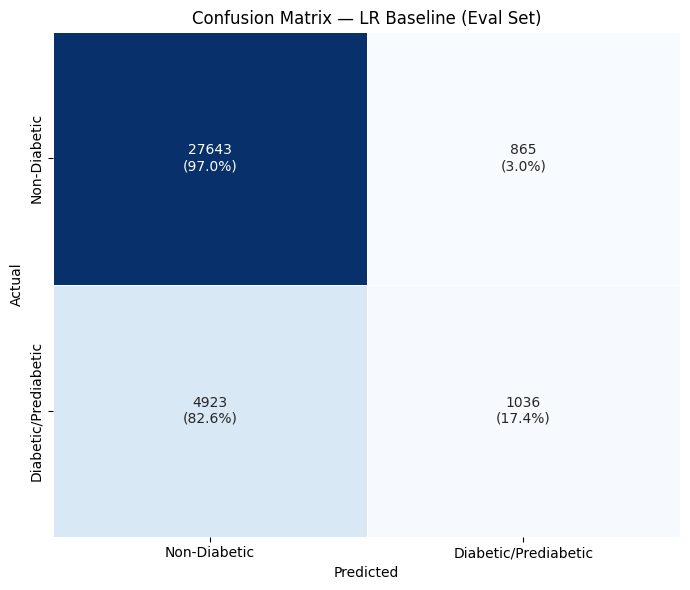

In [27]:
# Fit on train set
lr_raw_none_default.fit(X_train_raw, y_train)

# Predict on eval set
y_pred_base = lr_raw_none_default.predict(X_eval_raw)
y_proba_base = lr_raw_none_default.predict_proba(X_eval_raw)

# Evaluate on eval set
metrics_lr_base = evaluate_binary_classifier(y_eval, y_pred_base, y_proba_base)
print(metrics_lr_base)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_base))
print("\nClassification report:\n", classification_report(y_eval, y_pred_base, digits=3))

# Log (baseline)
log_experiment(
    exp_id="LR__raw__none__default",
    model_family="LR",
    features="raw",
    sampling="none",
    tuning="default",
    notes="Baseline LR on raw features (no class weighting), evaluated on validation set",
    metrics=metrics_lr_base,
    params=lr_raw_none_default.get_params()
)

results_df()

# ==========================
# Report-ready confusion matrix (counts + row %), LR baseline (binary)
# ==========================
class_names = ["Non-Diabetic", "Diabetic/Prediabetic"]

# Confusion matrix (counts)
cm_lr_base = confusion_matrix(y_eval, y_pred_base, labels=[0, 1])
cm_lr_base_df = pd.DataFrame(cm_lr_base, index=class_names, columns=class_names)

# Row-normalized percentages
cm_lr_base_row_pct = cm_lr_base_df.div(cm_lr_base_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_lr_base_annot = cm_lr_base_df.astype(int).astype(str) + "\n(" + cm_lr_base_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_lr_base_table = cm_lr_base_df.copy()
for r in cm_lr_base_table.index:
    for c in cm_lr_base_table.columns:
        cm_lr_base_table.loc[r, c] = f"{cm_lr_base_df.loc[r, c]} ({cm_lr_base_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_lr_base_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_lr_base_df,
    annot=cm_lr_base_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — LR Baseline (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_lr_baseline_eval.png")
plt.show()

In [28]:
# ==========================
# 2nd Model: Balanced LR
# LR__raw__classweight__default
# ==========================

lr_raw_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight="balanced"   # only change vs baseline
    ))
])

# Fit on TRAIN
lr_raw_classweight_default.fit(X_train_raw, y_train)

# Predict on EVAL (NOT test)
y_pred_cw = lr_raw_classweight_default.predict(X_eval_raw)
y_proba_cw = lr_raw_classweight_default.predict_proba(X_eval_raw)

# Evaluate on EVAL
metrics_lr_cw = evaluate_binary_classifier(y_eval, y_pred_cw, y_proba_cw)
print(metrics_lr_cw)

# Diagnostics
print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_cw, digits=3))

# Log experiment
log_experiment(
    exp_id="LR__raw__classweight__default",
    model_family="LR",
    features="raw",
    sampling="classweight",
    tuning="default",
    notes="LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)",
    metrics=metrics_lr_cw,
    params=lr_raw_classweight_default.get_params()
)

results_df()

{'accuracy': 0.7181652014970842, 'balanced_accuracy': 0.7341899335369966, 'f1_macro': 0.6442474579365023, 'f1_weighted': 0.7503368984270861, 'f1_class_1 (diabetic)': 0.482085732565579, 'log_loss': 0.5475310279097895, 'brier_score': 0.18487934172936243, 'roc_auc': 0.804930856974038, 'pr_auc': 0.4301130115016047, 'mcc': 0.3665934880536623, 'precision_class_0 (NPV)': np.float64(0.9336409783110291), 'recall_class_0 (specificity)': np.float64(0.7096955240634208), 'f1_class_0': np.float64(0.8064091833074256), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.3532859263889974), 'recall_class_1 (sensitivity)': np.float64(0.7586843430105722), 'f1_class_1': np.float64(0.482085732565579), 'support_class_1': 5959}

Confusion matrix:
 [[20232  8276]
 [ 1438  4521]]

Classification report:
               precision    recall  f1-score   support

           0      0.934     0.710     0.806     28508
           1      0.353     0.759     0.482      5959

    accuracy                    

experiment model features     sampling   tuning  \
0         LR__raw__none__default    LR      raw         none  default   
1  LR__raw__classweight__default    LR      raw  classweight  default   

                                                                                          notes  \
0                 Baseline LR on raw features (no class weighting), evaluated on validation set   
1  LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   

   metric__precision_class_1 (PPV)  metric__recall_class_1 (sensitivity)  \
0                         0.544976                              0.173855   
1                         0.353286                              0.758684   

   metric__f1_class_1  metric__support_class_1  
0            0.263613                     5959  
1            0.482086                     5959

In [29]:
# ==========================
# Model 3: LR with Threshold Tuning (RAW FEATURES)
# LR__raw__classweight__thresh_tuned
# 
# Procedure:
#   - Use the same LR class_weight model (already fitted)
#   - Get predicted probabilities on eval
#   - Sweep thresholds (0.05 → 0.95)
#   - Choose threshold that maximizes MCC (or target sensitivity)
# ==========================

# Get probabilities from the balanced LR model (already fitted)
y_proba_cw_pos = y_proba_cw[:, 1]  # probability of class 1 (diabetic)

# Sweep thresholds and compute metrics
thresholds_to_try = np.arange(0.05, 0.96, 0.01)

threshold_results = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_proba_cw_pos >= thresh).astype(int)
    
    # Compute key metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_eval, y_pred_thresh, labels=[0, 1], zero_division=0
    )
    
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_eval, y_pred_thresh)
    f1_diabetic = f1[1]
    sensitivity = recall[1]  # recall for diabetic class
    specificity = recall[0]  # recall for non-diabetic class
    ppv = precision[1]       # precision for diabetic class
    
    threshold_results.append({
        "threshold": thresh,
        "mcc": mcc,
        "balanced_accuracy": bal_acc,
        "f1_diabetic": f1_diabetic,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
    })

df_thresh = pd.DataFrame(threshold_results)

# Find optimal thresholds for different objectives
best_mcc_idx = df_thresh["mcc"].idxmax()
best_f1_idx = df_thresh["f1_diabetic"].idxmax()

# Extract best threshold (maximize MCC)
best_threshold = df_thresh.loc[best_mcc_idx, "threshold"]

print(f"Best threshold (max MCC): {best_threshold:.3f}")
print(f"MCC at best threshold: {df_thresh.loc[best_mcc_idx, 'mcc']:.4f}")

# Target sensitivity threshold (e.g., sensitivity >= 0.80)
target_sensitivity = 0.80
df_high_sens = df_thresh[df_thresh["sensitivity"] >= target_sensitivity]
if len(df_high_sens) > 0:
    best_sens_target_idx = df_high_sens["mcc"].idxmax()
    best_sens_target_thresh = df_thresh.loc[best_sens_target_idx, "threshold"]
    print(f"Best threshold achieving sensitivity ≥ {target_sensitivity}: {best_sens_target_thresh:.3f}")
else:
    best_sens_target_thresh = None
    print(f"No threshold achieves sensitivity ≥ {target_sensitivity}")

# Apply best threshold and evaluate
y_pred_thresh_tuned = (y_proba_cw_pos >= best_threshold).astype(int)

metrics_lr_thresh = evaluate_binary_classifier(y_eval, y_pred_thresh_tuned, y_proba_cw)
print("\nMetrics with tuned threshold:")
print(metrics_lr_thresh)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_thresh_tuned))
print("\nClassification report:\n", classification_report(y_eval, y_pred_thresh_tuned, digits=3))

# Log experiment
log_experiment(
    exp_id="LR__raw__classweight__thresh_tuned",
    model_family="LR",
    features="raw",
    sampling="classweight",
    tuning="thresh_tuned",
    notes=f"LR class_weight='balanced' with threshold={best_threshold:.2f} (maximizes MCC on eval set)",
    metrics=metrics_lr_thresh,
    params={**lr_raw_classweight_default.get_params(), "threshold": best_threshold}
)

results_df()

Best threshold (max MCC): 0.570
MCC at best threshold: 0.3695
Best threshold achieving sensitivity ≥ 0.8: 0.460

Metrics with tuned threshold:
{'accuracy': 0.7581164592218644, 'balanced_accuracy': 0.7242280207252246, 'f1_macro': 0.6657867936097435, 'f1_weighted': 0.7807096038265526, 'f1_class_1 (diabetic)': 0.4901229282612684, 'log_loss': 0.5475310279097895, 'brier_score': 0.18487934172936243, 'roc_auc': 0.804930856974038, 'pr_auc': 0.4301130115016047, 'mcc': 0.36953640534326965, 'precision_class_0 (NPV)': np.float64(0.918920041536864), 'recall_class_0 (specificity)': np.float64(0.7760277816753192), 'f1_class_0': np.float64(0.8414506589582185), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.38558506543494997), 'recall_class_1 (sensitivity)': np.float64(0.6724282597751301), 'f1_class_1': np.float64(0.4901229282612684), 'support_class_1': 5959}

Confusion matrix:
 [[22123  6385]
 [ 1952  4007]]

Classification report:
               precision    recall  f1-score   supp

experiment model features     sampling  \
0              LR__raw__none__default    LR      raw         none   
1       LR__raw__classweight__default    LR      raw  classweight   
2  LR__raw__classweight__thresh_tuned    LR      raw  classweight   

         tuning  \
0       default   
1       default   
2  thresh_tuned   

                                                                                          notes  \
0                 Baseline LR on raw features (no class weighting), evaluated on validation set   
1  LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                    LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   
2                         0.918920                              0.776028   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   
2            0.841451                    28508   

   metric__precision_class_1 (PPV)  metric__recall_class_1 (sensitivity)  \
0                         0.544976                              0.173855   
1                         0.353286                              0.758684   
2                         0.385585                              0.672428   

   metric__f1_class_1  metric__support_class_1  
0            0.263613                     5959  
1            0.482086                     5959  
2            0.490123                     5959

**Feature engineering**
- Now that a model baseline has been established, its important to engineer features


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/corr_matrix_raw_train.png


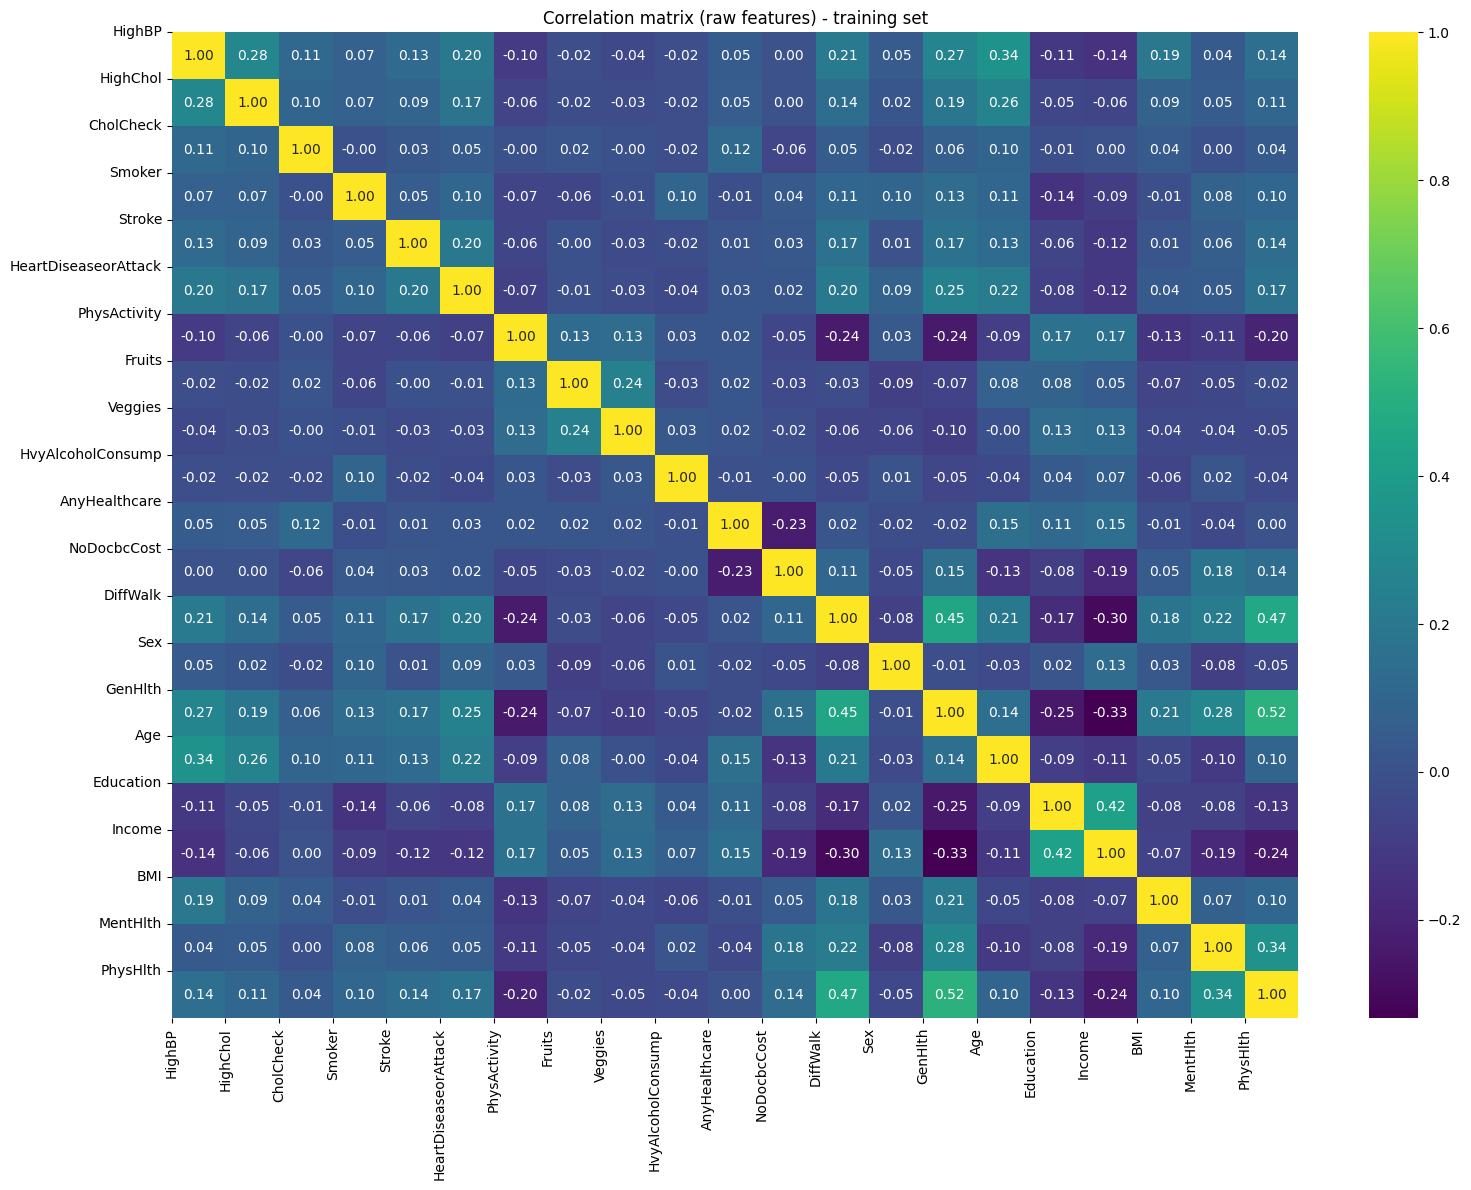

In [30]:
corr = X_train_raw.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap = 'viridis', annot=True, fmt=".2f")
plt.title("Correlation matrix (raw features) - training set")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
savefig("corr_matrix_raw_train.png")
plt.show()


In [31]:
# List of highly correlated features, threshold = 0.7 (initial value)
# unable to fully identify from the graph

# Find highly correlated feature pairs (absolute corr >= threshold)
threshold = 0.4

corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    .sort_values("abs_corr", ascending=False)
)

high_corr_pairs_filtered = high_corr_pairs[high_corr_pairs["abs_corr"] >= threshold]

print(f"Number of pairs with abs(corr) >= {threshold}: {len(high_corr_pairs_filtered)}")
high_corr_pairs_filtered.head(20)

Number of pairs with abs(corr) >= 0.4: 4


Number of pairs with abs(corr) >= 0.4: 4


feature_1 feature_2  abs_corr
194    GenHlth  PhysHlth  0.516329
181   DiffWalk  PhysHlth  0.465702
175   DiffWalk   GenHlth  0.448440
200  Education    Income  0.421566

**Create new features**

In [32]:
# Create features
# 1 RiskFactorCount = sum of major risk flags - captures cumulative burden
# 2 BMI x physical activity interaction - BMI changes depending on activity
# 3 Age x high BP - BP risk increases with age
# 4 log1p mental health and physical health. they are skewed. 

# ===========================
# Create feature set A
# ===========================

X_train_fe_A = X_train_raw.copy()
X_test_fe_A = X_test_raw.copy()
X_eval_fe_A = X_eval_raw.copy()

# Add features
# 1 RiskFactorCount
risk_flags_A = ["HighBP","HighChol","Smoker","Stroke","HeartDiseaseorAttack","DiffWalk"]
X_train_fe_A["RiskFactorCount"] = X_train_fe_A[risk_flags_A].sum(axis=1)
X_test_fe_A["RiskFactorCount"] = X_test_fe_A[risk_flags_A].sum(axis=1)
X_eval_fe_A["RiskFactorCount"] = X_eval_fe_A[risk_flags_A].sum(axis=1)

# 2 BMI x physical activity interaction
X_train_fe_A["BMI_PhysActivity"] = X_train_fe_A["BMI"] * X_train_fe_A["PhysActivity"]
X_test_fe_A["BMI_PhysActivity"] = X_test_fe_A["BMI"] * X_test_fe_A["PhysActivity"]
X_eval_fe_A["BMI_PhysActivity"] = X_eval_fe_A["BMI"] * X_eval_fe_A["PhysActivity"]

# 3 Age x high BP interaction
X_train_fe_A["Age_HighBP"] = X_train_fe_A["Age"] * X_train_fe_A["HighBP"]
X_test_fe_A["Age_HighBP"] = X_test_fe_A["Age"] * X_test_fe_A["HighBP"]
X_eval_fe_A["Age_HighBP"] = X_eval_fe_A["Age"] * X_eval_fe_A["HighBP"]

# 4 log1p mental health and physical health (skewed)
X_train_fe_A["Log1p_MentHlth"] = np.log1p(X_train_fe_A["MentHlth"])
X_test_fe_A["Log1p_MentHlth"] = np.log1p(X_test_fe_A["MentHlth"])
X_eval_fe_A["Log1p_MentHlth"] = np.log1p(X_eval_fe_A["MentHlth"])
X_train_fe_A["Log1p_PhysHlth"] = np.log1p(X_train_fe_A["PhysHlth"])
X_test_fe_A["Log1p_PhysHlth"] = np.log1p(X_test_fe_A["PhysHlth"])
X_eval_fe_A["Log1p_PhysHlth"] = np.log1p(X_eval_fe_A["PhysHlth"])

# check everything worked as planned
print("Feature set A created")
print("Raw feature count: ", X_train_raw.shape[1])
print("Engineered feature count: ", X_train_fe_A.shape[1])

new_columns_A = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]

print ("New columns added in train:", all(c in X_train_fe_A.columns for c in new_columns_A))
print ("New columns added in test:", all(c in X_test_fe_A.columns for c in new_columns_A))
print ("New columns added in eval:", all(c in X_eval_fe_A.columns for c in new_columns_A))

Feature set A created
Raw feature count:  21
Engineered feature count:  26
New columns added in train: True
New columns added in test: True
New columns added in eval: True


In [33]:
# Save feature set A to a single CSV (with target + split)
feature_set_A_path = PROJECT_ROOT / "data" / "processed" / "CDC_Diabetes_Dataset_feature_set_A.csv"

train_df = X_train_fe_A.copy()
train_df["Diabetes_binary"] = y_train.values
train_df["split"] = "train"

eval_df = X_eval_fe_A.copy()
eval_df["Diabetes_binary"] = y_eval.values
eval_df["split"] = "eval"

test_df = X_test_fe_A.copy()
test_df["Diabetes_binary"] = y_test.values
test_df["split"] = "test"

feature_set_A_all = pd.concat([train_df, eval_df, test_df], ignore_index=True)
feature_set_A_all.to_csv(feature_set_A_path, index=False)

print(f"Feature set A saved to {feature_set_A_path}")


Feature set A saved to /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/data/processed/CDC_Diabetes_Dataset_feature_set_A.csv


In [34]:
# ==========================
# LR on Feature Set A (no balancing)
# LR__featA__none__default
# ==========================

# 1) Update feature lists to include engineered numeric columns
engineered_numeric_A = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]
numeric_features_A = numeric_features + engineered_numeric_A

preprocess_featA = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_A),
        ("ord", StandardScaler(), ordinal_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

lr_featA_none_default = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight=None
    ))
])

# 2) Fit on TRAIN
lr_featA_none_default.fit(X_train_fe_A, y_train)

# 3) Evaluate on EVAL
y_pred_featA = lr_featA_none_default.predict(X_eval_fe_A)
y_proba_featA = lr_featA_none_default.predict_proba(X_eval_fe_A)

metrics_lr_featA = evaluate_binary_classifier(y_eval, y_pred_featA, y_proba_featA)
print(metrics_lr_featA)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_featA))
print("\nClassification report:\n", classification_report(y_eval, y_pred_featA, digits=3))

log_experiment(
    exp_id="LR__featA__none__default",
    model_family="LR",
    features="featA",
    sampling="none",
    tuning="default",
    notes="LR on Feature Set A engineered features, no balancing (eval set)",
    metrics=metrics_lr_featA,
    params=lr_featA_none_default.get_params()
)

results_df()

{'accuracy': 0.8323613891548438, 'balanced_accuracy': 0.5709360297564907, 'f1_macro': 0.5832903490830561, 'f1_weighted': 0.7940571476937341, 'f1_class_1 (diabetic)': 0.2611253196930946, 'log_loss': 0.372321250464341, 'brier_score': 0.11790056448833032, 'roc_auc': 0.8047524419297264, 'pr_auc': 0.43370374412943224, 'mcc': 0.2373804738361811, 'precision_class_0 (NPV)': np.float64(0.8485554805863952), 'recall_class_0 (specificity)': np.float64(0.9705345867826575), 'f1_class_0': np.float64(0.9054553784730176), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.5486297689414293), 'recall_class_1 (sensitivity)': np.float64(0.17133747273032388), 'f1_class_1': np.float64(0.2611253196930946), 'support_class_1': 5959}

Confusion matrix:
 [[27668   840]
 [ 4938  1021]]

Classification report:
               precision    recall  f1-score   support

           0      0.849     0.971     0.905     28508
           1      0.549     0.171     0.261      5959

    accuracy                

experiment model features     sampling  \
0              LR__raw__none__default    LR      raw         none   
1       LR__raw__classweight__default    LR      raw  classweight   
2  LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3            LR__featA__none__default    LR    featA         none   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   

                                                                                          notes  \
0                 Baseline LR on raw features (no class weighting), evaluated on validation set   
1  LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                    LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                              LR on Feature Set A engineered features, no balancing (eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.433704     0.237380   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   
2                         0.918920                              0.776028   
3                         0.848555                              0.970535   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   
2            0.841451                    28508   
3            0.905455                    28508   

   metric__precision_class_1 (PPV)  metric__recall_class_1 (sensitivity)  \
0                         0.544976                              0.173855   
1                         0.353286                              0.758684   
2                         0.385585                              0.672428   
3                         0.548630                              0.171337   

   metric__f1_class_1  metric__support_class_1  
0            0.263613                     5959  
1            0.482086                     5959  
2            0.490123                     5959  
3            0.261125                     5959

In [35]:
# ==========================
# LR on Feature Set A (class weighted)
# LR__featA__classweight__default
# ==========================

lr_featA_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight="balanced"
    ))
])

# Fit on TRAIN
lr_featA_classweight_default.fit(X_train_fe_A, y_train)

# Evaluate on EVAL
y_pred_featA_cw = lr_featA_classweight_default.predict(X_eval_fe_A)
y_proba_featA_cw = lr_featA_classweight_default.predict_proba(X_eval_fe_A)

metrics_lr_featA_cw = evaluate_binary_classifier(
    y_eval, y_pred_featA_cw, y_proba_featA_cw
)
print(metrics_lr_featA_cw)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_featA_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_featA_cw, digits=3))

log_experiment(
    exp_id="LR__featA__classweight__default",
    model_family="LR",
    features="featA",
    sampling="classweight",
    tuning="default",
    notes="LR on Feature Set A with class_weight='balanced' (eval set)",
    metrics=metrics_lr_featA_cw,
    params=lr_featA_classweight_default.get_params()
)

results_df()

{'accuracy': 0.7150607827777294, 'balanced_accuracy': 0.7341051968395513, 'f1_macro': 0.6422420510874165, 'f1_weighted': 0.7478362363533242, 'f1_class_1 (diabetic)': 0.48083734207326745, 'log_loss': 0.5463430288234497, 'brier_score': 0.1849876400187676, 'roc_auc': 0.8051767317302441, 'pr_auc': 0.4321983858868506, 'mcc': 0.3655375700094634, 'precision_class_0 (NPV)': np.float64(0.9343995536752058), 'recall_class_0 (specificity)': np.float64(0.7049950890977971), 'f1_class_0': np.float64(0.8036467601015654), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.35098008951998766), 'recall_class_1 (sensitivity)': np.float64(0.7632153045813056), 'f1_class_1': np.float64(0.48083734207326745), 'support_class_1': 5959}

Confusion matrix:
 [[20098  8410]
 [ 1411  4548]]

Classification report:
               precision    recall  f1-score   support

           0      0.934     0.705     0.804     28508
           1      0.351     0.763     0.481      5959

    accuracy               

experiment model features     sampling  \
0              LR__raw__none__default    LR      raw         none   
1       LR__raw__classweight__default    LR      raw  classweight   
2  LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3            LR__featA__none__default    LR    featA         none   
4     LR__featA__classweight__default    LR    featA  classweight   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   
4       default   

                                                                                          notes  \
0                 Baseline LR on raw features (no class weighting), evaluated on validation set   
1  LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                    LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                              LR on Feature Set A engineered features, no balancing (eval set)   
4                                   LR on Feature Set A with class_weight='balanced' (eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   
4          0.715061                   0.734105          0.642242   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   
4             0.747836                       0.480837          0.546343   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.433704     0.237380   
4             0.184988         0.805177        0.432198     0.365538   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   
2                         0.918920                              0.776028   
3                         0.848555                              0.970535   
4                         0.934400                              0.704995   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   
2            0.841451                    28508   
3            0.905455                    28508   
4            0.803647                    28508   

   metric__precision_class_1 (PPV)  metric__recall_class_1 (sensitivity)  \
0                         0.544976                              0.173855   
1                         0.353286                              0.758684   
2                         0.385585                              0.672428   
3                         0.548630                              0.171337   
4                         0.350980                              0.763215   

   metric__f1_class_1  metric__support_class_1  
0            0.263613                     5959  
1            0.482086                     5959  
2            0.490123                     5959  
3            0.261125                     5959  
4            0.480837                     5959

In [36]:
# ==========================
# LR on Feature Set A (balanced + threshold tuning)
# LR__featA__classweight__thresh_tuned
# ==========================

# Get probabilities from the balanced LR model on Feature Set A (already fitted)
y_proba_featA_cw_pos = y_proba_featA_cw[:, 1]  # probability of class 1 (diabetic)

# Sweep thresholds and compute metrics
thresholds_to_try = np.arange(0.05, 0.96, 0.01)

threshold_results_featA = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_proba_featA_cw_pos >= thresh).astype(int)
    
    # Compute key metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_eval, y_pred_thresh, labels=[0, 1], zero_division=0
    )
    
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_eval, y_pred_thresh)
    f1_diabetic = f1[1]
    sensitivity = recall[1]  # recall for diabetic class
    specificity = recall[0]  # recall for non-diabetic class
    ppv = precision[1]       # precision for diabetic class
    
    threshold_results_featA.append({
        "threshold": thresh,
        "mcc": mcc,
        "balanced_accuracy": bal_acc,
        "f1_diabetic": f1_diabetic,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
    })

df_thresh_featA = pd.DataFrame(threshold_results_featA)

# Find optimal threshold (maximize MCC)
best_mcc_idx_featA = df_thresh_featA["mcc"].idxmax()
best_threshold_featA = df_thresh_featA.loc[best_mcc_idx_featA, "threshold"]

print(f"Best threshold for Feature Set A (max MCC): {best_threshold_featA:.3f}")
print(f"MCC at best threshold: {df_thresh_featA.loc[best_mcc_idx_featA, 'mcc']:.4f}")

# Apply best threshold and evaluate
y_pred_featA_thresh_tuned = (y_proba_featA_cw_pos >= best_threshold_featA).astype(int)

metrics_lr_featA_thresh = evaluate_binary_classifier(y_eval, y_pred_featA_thresh_tuned, y_proba_featA_cw)
print("\nMetrics with tuned threshold (Feature Set A):")
print(metrics_lr_featA_thresh)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_featA_thresh_tuned))
print("\nClassification report:\n", classification_report(y_eval, y_pred_featA_thresh_tuned, digits=3))

# Log experiment
log_experiment(
    exp_id="LR__featA__classweight__thresh_tuned",
    model_family="LR",
    features="featA",
    sampling="classweight",
    tuning="thresh_tuned",
    notes=f"LR on Feature Set A with class_weight='balanced' and threshold={best_threshold_featA:.2f} (maximizes MCC on eval set)",
    metrics=metrics_lr_featA_thresh,
    params={**lr_featA_classweight_default.get_params(), "threshold": best_threshold_featA}
)

results_df()

Best threshold for Feature Set A (max MCC): 0.550
MCC at best threshold: 0.3706

Metrics with tuned threshold (Feature Set A):
{'accuracy': 0.7464241158209302, 'balanced_accuracy': 0.7293051292950734, 'f1_macro': 0.6604028509236308, 'f1_weighted': 0.7722200816937469, 'f1_class_1 (diabetic)': 0.4894859813084112, 'log_loss': 0.5463430288234497, 'brier_score': 0.1849876400187676, 'roc_auc': 0.8051767317302441, 'pr_auc': 0.4321983858868506, 'mcc': 0.3706196211862518, 'precision_class_0 (NPV)': np.float64(0.924096799107526), 'recall_class_0 (specificity)': np.float64(0.755472148168935), 'f1_class_0': np.float64(0.8313197205388505), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.3754143893916316), 'recall_class_1 (sensitivity)': np.float64(0.7031381104212117), 'f1_class_1': np.float64(0.4894859813084112), 'support_class_1': 5959}

Confusion matrix:
 [[21537  6971]
 [ 1769  4190]]

Classification report:
               precision    recall  f1-score   support

           0  

experiment model features     sampling  \
0                LR__raw__none__default    LR      raw         none   
1         LR__raw__classweight__default    LR      raw  classweight   
2    LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3              LR__featA__none__default    LR    featA         none   
4       LR__featA__classweight__default    LR    featA  classweight   
5  LR__featA__classweight__thresh_tuned    LR    featA  classweight   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   
4       default   
5  thresh_tuned   

                                                                                             notes  \
0                    Baseline LR on raw features (no class weighting), evaluated on validation set   
1     LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                       LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                 LR on Feature Set A engineered features, no balancing (eval set)   
4                                      LR on Feature Set A with class_weight='balanced' (eval set)   
5  LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   
4          0.715061                   0.734105          0.642242   
5          0.746424                   0.729305          0.660403   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   
4             0.747836                       0.480837          0.546343   
5             0.772220                       0.489486          0.546343   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.433704     0.237380   
4             0.184988         0.805177        0.432198     0.365538   
5             0.184988         0.805177        0.432198     0.370620   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   
2                         0.918920                              0.776028   
3                         0.848555                              0.970535   
4                         0.934400                              0.704995   
5                         0.924097                              0.755472   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   
2            0.841451                    28508   
3            0.905455                    28508   
4            0.803647                    28508   
5            0.831320                    28508   

   metric__precision_class_1 (PPV)  metric__recall_class_1 (sensitivity)  \
0                         0.544976                              0.173855   
1                         0.353286                              0.758684   
2                         0.385585                            

In [37]:
# ==========================
# XGBoost Baseline (BINARY)
# XGB__raw__none__default
# ==========================

xgb_raw_none_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="binary:logistic",  #  Binary classification
        eval_metric="logloss",         #  Binary log loss
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    ))
])

# Fit on TRAIN
xgb_raw_none_default.fit(X_train_raw, y_train)

# Evaluate on EVAL
y_pred_xgb = xgb_raw_none_default.predict(X_eval_raw)
y_proba_xgb = xgb_raw_none_default.predict_proba(X_eval_raw)

metrics_xgb = evaluate_binary_classifier(y_eval, y_pred_xgb, y_proba_xgb)  #  Binary eval
print(metrics_xgb)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb, digits=3))

log_experiment(
    exp_id="XGB__raw__none__default",
    model_family="XGB",
    features="raw",
    sampling="none",
    tuning="default",
    notes="Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)",
    metrics=metrics_xgb,
    params=xgb_raw_none_default.get_params()
)

results_df()

{'accuracy': 0.8379319348942467, 'balanced_accuracy': 0.5863160699888507, 'f1_macro': 0.6046090898277612, 'f1_weighted': 0.8033172831051031, 'f1_class_1 (diabetic)': 0.3008760951188986, 'log_loss': 0.3627471586451627, 'brier_score': 0.11446885764598846, 'roc_auc': 0.8157839178778196, 'pr_auc': 0.4673194182948189, 'mcc': 0.27721907773329874, 'precision_class_0 (NPV)': np.float64(0.8533419657171044), 'recall_class_0 (specificity)': np.float64(0.9709204433843132), 'f1_class_0': np.float64(0.9083420845366238), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.5918266863613983), 'recall_class_1 (sensitivity)': np.float64(0.20171169659338814), 'f1_class_1': np.float64(0.3008760951188986), 'support_class_1': 5959}

Confusion matrix:
 [[27679   829]
 [ 4757  1202]]

Classification report:
               precision    recall  f1-score   support

           0      0.853     0.971     0.908     28508
           1      0.592     0.202     0.301      5959

    accuracy               

experiment model features     sampling  \
0                LR__raw__none__default    LR      raw         none   
1         LR__raw__classweight__default    LR      raw  classweight   
2    LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3              LR__featA__none__default    LR    featA         none   
4       LR__featA__classweight__default    LR    featA  classweight   
5  LR__featA__classweight__thresh_tuned    LR    featA  classweight   
6               XGB__raw__none__default   XGB      raw         none   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   
4       default   
5  thresh_tuned   
6       default   

                                                                                             notes  \
0                    Baseline LR on raw features (no class weighting), evaluated on validation set   
1     LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                       LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                 LR on Feature Set A engineered features, no balancing (eval set)   
4                                      LR on Feature Set A with class_weight='balanced' (eval set)   
5  LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   
6                  Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   
4          0.715061                   0.734105          0.642242   
5          0.746424                   0.729305          0.660403   
6          0.837932                   0.586316          0.604609   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   
4             0.747836                       0.480837          0.546343   
5             0.772220                       0.489486          0.546343   
6             0.803317                       0.300876          0.362747   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.433704     0.237380   
4             0.184988         0.805177        0.432198     0.365538   
5             0.184988         0.805177        0.432198     0.370620   
6             0.114469         0.815784        0.467319     0.277219   

   metric__precision_class_0 (NPV)  metric__recall_class_0 (specificity)  \
0                         0.848830                              0.969658   
1                         0.933641                              0.709696   
2                         0.918920                              0.776028   
3                         0.848555                              0.970535   
4                         0.934400                              0.704995   
5                         0.924097                              0.755472   
6                         0.853342                              0.970920   

   metric__f1_class_0  metric__support_class_0  \
0            0.905230                    28508   
1            0.806409                    28508   
2       

{'accuracy': 0.709084051411495, 'balanced_accuracy': 0.7393190879220909, 'f1_macro': 0.6402347139567308, 'f1_weighted': 0.7431982177548127, 'f1_class_1 (diabetic)': 0.48285110113982155, 'log_loss': 0.5292983359980545, 'brier_score': 0.18129439651966095, 'roc_auc': 0.8153419890697372, 'pr_auc': 0.4671560693033381, 'mcc': 0.3711483145177277, 'precision_class_0 (NPV)': np.float64(0.9392498930455864), 'recall_class_0 (specificity)': np.float64(0.6931036901922267), 'f1_class_0': np.float64(0.7976183267736401), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.348548026805659), 'recall_class_1 (sensitivity)': np.float64(0.785534485651955), 'f1_class_1': np.float64(0.48285110113982155), 'support_class_1': 5959}

Confusion matrix:
 [[19759  8749]
 [ 1278  4681]]

Classification report:
               precision    recall  f1-score   support

           0      0.939     0.693     0.798     28508
           1      0.349     0.786     0.483      5959

    accuracy                  

{'accuracy': 0.709084051411495, 'balanced_accuracy': 0.7393190879220909, 'f1_macro': 0.6402347139567308, 'f1_weighted': 0.7431982177548127, 'f1_class_1 (diabetic)': 0.48285110113982155, 'log_loss': 0.5292983359980545, 'brier_score': 0.18129439651966095, 'roc_auc': 0.8153419890697372, 'pr_auc': 0.4671560693033381, 'mcc': 0.3711483145177277, 'precision_class_0 (NPV)': np.float64(0.9392498930455864), 'recall_class_0 (specificity)': np.float64(0.6931036901922267), 'f1_class_0': np.float64(0.7976183267736401), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.348548026805659), 'recall_class_1 (sensitivity)': np.float64(0.785534485651955), 'f1_class_1': np.float64(0.48285110113982155), 'support_class_1': 5959}

Confusion matrix:
 [[19759  8749]
 [ 1278  4681]]

Classification report:
               precision    recall  f1-score   support

           0      0.939     0.693     0.798     28508
           1      0.349     0.786     0.483      5959

    accuracy                  

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/1164560868.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19759 (69.3%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_cw_table.loc[r, c] = f"{cm_xgb_cw_df.loc[r, c]} ({cm_xgb_cw_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/1164560868.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8749 (30.7%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_cw_table.loc[r, c] = f"{cm_xgb_cw_df.loc[r, c]} ({cm_xgb_cw_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          19759 (69.3%)         8749 (30.7%)
Diabetic/Prediabetic   1278 (21.4%)         4681 (78.6%)

{'accuracy': 0.709084051411495, 'balanced_accuracy': 0.7393190879220909, 'f1_macro': 0.6402347139567308, 'f1_weighted': 0.7431982177548127, 'f1_class_1 (diabetic)': 0.48285110113982155, 'log_loss': 0.5292983359980545, 'brier_score': 0.18129439651966095, 'roc_auc': 0.8153419890697372, 'pr_auc': 0.4671560693033381, 'mcc': 0.3711483145177277, 'precision_class_0 (NPV)': np.float64(0.9392498930455864), 'recall_class_0 (specificity)': np.float64(0.6931036901922267), 'f1_class_0': np.float64(0.7976183267736401), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.348548026805659), 'recall_class_1 (sensitivity)': np.float64(0.785534485651955), 'f1_class_1': np.float64(0.48285110113982155), 'support_class_1': 5959}

Confusion matrix:
 [[19759  8749]
 [ 1278  4681]]

Classification report:
               precision    recall  f1-score   support

           0      0.939     0.693     0.798     28508
           1      0.349     0.786     0.483      5959

    accuracy                  

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/1164560868.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19759 (69.3%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_cw_table.loc[r, c] = f"{cm_xgb_cw_df.loc[r, c]} ({cm_xgb_cw_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/1164560868.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8749 (30.7%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_cw_table.loc[r, c] = f"{cm_xgb_cw_df.loc[r, c]} ({cm_xgb_cw_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          19759 (69.3%)         8749 (30.7%)
Diabetic/Prediabetic   1278 (21.4%)         4681 (78.6%)

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_xgb_classweight_eval.png


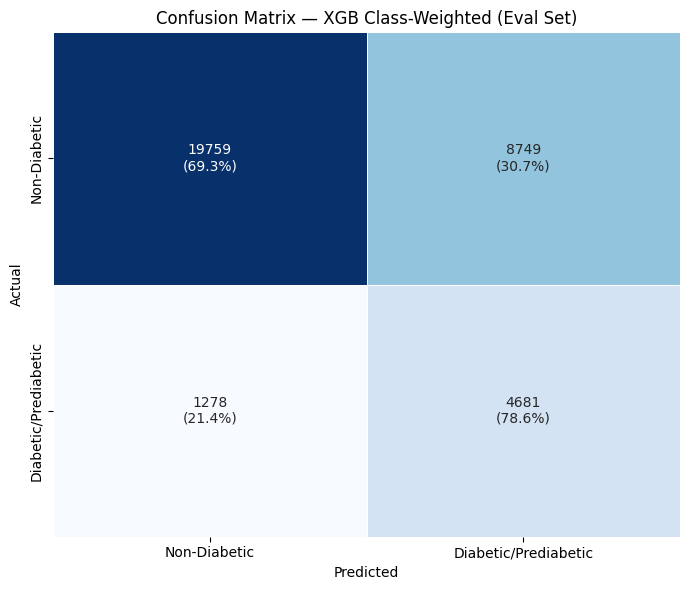

In [38]:
# ==========================
# XGB with class-balanced sample weights (BINARY)
# XGB__raw__classweight__default
# ==========================

# Compute per-row weights from class frequencies in TRAIN set only
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

xgb_raw_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="binary:logistic",  # Binary classification
        eval_metric="logloss",         #  Binary log loss
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    ))
])

# Fit with sample weights (pass to the classifier step)
xgb_raw_classweight_default.fit(
    X_train_raw, y_train,
    clf__sample_weight=sample_w
)

# Evaluate on EVAL
y_pred_xgb_cw = xgb_raw_classweight_default.predict(X_eval_raw)
y_proba_xgb_cw = xgb_raw_classweight_default.predict_proba(X_eval_raw)

metrics_xgb_cw = evaluate_binary_classifier(y_eval, y_pred_xgb_cw, y_proba_xgb_cw)
print(metrics_xgb_cw)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_cw, digits=3))

log_experiment(
    exp_id="XGB__raw__classweight__default",
    model_family="XGB",
    features="raw",
    sampling="classweight",
    tuning="default",
    notes="XGBoost with class-balanced sample weights, threshold=0.50 (eval set)",
    metrics=metrics_xgb_cw,
    params=xgb_raw_classweight_default.get_params()
)

results_df()

# ==========================
# Report-ready confusion matrix (counts + row %), XGB raw + classweight
# ==========================
class_names = ["Non-Diabetic", "Diabetic/Prediabetic"]

# Confusion matrix (counts)
cm_xgb_cw = confusion_matrix(y_eval, y_pred_xgb_cw, labels=[0, 1])
cm_xgb_cw_df = pd.DataFrame(cm_xgb_cw, index=class_names, columns=class_names)

# Row-normalized percentages
cm_xgb_cw_row_pct = cm_xgb_cw_df.div(cm_xgb_cw_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_xgb_cw_annot = cm_xgb_cw_df.astype(int).astype(str) + "\n(" + cm_xgb_cw_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_xgb_cw_table = cm_xgb_cw_df.copy()
for r in cm_xgb_cw_table.index:
    for c in cm_xgb_cw_table.columns:
        cm_xgb_cw_table.loc[r, c] = f"{cm_xgb_cw_df.loc[r, c]} ({cm_xgb_cw_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_xgb_cw_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_xgb_cw_df,
    annot=cm_xgb_cw_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — XGB Class-Weighted (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_xgb_classweight_eval.png")
plt.show()

In [39]:
# ==========================
# XGB with class-balanced sample weights + threshold tuning (BINARY)
# XGB__raw__classweight__thresh_tuned
# 
# Procedure:
#   - Use the fitted xgb_raw_classweight_default model
#   - Get predicted probabilities on eval
#   - Sweep thresholds (0.05 → 0.95)
#   - Choose threshold that maximizes MCC
# ==========================

# Get probabilities from the class-weighted XGB model (already fitted)
y_proba_xgb_cw_pos = y_proba_xgb_cw[:, 1]  # probability of class 1 (diabetic)

# Sweep thresholds and compute metrics
thresholds_to_try = np.arange(0.05, 0.96, 0.01)

threshold_results_xgb = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_proba_xgb_cw_pos >= thresh).astype(int)
    
    # Compute key metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_eval, y_pred_thresh, labels=[0, 1], zero_division=0
    )
    
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_eval, y_pred_thresh)
    f1_diabetic = f1[1]
    sensitivity = recall[1]  # recall for diabetic class
    specificity = recall[0]  # recall for non-diabetic class
    ppv = precision[1]       # precision for diabetic class
    
    threshold_results_xgb.append({
        "threshold": thresh,
        "mcc": mcc,
        "balanced_accuracy": bal_acc,
        "f1_diabetic": f1_diabetic,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
    })

df_thresh_xgb = pd.DataFrame(threshold_results_xgb)

# Find optimal threshold (maximize MCC)
best_mcc_idx_xgb = df_thresh_xgb["mcc"].idxmax()
best_threshold_xgb = df_thresh_xgb.loc[best_mcc_idx_xgb, "threshold"]

print(f"Best threshold for XGB (max MCC): {best_threshold_xgb:.3f}")
print(f"MCC at best threshold: {df_thresh_xgb.loc[best_mcc_idx_xgb, 'mcc']:.4f}")

# Apply best threshold and evaluate
y_pred_xgb_thresh_tuned = (y_proba_xgb_cw_pos >= best_threshold_xgb).astype(int)

metrics_xgb_thresh = evaluate_binary_classifier(y_eval, y_pred_xgb_thresh_tuned, y_proba_xgb_cw)
print("\nMetrics with tuned threshold (XGB):")
print(metrics_xgb_thresh)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_thresh_tuned))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_thresh_tuned, digits=3))

# Log experiment
log_experiment(
    exp_id="XGB__raw__classweight__thresh_tuned",
    model_family="XGB",
    features="raw",
    sampling="classweight",
    tuning="thresh_tuned",
    notes=f"XGBoost with class-balanced sample weights and threshold={best_threshold_xgb:.2f} (maximizes MCC on eval set)",
    metrics=metrics_xgb_thresh,
    params={**xgb_raw_classweight_default.get_params(), "threshold": best_threshold_xgb}
)

results_df()

Best threshold for XGB (max MCC): 0.620
MCC at best threshold: 0.3866

Metrics with tuned threshold (XGB):
{'accuracy': 0.783154901790118, 'balanced_accuracy': 0.7254268934157508, 'f1_macro': 0.6826151156379549, 'f1_weighted': 0.7994805024076403, 'f1_class_1 (diabetic)': 0.5039819485001328, 'log_loss': 0.5292983359980545, 'brier_score': 0.18129439651966095, 'roc_auc': 0.8153419890697372, 'pr_auc': 0.4671560693033381, 'mcc': 0.3866454819976987, 'precision_class_0 (NPV)': np.float64(0.9147409101664169), 'recall_class_0 (specificity)': np.float64(0.8136663392731864), 'f1_class_0': np.float64(0.8612482827757769), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.4168404874300143), 'recall_class_1 (sensitivity)': np.float64(0.6371874475583151), 'f1_class_1': np.float64(0.5039819485001328), 'support_class_1': 5959}

Confusion matrix:
 [[23196  5312]
 [ 2162  3797]]

Classification report:
               precision    recall  f1-score   support

           0      0.915     0.81

experiment model features     sampling  \
0                LR__raw__none__default    LR      raw         none   
1         LR__raw__classweight__default    LR      raw  classweight   
2    LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3              LR__featA__none__default    LR    featA         none   
4       LR__featA__classweight__default    LR    featA  classweight   
5  LR__featA__classweight__thresh_tuned    LR    featA  classweight   
6               XGB__raw__none__default   XGB      raw         none   
7        XGB__raw__classweight__default   XGB      raw  classweight   
8   XGB__raw__classweight__thresh_tuned   XGB      raw  classweight   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   
4       default   
5  thresh_tuned   
6       default   
7       default   
8  thresh_tuned   

                                                                                             notes  \
0                    Baseline LR on raw features (no class weighting), evaluated on validation set   
1     LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                       LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                 LR on Feature Set A engineered features, no balancing (eval set)   
4                                      LR on Feature Set A with class_weight='balanced' (eval set)   
5  LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   
6                  Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)   
7                            XGBoost with class-balanced sample weights, threshold=0.50 (eval set)   
8        XGBoost with class-balanced sample weights and threshold=0.62 (maximizes MCC on eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   
4          0.715061                   0.734105          0.642242   
5          0.746424                   0.729305          0.660403   
6          0.837932                   0.586316          0.604609   
7          0.709084                   0.739319          0.640235   
8          0.783155                   0.725427          0.682615   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   
4             0.747836                       0.480837          0.546343   
5             0.772220                       0.489486          0.546343   
6             0.803317                       0.300876          0.362747   
7             0.743198                       0.482851          0.529298   
8             0.799481                       0.503982          0.529298   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.433704     0.237380   
4             0.184988         0.805177        0.432198     0.365538   
5             0.184988         0.805177        0.432198     0.370620   
6             0.114469         0.815784        0.467319     0.277219   
7             0.181294         0.815342        0.467156     0.371148   
8             0.181294    

In [40]:
# ==========================
# XGB on Feature Set A with class-balanced sample weights (BINARY)
# XGB__featA__classweight__default
# ==========================

# Compute per-row weights from class frequencies in TRAIN set only
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

xgb_featA_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    ))
])

# Fit with sample weights (pass to the classifier step)
xgb_featA_classweight_default.fit(
    X_train_fe_A, y_train,
    clf__sample_weight=sample_w
)

# Evaluate on EVAL
y_pred_xgb_featA_cw = xgb_featA_classweight_default.predict(X_eval_fe_A)
y_proba_xgb_featA_cw = xgb_featA_classweight_default.predict_proba(X_eval_fe_A)

metrics_xgb_featA_cw = evaluate_binary_classifier(y_eval, y_pred_xgb_featA_cw, y_proba_xgb_featA_cw)
print(metrics_xgb_featA_cw)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_featA_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_featA_cw, digits=3))

log_experiment(
    exp_id="XGB__featA__classweight__default",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning="default",
    notes="XGBoost on Feature Set A with class-balanced sample weights, threshold=0.50 (eval set)",
    metrics=metrics_xgb_featA_cw,
    params=xgb_featA_classweight_default.get_params()
)

results_df()

{'accuracy': 0.7087358923027823, 'balanced_accuracy': 0.739241356203455, 'f1_macro': 0.6399848874777108, 'f1_weighted': 0.7429105552376724, 'f1_class_1 (diabetic)': 0.4826591084771966, 'log_loss': 0.5292911602958046, 'brier_score': 0.18125134706497192, 'roc_auc': 0.815093050371119, 'pr_auc': 0.4656690793835611, 'mcc': 0.3709480389906883, 'precision_class_0 (NPV)': np.float64(0.9392987964416536), 'recall_class_0 (specificity)': np.float64(0.6926125999719377), 'f1_class_0': np.float64(0.7973106664782249), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.34828201695671573), 'recall_class_1 (sensitivity)': np.float64(0.7858701124349723), 'f1_class_1': np.float64(0.4826591084771966), 'support_class_1': 5959}

Confusion matrix:
 [[19745  8763]
 [ 1276  4683]]

Classification report:
               precision    recall  f1-score   support

           0      0.939     0.693     0.797     28508
           1      0.348     0.786     0.483      5959

    accuracy                  

experiment model features     sampling  \
0                LR__raw__none__default    LR      raw         none   
1         LR__raw__classweight__default    LR      raw  classweight   
2    LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3              LR__featA__none__default    LR    featA         none   
4       LR__featA__classweight__default    LR    featA  classweight   
5  LR__featA__classweight__thresh_tuned    LR    featA  classweight   
6               XGB__raw__none__default   XGB      raw         none   
7        XGB__raw__classweight__default   XGB      raw  classweight   
8   XGB__raw__classweight__thresh_tuned   XGB      raw  classweight   
9      XGB__featA__classweight__default   XGB    featA  classweight   

         tuning  \
0       default   
1       default   
2  thresh_tuned   
3       default   
4       default   
5  thresh_tuned   
6       default   
7       default   
8  thresh_tuned   
9       default   

                                                                                             notes  \
0                    Baseline LR on raw features (no class weighting), evaluated on validation set   
1     LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                       LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                 LR on Feature Set A engineered features, no balancing (eval set)   
4                                      LR on Feature Set A with class_weight='balanced' (eval set)   
5  LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   
6                  Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)   
7                            XGBoost with class-balanced sample weights, threshold=0.50 (eval set)   
8        XGBoost with class-balanced sample weights and threshold=0.62 (maximizes MCC on eval set)   
9           XGBoost on Feature Set A with class-balanced sample weights, threshold=0.50 (eval set)   

   metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0          0.832071                   0.571756          0.584421   
1          0.718165                   0.734190          0.644247   
2          0.758116                   0.724228          0.665787   
3          0.832361                   0.570936          0.583290   
4          0.715061                   0.734105          0.642242   
5          0.746424                   0.729305          0.660403   
6          0.837932                   0.586316          0.604609   
7          0.709084                   0.739319          0.640235   
8          0.783155                   0.725427          0.682615   
9          0.708736                   0.739241          0.639985   

   metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0             0.794301                       0.263613          0.372955   
1             0.750337                       0.482086          0.547531   
2             0.780710                       0.490123          0.547531   
3             0.794057                       0.261125          0.372321   
4             0.747836                       0.480837          0.546343   
5             0.772220                       0.489486          0.546343   
6             0.803317                       0.300876          0.362747   
7             0.743198                       0.482851          0.529298   
8             0.799481                       0.503982          0.529298   
9             0.742911                       0.482659          0.529291   

   metric__brier_score  metric__roc_auc  metric__pr_auc  metric__mcc  \
0             0.118110         0.804622        0.431594     0.237731   
1             0.184879         0.804931        0.430113     0.366593   
2             0.184879         0.804931        0.430113     0.369536   
3             0.117901         0.804752        0.43

In [41]:
# ==========================
# XGB on Feature Set A with class-balanced sample weights + threshold tuning (BINARY)
# XGB__featA__classweight__thresh_tuned
# 
# Procedure:
#   - Use the fitted xgb_featA_classweight_default model
#   - Get predicted probabilities on eval
#   - Sweep thresholds (0.05 → 0.95)
#   - Choose threshold that maximizes MCC
# ==========================

# Get probabilities from the class-weighted XGB model on Feature Set A (already fitted)
y_proba_xgb_featA_cw_pos = y_proba_xgb_featA_cw[:, 1]  # probability of class 1 (diabetic)

# Sweep thresholds and compute metrics
thresholds_to_try = np.arange(0.05, 0.96, 0.01)

threshold_results_xgb_featA = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_proba_xgb_featA_cw_pos >= thresh).astype(int)
    
    # Compute key metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_eval, y_pred_thresh, labels=[0, 1], zero_division=0
    )
    
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_eval, y_pred_thresh)
    f1_diabetic = f1[1]
    sensitivity = recall[1]  # recall for diabetic class
    specificity = recall[0]  # recall for non-diabetic class
    ppv = precision[1]       # precision for diabetic class
    
    threshold_results_xgb_featA.append({
        "threshold": thresh,
        "mcc": mcc,
        "balanced_accuracy": bal_acc,
        "f1_diabetic": f1_diabetic,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
    })

df_thresh_xgb_featA = pd.DataFrame(threshold_results_xgb_featA)

# Find optimal threshold (maximize MCC)
best_mcc_idx_xgb_featA = df_thresh_xgb_featA["mcc"].idxmax()
best_threshold_xgb_featA = df_thresh_xgb_featA.loc[best_mcc_idx_xgb_featA, "threshold"]

print(f"Best threshold for XGB Feature Set A (max MCC): {best_threshold_xgb_featA:.3f}")
print(f"MCC at best threshold: {df_thresh_xgb_featA.loc[best_mcc_idx_xgb_featA, 'mcc']:.4f}")

# Apply best threshold and evaluate
y_pred_xgb_featA_thresh_tuned = (y_proba_xgb_featA_cw_pos >= best_threshold_xgb_featA).astype(int)

metrics_xgb_featA_thresh = evaluate_binary_classifier(y_eval, y_pred_xgb_featA_thresh_tuned, y_proba_xgb_featA_cw)
print("\nMetrics with tuned threshold (XGB Feature Set A):")
print(metrics_xgb_featA_thresh)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_featA_thresh_tuned))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_featA_thresh_tuned, digits=3))

# Log experiment
log_experiment(
    exp_id="XGB__featA__classweight__thresh_tuned",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning="thresh_tuned",
    notes=f"XGBoost on Feature Set A with class-balanced sample weights and threshold={best_threshold_xgb_featA:.2f} (maximizes MCC on eval set)",
    metrics=metrics_xgb_featA_thresh,
    params={**xgb_featA_classweight_default.get_params(), "threshold": best_threshold_xgb_featA}
)

results_df()

Best threshold for XGB Feature Set A (max MCC): 0.630
MCC at best threshold: 0.3849

Metrics with tuned threshold (XGB Feature Set A):
{'accuracy': 0.7874198508718484, 'balanced_accuracy': 0.7216338121779873, 'f1_macro': 0.6836869827956344, 'f1_weighted': 0.8021930341813143, 'f1_class_1 (diabetic)': 0.5025459976916288, 'log_loss': 0.5292911602958046, 'brier_score': 0.18125134706497192, 'roc_auc': 0.815093050371119, 'pr_auc': 0.4656690793835611, 'mcc': 0.38485317255064627, 'precision_class_0 (NPV)': np.float64(0.9121298206016266), 'recall_class_0 (specificity)': np.float64(0.8221902623824892), 'f1_class_0': np.float64(0.8648279678996402), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.4220068415051311), 'recall_class_1 (sensitivity)': np.float64(0.6210773619734855), 'f1_class_1': np.float64(0.5025459976916288), 'support_class_1': 5959}

Confusion matrix:
 [[23439  5069]
 [ 2258  3701]]

Classification report:
               precision    recall  f1-score   support

   

experiment model features     sampling  \
0                  LR__raw__none__default    LR      raw         none   
1           LR__raw__classweight__default    LR      raw  classweight   
2      LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3                LR__featA__none__default    LR    featA         none   
4         LR__featA__classweight__default    LR    featA  classweight   
5    LR__featA__classweight__thresh_tuned    LR    featA  classweight   
6                 XGB__raw__none__default   XGB      raw         none   
7          XGB__raw__classweight__default   XGB      raw  classweight   
8     XGB__raw__classweight__thresh_tuned   XGB      raw  classweight   
9        XGB__featA__classweight__default   XGB    featA  classweight   
10  XGB__featA__classweight__thresh_tuned   XGB    featA  classweight   

          tuning  \
0        default   
1        default   
2   thresh_tuned   
3        default   
4        default   
5   thresh_tuned   
6        default   
7        default   
8   thresh_tuned   
9        default   
10  thresh_tuned   

                                                                                                         notes  \
0                                Baseline LR on raw features (no class weighting), evaluated on validation set   
1                 LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                                   LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                             LR on Feature Set A engineered features, no balancing (eval set)   
4                                                  LR on Feature Set A with class_weight='balanced' (eval set)   
5              LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   
6                              Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)   
7                                        XGBoost with class-balanced sample weights, threshold=0.50 (eval set)   
8                    XGBoost with class-balanced sample weights and threshold=0.62 (maximizes MCC on eval set)   
9                       XGBoost on Feature Set A with class-balanced sample weights, threshold=0.50 (eval set)   
10  XGBoost on Feature Set A with class-balanced sample weights and threshold=0.63 (maximizes MCC on eval set)   

    metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0           0.832071                   0.571756          0.584421   
1           0.718165                   0.734190          0.644247   
2           0.758116                   0.724228          0.665787   
3           0.832361                   0.570936          0.583290   
4           0.715061                   0.734105          0.642242   
5           0.746424                   0.729305          0.660403   
6           0.837932                   0.586316          0.604609   
7           0.709084                   0.739319          0.640235   
8           0.783155                   0.725427          0.682615   
9           0.708736                   0.739241          0.639985   
10          0.787420                   0.721634          0.683687   

    metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0              0.794301                       0.263613          0.372955   
1              0.750337                       0.482086          0.547531   
2              0.780710                       0.490123          0.547531   
3              0.794057                       0.261125          0.372321   
4              0.747836                       0.480837          0.546343   
5              0.772220                       0.489486          0.546343   
6              0.803317                       0.300876          0.362747   
7              0.743198                       0.482851          0.529298   
8              0.799481        

In [42]:
# ==========================
# XGB Optuna Hyperparameter Tuning (BINARY) on Feature Set A
# XGB__featA__classweight__optuna
# 
# Optimizes PR-AUC (Precision-Recall AUC) via 5-fold stratified CV on TRAIN set
# Uses class-balanced sample weights
# ==========================

# Safety checks
y_train_array = np.asarray(y_train).astype(int)
assert set(np.unique(y_train_array)).issubset({0, 1}), "y_train must be binary {0,1}"
print("Train positive rate (diabetic=1):", y_train_array.mean())

# Compute balanced sample weights for TRAIN set
sw_train = compute_sample_weight(class_weight="balanced", y=y_train_array)

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    """
    Optuna objective function: tries different XGBoost hyperparameters
    and returns mean PR-AUC across 5 CV folds.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 10.0),
    }

    clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        **params
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocess_featA),  # Use Feature Set A preprocessor
        ("clf", clf),
    ])

    # Cross-validation loop
    ap_scores = []
    for train_idx, val_idx in cv.split(X_train_fe_A, y_train_array):
        X_tr, X_va = X_train_fe_A.iloc[train_idx], X_train_fe_A.iloc[val_idx]
        y_tr, y_va = y_train_array[train_idx], y_train_array[val_idx]
        sw_tr = sw_train[train_idx]

        pipe.fit(X_tr, y_tr, clf__sample_weight=sw_tr)
        p_va = pipe.predict_proba(X_va)[:, 1]  # probability of diabetic class
        ap_scores.append(average_precision_score(y_va, p_va))

    return float(np.mean(ap_scores))

# Create Optuna study and optimize
print("Starting Optuna hyperparameter search (40 trials)...")
study = optuna.create_study(direction="maximize", study_name="XGB_featA_binary")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION COMPLETE")
print("="*60)
print(f"Best CV PR-AUC: {study.best_value:.4f}")
print(f"Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# Fit final model on FULL TRAIN set using best params
best_xgb_featA = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **study.best_params
)

xgb_featA_optuna = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", best_xgb_featA),
])

xgb_featA_optuna.fit(X_train_fe_A, y_train, clf__sample_weight=sw_train)
print("✅ Trained xgb_featA_optuna on full TRAIN set")

# Evaluate on EVAL set
y_pred_xgb_optuna = xgb_featA_optuna.predict(X_eval_fe_A)
y_proba_xgb_optuna = xgb_featA_optuna.predict_proba(X_eval_fe_A)

metrics_xgb_optuna = evaluate_binary_classifier(y_eval, y_pred_xgb_optuna, y_proba_xgb_optuna)
print("\nEvaluation metrics on EVAL set:")
print(metrics_xgb_optuna)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_optuna))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_optuna, digits=3))

# Log experiment
log_experiment(
    exp_id="XGB__featA__classweight__optuna",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning="optuna",
    notes=f"XGBoost on Feature Set A with Optuna-tuned hyperparameters (PR-AUC={study.best_value:.4f}), evaluated on validation set",
    metrics=metrics_xgb_optuna,
    params={**study.best_params, "cv_pr_auc": study.best_value}
)

results_df()

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  98%|█████████▊| 39/40 [05:48<00:09,  9.37s/it]

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  98%|█████████▊| 39/40 [05:48<00:09,  9.37s/it]

[I 2026-02-08 02:17:26,280] Trial 38 finished with value: 0.45865037241536954 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.010684175702978376, 'subsample': 0.6274422028446596, 'colsample_bytree': 0.9697589700108845, 'min_child_weight': 17, 'gamma': 3.185843457349118, 'reg_alpha': 3.673188246319241, 'reg_lambda': 9.272204078215108}. Best is trial 32 with value: 0.46097792029888984.


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  98%|█████████▊| 39/40 [05:48<00:09,  9.37s/it]

[I 2026-02-08 02:17:26,280] Trial 38 finished with value: 0.45865037241536954 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.010684175702978376, 'subsample': 0.6274422028446596, 'colsample_bytree': 0.9697589700108845, 'min_child_weight': 17, 'gamma': 3.185843457349118, 'reg_alpha': 3.673188246319241, 'reg_lambda': 9.272204078215108}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978: 100%|██████████| 40/40 [05:57<00:00,  8.94s/it]


[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  98%|█████████▊| 39/40 [05:48<00:09,  9.37s/it]

[I 2026-02-08 02:17:26,280] Trial 38 finished with value: 0.45865037241536954 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.010684175702978376, 'subsample': 0.6274422028446596, 'colsample_bytree': 0.9697589700108845, 'min_child_weight': 17, 'gamma': 3.185843457349118, 'reg_alpha': 3.673188246319241, 'reg_lambda': 9.272204078215108}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978: 100%|██████████| 40/40 [05:57<00:00,  8.94s/it]


[I 2026-02-08 02:17:35,592] Trial 39 finished with value: 0.4597175180971954 and parameters: {'n_estimators': 401, 'max_depth': 6, 'learning_rate': 0.015403345416729533, 'subsample': 0.6407556518064793, 'colsample_bytree': 0.9359621542900272, 'min_child_weight': 19, 'gamma': 4.103426375568858, 'reg_alpha': 4.525458820109577, 'reg_lambda': 5.619294308970559}. Best is trial 32 with value: 0.46097792029888984.

OPTUNA OPTIMIZATION COMPLETE
Best CV PR-AUC: 0.4610
Best hyperparameters:
  n_estimators: 472
  max_depth: 5
  learning_rate: 0.024454189163737112
  subsample: 0.6377692137272651
  colsample_bytree: 0.9591683922333251
  min_child_weight: 18
  gamma: 3.4192133236491613
  reg_alpha: 3.774420503116165
  reg_lambda: 8.068942754568017
✅ Trained xgb_featA_optuna on full TRAIN set

Evaluation metrics on EVAL set:
{'accuracy': 0.7105347143644646, 'balanced_accuracy': 0.7417224932082904, 'f1_macro': 0.6419837353355432, 'f1_weighted': 0.7444738577412684, 'f1_class_1 (diabetic)': 0.4853237038

[I 2026-02-08 02:11:38,139] A new study created in memory with name: XGB_featA_binary


Train positive rate (diabetic=1): 0.17288586598361166
Starting Optuna hyperparameter search (40 trials)...


Best trial: 0. Best value: 0.45801:   2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[I 2026-02-08 02:11:47,621] Trial 0 finished with value: 0.4580102304816899 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.050301042935389374, 'subsample': 0.8118619088213174, 'colsample_bytree': 0.8465016356566666, 'min_child_weight': 12, 'gamma': 0.22371874955149085, 'reg_alpha': 1.407009698350505, 'reg_lambda': 2.3514362501982364}. Best is trial 0 with value: 0.4580102304816899.


Best trial: 1. Best value: 0.459757:   5%|▌         | 2/40 [00:17<05:27,  8.62s/it]

[I 2026-02-08 02:11:55,640] Trial 1 finished with value: 0.45975731111654633 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.020161327826540364, 'subsample': 0.7930684487367179, 'colsample_bytree': 0.927416535688234, 'min_child_weight': 4, 'gamma': 0.9713780249540005, 'reg_alpha': 1.4691826547906672, 'reg_lambda': 2.4576847981893986}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 1. Best value: 0.459757:   8%|▊         | 3/40 [00:21<04:08,  6.71s/it]

[I 2026-02-08 02:12:00,080] Trial 2 finished with value: 0.45921996134423243 and parameters: {'n_estimators': 757, 'max_depth': 6, 'learning_rate': 0.12612148547283278, 'subsample': 0.816577009172822, 'colsample_bytree': 0.6881801621364068, 'min_child_weight': 11, 'gamma': 4.6643292569872035, 'reg_alpha': 4.448500166111437, 'reg_lambda': 5.71478940586552}. Best is trial 1 with value: 0.45975731111654633.


Best trial: 3. Best value: 0.460656:  10%|█         | 4/40 [00:30<04:26,  7.39s/it]

[I 2026-02-08 02:12:08,513] Trial 3 finished with value: 0.46065551882035705 and parameters: {'n_estimators': 876, 'max_depth': 4, 'learning_rate': 0.03737978070868317, 'subsample': 0.6071592483359309, 'colsample_bytree': 0.9052839921638363, 'min_child_weight': 13, 'gamma': 3.3425374726169648, 'reg_alpha': 1.8057771484710776, 'reg_lambda': 5.743915461422172}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  12%|█▎        | 5/40 [00:34<03:35,  6.17s/it]

[I 2026-02-08 02:12:12,523] Trial 4 finished with value: 0.45987624201225136 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.03444592746988339, 'subsample': 0.9019620794314979, 'colsample_bytree': 0.8757568271414162, 'min_child_weight': 12, 'gamma': 3.954235209219359, 'reg_alpha': 0.7653082224901564, 'reg_lambda': 2.0175791335555364}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  15%|█▌        | 6/40 [00:40<03:28,  6.14s/it]

[I 2026-02-08 02:12:18,612] Trial 5 finished with value: 0.46063958404013566 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.06773701777605923, 'subsample': 0.7583512335029757, 'colsample_bytree': 0.9528296211218191, 'min_child_weight': 6, 'gamma': 1.0929040964839143, 'reg_alpha': 0.522446795640048, 'reg_lambda': 3.8658053526946494}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  18%|█▊        | 7/40 [00:49<03:53,  7.08s/it]

[I 2026-02-08 02:12:27,606] Trial 6 finished with value: 0.4587037375085864 and parameters: {'n_estimators': 1174, 'max_depth': 8, 'learning_rate': 0.04816179929369738, 'subsample': 0.947118294827138, 'colsample_bytree': 0.8345480492639006, 'min_child_weight': 12, 'gamma': 1.7372508636987927, 'reg_alpha': 1.1179459137861247, 'reg_lambda': 9.588948167702355}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  20%|██        | 8/40 [01:00<04:30,  8.45s/it]

[I 2026-02-08 02:12:38,996] Trial 7 finished with value: 0.459663601097332 and parameters: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.018424907493102084, 'subsample': 0.7868955849562783, 'colsample_bytree': 0.8835956913823017, 'min_child_weight': 20, 'gamma': 2.160739110278922, 'reg_alpha': 1.3329974129503492, 'reg_lambda': 3.734558204050734}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  22%|██▎       | 9/40 [01:04<03:36,  6.98s/it]

[I 2026-02-08 02:12:42,759] Trial 8 finished with value: 0.45284847310069687 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.013238968970143468, 'subsample': 0.9503533214938902, 'colsample_bytree': 0.7356415286679705, 'min_child_weight': 18, 'gamma': 2.1612280030503017, 'reg_alpha': 3.361278044011289, 'reg_lambda': 5.305005560851616}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  25%|██▌       | 10/40 [01:11<03:29,  7.00s/it]

[I 2026-02-08 02:12:49,782] Trial 9 finished with value: 0.4591863681510178 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.08097940872389693, 'subsample': 0.766391425179825, 'colsample_bytree': 0.9461085725772902, 'min_child_weight': 6, 'gamma': 4.339530872350591, 'reg_alpha': 0.9944878330967005, 'reg_lambda': 3.7639807297847754}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  28%|██▊       | 11/40 [01:21<03:44,  7.73s/it]

[I 2026-02-08 02:12:59,170] Trial 10 finished with value: 0.4507645543206767 and parameters: {'n_estimators': 1134, 'max_depth': 5, 'learning_rate': 0.19983500420644804, 'subsample': 0.6067066447447684, 'colsample_bytree': 0.6043414397670825, 'min_child_weight': 16, 'gamma': 3.3543131927515017, 'reg_alpha': 2.646855371609639, 'reg_lambda': 8.192434536630852}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  30%|███       | 12/40 [01:27<03:24,  7.32s/it]

[I 2026-02-08 02:13:05,552] Trial 11 finished with value: 0.4584313075593725 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.0754736323238005, 'subsample': 0.6110112039623724, 'colsample_bytree': 0.9847197245612143, 'min_child_weight': 1, 'gamma': 3.119434279712773, 'reg_alpha': 0.05126070126726168, 'reg_lambda': 7.075545348509899}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  32%|███▎      | 13/40 [01:38<03:49,  8.50s/it]

[I 2026-02-08 02:13:16,763] Trial 12 finished with value: 0.4585852756730076 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.031613412382187185, 'subsample': 0.7015051373427542, 'colsample_bytree': 0.9909647806281402, 'min_child_weight': 7, 'gamma': 1.1745254809388563, 'reg_alpha': 2.377386081857409, 'reg_lambda': 4.218929250262412}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 3. Best value: 0.460656:  35%|███▌      | 14/40 [01:44<03:17,  7.59s/it]

[I 2026-02-08 02:13:22,272] Trial 13 finished with value: 0.4603872791570609 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.07531585271666723, 'subsample': 0.6751813038939224, 'colsample_bytree': 0.7990922987530331, 'min_child_weight': 15, 'gamma': 2.92783736282416, 'reg_alpha': 0.10715135763692518, 'reg_lambda': 6.332981970420082}. Best is trial 3 with value: 0.46065551882035705.


Best trial: 14. Best value: 0.460764:  38%|███▊      | 15/40 [01:53<03:20,  8.03s/it]

[I 2026-02-08 02:13:31,298] Trial 14 finished with value: 0.4607639240945322 and parameters: {'n_estimators': 645, 'max_depth': 4, 'learning_rate': 0.03427029647190346, 'subsample': 0.7088819544075929, 'colsample_bytree': 0.9214452393802348, 'min_child_weight': 7, 'gamma': 0.2534665673105493, 'reg_alpha': 2.1751644924832387, 'reg_lambda': 1.14994249355684}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  40%|████      | 16/40 [02:08<04:02, 10.12s/it]

[I 2026-02-08 02:13:46,299] Trial 15 finished with value: 0.4561492487594531 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.025689549222635787, 'subsample': 0.6640057742555336, 'colsample_bytree': 0.7821767772093483, 'min_child_weight': 9, 'gamma': 0.12136260996570294, 'reg_alpha': 2.26049863380325, 'reg_lambda': 1.0838744664987316}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  42%|████▎     | 17/40 [02:14<03:24,  8.88s/it]

[I 2026-02-08 02:13:52,264] Trial 16 finished with value: 0.46069907791265097 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.03989219851099413, 'subsample': 0.7240104553225454, 'colsample_bytree': 0.924417465730324, 'min_child_weight': 15, 'gamma': 3.9139717849276847, 'reg_alpha': 3.395394146287607, 'reg_lambda': 7.656511609660198}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 14. Best value: 0.460764:  45%|████▌     | 18/40 [02:21<03:04,  8.38s/it]

[I 2026-02-08 02:13:59,502] Trial 17 finished with value: 0.4577168131268399 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.015812111179636525, 'subsample': 0.7310795523786605, 'colsample_bytree': 0.8472484753069249, 'min_child_weight': 15, 'gamma': 3.8809556693839666, 'reg_alpha': 3.9429688895228434, 'reg_lambda': 8.06707567232177}. Best is trial 14 with value: 0.4607639240945322.


Best trial: 18. Best value: 0.460829:  48%|████▊     | 19/40 [02:32<03:12,  9.18s/it]

[I 2026-02-08 02:14:10,513] Trial 18 finished with value: 0.4608291864707028 and parameters: {'n_estimators': 536, 'max_depth': 6, 'learning_rate': 0.025585531267575706, 'subsample': 0.8587691522081136, 'colsample_bytree': 0.7574361545011506, 'min_child_weight': 8, 'gamma': 2.532401381515727, 'reg_alpha': 3.3805425119938177, 'reg_lambda': 8.848634923557201}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  50%|█████     | 20/40 [02:44<03:19,  9.95s/it]

[I 2026-02-08 02:14:22,296] Trial 19 finished with value: 0.4604471055774648 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.023450872155719296, 'subsample': 0.8678665915777733, 'colsample_bytree': 0.7300869714592166, 'min_child_weight': 3, 'gamma': 2.6172165924887016, 'reg_alpha': 3.1117383368878704, 'reg_lambda': 9.489761951313634}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  52%|█████▎    | 21/40 [02:53<03:04,  9.71s/it]

[I 2026-02-08 02:14:31,440] Trial 20 finished with value: 0.45908172035126055 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.011359181972502434, 'subsample': 0.8645195901627303, 'colsample_bytree': 0.6502283568975271, 'min_child_weight': 7, 'gamma': 1.525896940790135, 'reg_alpha': 4.74909603705364, 'reg_lambda': 8.7693843612124}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  55%|█████▌    | 22/40 [03:03<02:54,  9.72s/it]

[I 2026-02-08 02:14:41,164] Trial 21 finished with value: 0.4604032080098618 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.027962856530783495, 'subsample': 0.7185166598778399, 'colsample_bytree': 0.7629527612811655, 'min_child_weight': 9, 'gamma': 4.881971894564168, 'reg_alpha': 3.6131991499152227, 'reg_lambda': 7.155781762060852}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  57%|█████▊    | 23/40 [03:19<03:21, 11.83s/it]

[I 2026-02-08 02:14:57,912] Trial 22 finished with value: 0.45262923330273824 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.04274841529868227, 'subsample': 0.8453867362650487, 'colsample_bytree': 0.8204713485052411, 'min_child_weight': 10, 'gamma': 0.6512477090655824, 'reg_alpha': 2.722582205953117, 'reg_lambda': 7.328108799553077}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  60%|██████    | 24/40 [03:29<03:00, 11.29s/it]

[I 2026-02-08 02:15:07,944] Trial 23 finished with value: 0.45964332915339384 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.05994419030121385, 'subsample': 0.6576104918051443, 'colsample_bytree': 0.8937488004221975, 'min_child_weight': 8, 'gamma': 3.739229353844838, 'reg_alpha': 3.889588479348644, 'reg_lambda': 0.7537823522159819}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  62%|██████▎   | 25/40 [03:40<02:45, 11.06s/it]

[I 2026-02-08 02:15:18,481] Trial 24 finished with value: 0.4603553808883644 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.022036861857897636, 'subsample': 0.7394348829596494, 'colsample_bytree': 0.7041101771521707, 'min_child_weight': 5, 'gamma': 2.5767814074847717, 'reg_alpha': 3.0283753442337717, 'reg_lambda': 8.817405020797247}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  65%|██████▌   | 26/40 [03:46<02:12,  9.45s/it]

[I 2026-02-08 02:15:24,179] Trial 25 finished with value: 0.45953554497853144 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.09659220387008029, 'subsample': 0.9830559854567589, 'colsample_bytree': 0.918459890207165, 'min_child_weight': 2, 'gamma': 2.0024022416543383, 'reg_alpha': 1.991181631423068, 'reg_lambda': 4.566282139470422}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  68%|██████▊   | 27/40 [03:56<02:07,  9.81s/it]

[I 2026-02-08 02:15:34,824] Trial 26 finished with value: 0.46050173764917357 and parameters: {'n_estimators': 745, 'max_depth': 6, 'learning_rate': 0.04001532483452674, 'subsample': 0.695057120769891, 'colsample_bytree': 0.8725833041753033, 'min_child_weight': 14, 'gamma': 4.426661367652692, 'reg_alpha': 4.294177650264618, 'reg_lambda': 6.571060174092498}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  70%|███████   | 28/40 [04:05<01:53,  9.50s/it]

[I 2026-02-08 02:15:43,591] Trial 27 finished with value: 0.4607844042712569 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.029273153014612002, 'subsample': 0.8338673816769746, 'colsample_bytree': 0.9620859796452181, 'min_child_weight': 10, 'gamma': 2.8712405463272965, 'reg_alpha': 3.01169758969513, 'reg_lambda': 7.821548295813544}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  72%|███████▎  | 29/40 [04:15<01:45,  9.59s/it]

[I 2026-02-08 02:15:53,385] Trial 28 finished with value: 0.46026612639312586 and parameters: {'n_estimators': 375, 'max_depth': 7, 'learning_rate': 0.016724168268570826, 'subsample': 0.9005700258442283, 'colsample_bytree': 0.9695953544916356, 'min_child_weight': 10, 'gamma': 2.82276267062444, 'reg_alpha': 2.8741278582581993, 'reg_lambda': 9.68954262884236}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  75%|███████▌  | 30/40 [04:26<01:39,  9.97s/it]

[I 2026-02-08 02:16:04,258] Trial 29 finished with value: 0.46031754515423806 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.02935167065707417, 'subsample': 0.8266282707179602, 'colsample_bytree': 0.8563298878189344, 'min_child_weight': 8, 'gamma': 0.4794532945651115, 'reg_alpha': 1.929714675908465, 'reg_lambda': 2.73559981040978}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 18. Best value: 0.460829:  78%|███████▊  | 31/40 [04:33<01:21,  9.09s/it]

[I 2026-02-08 02:16:11,286] Trial 30 finished with value: 0.4605952873052054 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05230706415195706, 'subsample': 0.9025177828326032, 'colsample_bytree': 0.7701881477770154, 'min_child_weight': 4, 'gamma': 2.421156845289959, 'reg_alpha': 2.4415049744956887, 'reg_lambda': 8.823462496399518}. Best is trial 18 with value: 0.4608291864707028.


Best trial: 31. Best value: 0.460859:  80%|████████  | 32/40 [04:41<01:09,  8.74s/it]

[I 2026-02-08 02:16:19,223] Trial 31 finished with value: 0.4608591805300318 and parameters: {'n_estimators': 493, 'max_depth': 5, 'learning_rate': 0.03390652208687072, 'subsample': 0.6395994247705216, 'colsample_bytree': 0.933468301157011, 'min_child_weight': 17, 'gamma': 3.6629681368795524, 'reg_alpha': 3.392378986100276, 'reg_lambda': 7.615368781605624}. Best is trial 31 with value: 0.4608591805300318.


Best trial: 32. Best value: 0.460978:  82%|████████▎ | 33/40 [04:51<01:04,  9.17s/it]

[I 2026-02-08 02:16:29,393] Trial 32 finished with value: 0.46097792029888984 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.024454189163737112, 'subsample': 0.6377692137272651, 'colsample_bytree': 0.9591683922333251, 'min_child_weight': 18, 'gamma': 3.4192133236491613, 'reg_alpha': 3.774420503116165, 'reg_lambda': 8.068942754568017}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  85%|████████▌ | 34/40 [05:01<00:57,  9.55s/it]

[I 2026-02-08 02:16:39,836] Trial 33 finished with value: 0.460838812126951 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.021180405552257083, 'subsample': 0.6371123436092371, 'colsample_bytree': 0.9564306693678183, 'min_child_weight': 18, 'gamma': 3.480704046505864, 'reg_alpha': 3.8409430288751483, 'reg_lambda': 8.275417036048948}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  88%|████████▊ | 35/40 [05:11<00:47,  9.55s/it]

[I 2026-02-08 02:16:49,374] Trial 34 finished with value: 0.460835661763262 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.02064335384535987, 'subsample': 0.6355595898717923, 'colsample_bytree': 0.942655591275734, 'min_child_weight': 18, 'gamma': 3.4857496119637457, 'reg_alpha': 4.151869601952429, 'reg_lambda': 8.278961361833018}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  90%|█████████ | 36/40 [05:19<00:37,  9.29s/it]

[I 2026-02-08 02:16:58,060] Trial 35 finished with value: 0.458896735024683 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.013602535318042938, 'subsample': 0.6436358836102317, 'colsample_bytree': 0.9944308316286662, 'min_child_weight': 18, 'gamma': 3.5175161773839485, 'reg_alpha': 4.967532358937912, 'reg_lambda': 6.3036982543566165}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  92%|█████████▎| 37/40 [05:29<00:28,  9.41s/it]

[I 2026-02-08 02:17:07,734] Trial 36 finished with value: 0.46068310728763295 and parameters: {'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.01967717506908829, 'subsample': 0.6324036900111834, 'colsample_bytree': 0.9443156748511387, 'min_child_weight': 20, 'gamma': 4.269261113607127, 'reg_alpha': 4.264837232999099, 'reg_lambda': 8.344505480721725}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  95%|█████████▌| 38/40 [05:38<00:18,  9.26s/it]

[I 2026-02-08 02:17:16,659] Trial 37 finished with value: 0.46025973849215146 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.02003851577060969, 'subsample': 0.6763176769679811, 'colsample_bytree': 0.9038053938168658, 'min_child_weight': 18, 'gamma': 3.569951582417519, 'reg_alpha': 3.9587716995514937, 'reg_lambda': 6.694618185425465}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978:  98%|█████████▊| 39/40 [05:48<00:09,  9.37s/it]

[I 2026-02-08 02:17:26,280] Trial 38 finished with value: 0.45865037241536954 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.010684175702978376, 'subsample': 0.6274422028446596, 'colsample_bytree': 0.9697589700108845, 'min_child_weight': 17, 'gamma': 3.185843457349118, 'reg_alpha': 3.673188246319241, 'reg_lambda': 9.272204078215108}. Best is trial 32 with value: 0.46097792029888984.


Best trial: 32. Best value: 0.460978: 100%|██████████| 40/40 [05:57<00:00,  8.94s/it]


[I 2026-02-08 02:17:35,592] Trial 39 finished with value: 0.4597175180971954 and parameters: {'n_estimators': 401, 'max_depth': 6, 'learning_rate': 0.015403345416729533, 'subsample': 0.6407556518064793, 'colsample_bytree': 0.9359621542900272, 'min_child_weight': 19, 'gamma': 4.103426375568858, 'reg_alpha': 4.525458820109577, 'reg_lambda': 5.619294308970559}. Best is trial 32 with value: 0.46097792029888984.

OPTUNA OPTIMIZATION COMPLETE
Best CV PR-AUC: 0.4610
Best hyperparameters:
  n_estimators: 472
  max_depth: 5
  learning_rate: 0.024454189163737112
  subsample: 0.6377692137272651
  colsample_bytree: 0.9591683922333251
  min_child_weight: 18
  gamma: 3.4192133236491613
  reg_alpha: 3.774420503116165
  reg_lambda: 8.068942754568017
✅ Trained xgb_featA_optuna on full TRAIN set

Evaluation metrics on EVAL set:
{'accuracy': 0.7105347143644646, 'balanced_accuracy': 0.7417224932082904, 'f1_macro': 0.6419837353355432, 'f1_weighted': 0.7444738577412684, 'f1_class_1 (diabetic)': 0.4853237038

experiment model features     sampling  \
0                  LR__raw__none__default    LR      raw         none   
1           LR__raw__classweight__default    LR      raw  classweight   
2      LR__raw__classweight__thresh_tuned    LR      raw  classweight   
3                LR__featA__none__default    LR    featA         none   
4         LR__featA__classweight__default    LR    featA  classweight   
5    LR__featA__classweight__thresh_tuned    LR    featA  classweight   
6                 XGB__raw__none__default   XGB      raw         none   
7          XGB__raw__classweight__default   XGB      raw  classweight   
8     XGB__raw__classweight__thresh_tuned   XGB      raw  classweight   
9        XGB__featA__classweight__default   XGB    featA  classweight   
10  XGB__featA__classweight__thresh_tuned   XGB    featA  classweight   
11        XGB__featA__classweight__optuna   XGB    featA  classweight   

          tuning  \
0        default   
1        default   
2   thresh_tuned   
3        default   
4        default   
5   thresh_tuned   
6        default   
7        default   
8   thresh_tuned   
9        default   
10  thresh_tuned   
11        optuna   

                                                                                                         notes  \
0                                Baseline LR on raw features (no class weighting), evaluated on validation set   
1                 LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)   
2                                   LR class_weight='balanced' with threshold=0.57 (maximizes MCC on eval set)   
3                                             LR on Feature Set A engineered features, no balancing (eval set)   
4                                                  LR on Feature Set A with class_weight='balanced' (eval set)   
5              LR on Feature Set A with class_weight='balanced' and threshold=0.55 (maximizes MCC on eval set)   
6                              Baseline XGBoost on raw features, no class weighting, threshold=0.50 (eval set)   
7                                        XGBoost with class-balanced sample weights, threshold=0.50 (eval set)   
8                    XGBoost with class-balanced sample weights and threshold=0.62 (maximizes MCC on eval set)   
9                       XGBoost on Feature Set A with class-balanced sample weights, threshold=0.50 (eval set)   
10  XGBoost on Feature Set A with class-balanced sample weights and threshold=0.63 (maximizes MCC on eval set)   
11     XGBoost on Feature Set A with Optuna-tuned hyperparameters (PR-AUC=0.4610), evaluated on validation set   

    metric__accuracy  metric__balanced_accuracy  metric__f1_macro  \
0           0.832071                   0.571756          0.584421   
1           0.718165                   0.734190          0.644247   
2           0.758116                   0.724228          0.665787   
3           0.832361                   0.570936          0.583290   
4           0.715061                   0.734105          0.642242   
5           0.746424                   0.729305          0.660403   
6           0.837932                   0.586316          0.604609   
7           0.709084                   0.739319          0.640235   
8           0.783155                   0.725427          0.682615   
9           0.708736                   0.739241          0.639985   
10          0.787420                   0.721634          0.683687   
11          0.710535                   0.741722          0.641984   

    metric__f1_weighted  metric__f1_class_1 (diabetic)  metric__log_loss  \
0              0.794301                       0.263613          0.372955   
1              0.750337                       0.482086          0.547531   
2              0.780710                       0.490123          0.547531   
3              0.794057                       0.261125          0.372321   
4              0.747836                       0.480837     

Best threshold for Optuna-tuned XGB (max MCC): 0.640
MCC at best threshold: 0.3862
Threshold maximizing F1 (diabetic): 0.640 (F1=0.5033)

Metrics with tuned threshold (Optuna XGB):
{'accuracy': 0.7926132242434792, 'balanced_accuracy': 0.7195302288146307, 'f1_macro': 0.6861401096999993, 'f1_weighted': 0.8057347428178537, 'f1_class_1 (diabetic)': 0.5033351862145636, 'log_loss': 0.529192560021157, 'brier_score': 0.18123772740364075, 'roc_auc': 0.8156559592838137, 'pr_auc': 0.46621061352903037, 'mcc': 0.38621834017666246, 'precision_class_0 (NPV)': np.float64(0.9102327725282323), 'recall_class_0 (specificity)': np.float64(0.8312403535849586), 'f1_class_0': np.float64(0.868945033185435), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.4295031424166963), 'recall_class_1 (sensitivity)': np.float64(0.6078201040443028), 'f1_class_1': np.float64(0.5033351862145636), 'support_class_1': 5959}

Confusion matrix:
 [[23697  4811]
 [ 2337  3622]]

Classification report:
             

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/996181971.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23697 (83.1%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_optuna_table.loc[r, c] = f"{cm_xgb_optuna_df.loc[r, c]} ({cm_xgb_optuna_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/996181971.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4811 (16.9%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_optuna_table.loc[r, c] = f"{cm_xgb_optuna_df.loc[r, c]} ({cm_xgb_optuna_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          23697 (83.1%)         4811 (16.9%)
Diabetic/Prediabetic   2337 (39.2%)         3622 (60.8%)

Best threshold for Optuna-tuned XGB (max MCC): 0.640
MCC at best threshold: 0.3862
Threshold maximizing F1 (diabetic): 0.640 (F1=0.5033)

Metrics with tuned threshold (Optuna XGB):
{'accuracy': 0.7926132242434792, 'balanced_accuracy': 0.7195302288146307, 'f1_macro': 0.6861401096999993, 'f1_weighted': 0.8057347428178537, 'f1_class_1 (diabetic)': 0.5033351862145636, 'log_loss': 0.529192560021157, 'brier_score': 0.18123772740364075, 'roc_auc': 0.8156559592838137, 'pr_auc': 0.46621061352903037, 'mcc': 0.38621834017666246, 'precision_class_0 (NPV)': np.float64(0.9102327725282323), 'recall_class_0 (specificity)': np.float64(0.8312403535849586), 'f1_class_0': np.float64(0.868945033185435), 'support_class_0': 28508, 'precision_class_1 (PPV)': np.float64(0.4295031424166963), 'recall_class_1 (sensitivity)': np.float64(0.6078201040443028), 'f1_class_1': np.float64(0.5033351862145636), 'support_class_1': 5959}

Confusion matrix:
 [[23697  4811]
 [ 2337  3622]]

Classification report:
             

/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/996181971.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23697 (83.1%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_optuna_table.loc[r, c] = f"{cm_xgb_optuna_df.loc[r, c]} ({cm_xgb_optuna_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_37117/996181971.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4811 (16.9%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_xgb_optuna_table.loc[r, c] = f"{cm_xgb_optuna_df.loc[r, c]} ({cm_xgb_optuna_row_pct.loc[r, c]:.1f}%)"


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          23697 (83.1%)         4811 (16.9%)
Diabetic/Prediabetic   2337 (39.2%)         3622 (60.8%)

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_xgb_optuna_thresh_eval.png


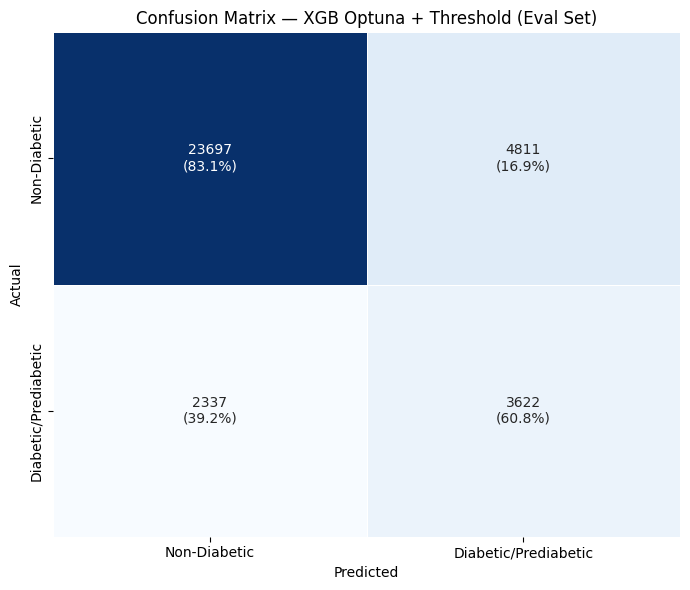

In [43]:
# ==========================
# XGB on Feature Set A with Optuna + Threshold Tuning (BINARY)
# XGB__featA__classweight__optuna_thresh_tuned
# 
# Procedure:
#   - Use the fitted xgb_featA_optuna model (Optuna-optimized)
#   - Get predicted probabilities on EVAL
#   - Sweep thresholds (0.05 → 0.95)
#   - Choose threshold that maximizes MCC
# ==========================

# Get probabilities from the Optuna-tuned XGB model (already fitted)
y_proba_xgb_optuna_pos = y_proba_xgb_optuna[:, 1]  # probability of class 1 (diabetic)

# Sweep thresholds and compute metrics
thresholds_to_try = np.arange(0.05, 0.96, 0.01)

threshold_results_xgb_optuna = []
for thresh in thresholds_to_try:
    y_pred_thresh = (y_proba_xgb_optuna_pos >= thresh).astype(int)
    
    # Compute key metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_eval, y_pred_thresh, labels=[0, 1], zero_division=0
    )
    
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_eval, y_pred_thresh)
    f1_diabetic = f1[1]
    sensitivity = recall[1]  # recall for diabetic class
    specificity = recall[0]  # recall for non-diabetic class
    ppv = precision[1]       # precision for diabetic class
    
    threshold_results_xgb_optuna.append({
        "threshold": thresh,
        "mcc": mcc,
        "balanced_accuracy": bal_acc,
        "f1_diabetic": f1_diabetic,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
    })

df_thresh_xgb_optuna = pd.DataFrame(threshold_results_xgb_optuna)

# Find optimal threshold (maximize MCC)
best_mcc_idx_optuna = df_thresh_xgb_optuna["mcc"].idxmax()
best_threshold_optuna = df_thresh_xgb_optuna.loc[best_mcc_idx_optuna, "threshold"]

print(f"Best threshold for Optuna-tuned XGB (max MCC): {best_threshold_optuna:.3f}")
print(f"MCC at best threshold: {df_thresh_xgb_optuna.loc[best_mcc_idx_optuna, 'mcc']:.4f}")

# Optional: Show threshold that maximizes F1-score for comparison
best_f1_idx = df_thresh_xgb_optuna["f1_diabetic"].idxmax()
best_f1_thresh = df_thresh_xgb_optuna.loc[best_f1_idx, "threshold"]
print(f"Threshold maximizing F1 (diabetic): {best_f1_thresh:.3f} (F1={df_thresh_xgb_optuna.loc[best_f1_idx, 'f1_diabetic']:.4f})")

# Apply best threshold and evaluate
y_pred_xgb_optuna_thresh_tuned = (y_proba_xgb_optuna_pos >= best_threshold_optuna).astype(int)

metrics_xgb_optuna_thresh = evaluate_binary_classifier(y_eval, y_pred_xgb_optuna_thresh_tuned, y_proba_xgb_optuna)
print("\nMetrics with tuned threshold (Optuna XGB):")
print(metrics_xgb_optuna_thresh)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_optuna_thresh_tuned))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_optuna_thresh_tuned, digits=3))

# Log experiment
log_experiment(
    exp_id="XGB__featA__classweight__optuna_thresh_tuned",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning="optuna+thresh",
    notes=f"Optuna-tuned XGBoost on Feature Set A with threshold={best_threshold_optuna:.2f} (maximizes MCC on eval set)",
    metrics=metrics_xgb_optuna_thresh,
    params={**study.best_params, "cv_pr_auc": study.best_value, "threshold": best_threshold_optuna}
)

results_df()

# ==========================
# Report-ready confusion matrix (counts + row %), XGB Optuna + threshold
# ==========================
class_names = ["Non-Diabetic", "Diabetic/Prediabetic"]

# Confusion matrix (counts)
cm_xgb_optuna = confusion_matrix(y_eval, y_pred_xgb_optuna_thresh_tuned, labels=[0, 1])
cm_xgb_optuna_df = pd.DataFrame(cm_xgb_optuna, index=class_names, columns=class_names)

# Row-normalized percentages
cm_xgb_optuna_row_pct = cm_xgb_optuna_df.div(cm_xgb_optuna_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_xgb_optuna_annot = cm_xgb_optuna_df.astype(int).astype(str) + "\n(" + cm_xgb_optuna_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_xgb_optuna_table = cm_xgb_optuna_df.copy()
for r in cm_xgb_optuna_table.index:
    for c in cm_xgb_optuna_table.columns:
        cm_xgb_optuna_table.loc[r, c] = f"{cm_xgb_optuna_df.loc[r, c]} ({cm_xgb_optuna_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_xgb_optuna_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_xgb_optuna_df,
    annot=cm_xgb_optuna_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — XGB Optuna + Threshold (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_xgb_optuna_thresh_eval.png")
plt.show()

**Calibration and final eval**

In [71]:
# ==========================
# CALIBRATION WORKFLOW FOR BINARY CLASSIFICATION
# Selection criterion: highest Recall (sensitivity) for diabetic class
# ==========================

# Compare calibration methods on EVAL set
print("="*60)
print("CALIBRATION METHOD COMPARISON (selecting by Recall)")
print("="*60)

# Pre-calibration baseline
y_proba_eval_pre = xgb_featA_optuna.predict_proba(X_eval_fe_A)[:, 1]
brier_pre = brier_score_loss(y_eval, y_proba_eval_pre)
logloss_pre = log_loss(y_eval, xgb_featA_optuna.predict_proba(X_eval_fe_A))
recall_pre = recall_score(y_eval, (y_proba_eval_pre >= 0.5).astype(int), pos_label=1)

# Sigmoid calibration (Platt scaling)
cal_sigmoid = CalibratedClassifierCV(
    estimator=clone(xgb_featA_optuna),
    method="sigmoid",
    cv=3
)
cal_sigmoid.fit(X_train_fe_A, y_train)
y_proba_eval_sigmoid = cal_sigmoid.predict_proba(X_eval_fe_A)[:, 1]
brier_sigmoid = brier_score_loss(y_eval, y_proba_eval_sigmoid)
logloss_sigmoid = log_loss(y_eval, cal_sigmoid.predict_proba(X_eval_fe_A))
recall_sigmoid = recall_score(y_eval, (y_proba_eval_sigmoid >= 0.5).astype(int), pos_label=1)

# Isotonic calibration
cal_isotonic = CalibratedClassifierCV(
    estimator=clone(xgb_featA_optuna),
    method="isotonic",
    cv=3
)
cal_isotonic.fit(X_train_fe_A, y_train)
y_proba_eval_isotonic = cal_isotonic.predict_proba(X_eval_fe_A)[:, 1]
brier_isotonic = brier_score_loss(y_eval, y_proba_eval_isotonic)
logloss_isotonic = log_loss(y_eval, cal_isotonic.predict_proba(X_eval_fe_A))
recall_isotonic = recall_score(y_eval, (y_proba_eval_isotonic >= 0.5).astype(int), pos_label=1)

# Comparison table — sorted by Recall (descending), then Brier (ascending) as tiebreak
calibration_comparison = pd.DataFrame({
    "Method": ["Uncalibrated", "Sigmoid (Platt)", "Isotonic"],
    "Recall (sensitivity)": [recall_pre, recall_sigmoid, recall_isotonic],
    "Brier Score": [brier_pre, brier_sigmoid, brier_isotonic],
    "Log Loss": [logloss_pre, logloss_sigmoid, logloss_isotonic]
}).sort_values(["Recall (sensitivity)", "Brier Score"], ascending=[False, True])

print("\n📋 CALIBRATION COMPARISON (sorted by Recall):")
display(calibration_comparison)

# Select best method (highest Recall, tiebreak by lowest Brier)
best_method = calibration_comparison.iloc[0]["Method"]
print(f"\n✅ Best calibration method (by Recall): {best_method}")

method_to_model = {
    "Uncalibrated": xgb_featA_optuna,
    "Sigmoid (Platt)": cal_sigmoid,
    "Isotonic": cal_isotonic
}
best_calibrated_model = method_to_model[best_method]
chosen_method = best_method

print(f"Selected model: {chosen_method}")

# Re-tune threshold on CALIBRATED probabilities
y_proba_cal_eval = best_calibrated_model.predict_proba(X_eval_fe_A)[:, 1]

threshold_results_cal = []
for thresh in np.arange(0.05, 0.96, 0.01):
    y_pred_thresh = (y_proba_cal_eval >= thresh).astype(int)
    mcc = matthews_corrcoef(y_eval, y_pred_thresh)
    threshold_results_cal.append({"threshold": thresh, "mcc": mcc})

df_thresh_cal = pd.DataFrame(threshold_results_cal)
best_threshold_final = df_thresh_cal.loc[df_thresh_cal["mcc"].idxmax(), "threshold"]

print(f"\n✅ Final threshold (on {chosen_method} model): {best_threshold_final:.3f}")

# Assign final model
final_model = (best_calibrated_model, best_threshold_final)
print(f"Final model: {type(final_model[0]).__name__} with threshold={best_threshold_final:.4f}")

CALIBRATION METHOD COMPARISON (selecting by Recall)

📋 CALIBRATION COMPARISON (sorted by Recall):


Method  Recall (sensitivity)  Brier Score  Log Loss
0     Uncalibrated              0.789394     0.181238  0.529193
1  Sigmoid (Platt)              0.239302     0.116237  0.372172
2         Isotonic              0.177379     0.114696  0.363386


✅ Best calibration method (by Recall): Uncalibrated
Selected model: Uncalibrated

✅ Final threshold (on Uncalibrated model): 0.640
Final model: Pipeline with threshold=0.6400


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/calibration_curve_comparison.png


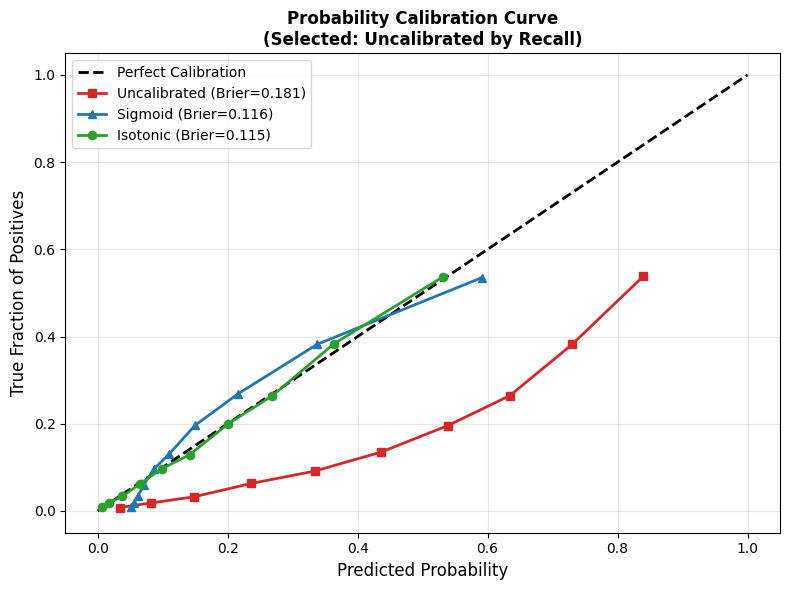

✅ Calibration curve saved (selected method: Uncalibrated)


In [73]:
# ==========================
# Calibration Curve (Before/After) — All 3 methods
# ==========================

# Bin probabilities into 10 quantiles
prob_true_uncal, prob_pred_uncal = calibration_curve(
    y_eval, y_proba_eval_pre, n_bins=10, strategy='quantile'
)
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(
    y_eval, y_proba_eval_sigmoid, n_bins=10, strategy='quantile'
)
prob_true_isotonic, prob_pred_isotonic = calibration_curve(
    y_eval, y_proba_eval_isotonic, n_bins=10, strategy='quantile'
)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
plt.plot(prob_pred_uncal, prob_true_uncal, 's-', lw=2, 
         label=f'Uncalibrated (Brier={brier_pre:.3f})', color='#d62728')
plt.plot(prob_pred_sigmoid, prob_true_sigmoid, '^-', lw=2, 
         label=f'Sigmoid (Brier={brier_sigmoid:.3f})', color='#1f77b4')
plt.plot(prob_pred_isotonic, prob_true_isotonic, 'o-', lw=2, 
         label=f'Isotonic (Brier={brier_isotonic:.3f})', color='#2ca02c')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('True Fraction of Positives', fontsize=12)
plt.title(f'Probability Calibration Curve\n(Selected: {chosen_method} by Recall)', fontweight='bold')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
savefig("calibration_curve_comparison.png")
plt.show()

print(f"✅ Calibration curve saved (selected method: {chosen_method})")

FINAL MODEL EVALUATION — HELD-OUT TEST SET
Using: Uncalibrated-calibrated XGBoost with threshold = 0.640

📊 TEST SET METRICS:
   Brier Score: 0.1796
   Log Loss: 0.5248
   Accuracy: 0.7910
   Balanced Accuracy: 0.7097
   F1 (diabetic): 0.4920
   Sensitivity (recall): 0.5855
   Specificity: 0.8339
   PPV (precision): 0.4243
   NPV: 0.9059
   MCC: 0.3721
   ROC-AUC: 0.8124
   PR-AUC: 0.4762

📋 CONFUSION MATRIX (TEST SET):
[[23775  4734]
 [ 2470  3489]]

Breakdown:
  True Negatives (TN):  23,775
  False Positives (FP): 4,734
  False Negatives (FN): 2,470
  True Positives (TP):  3,489
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_test.png


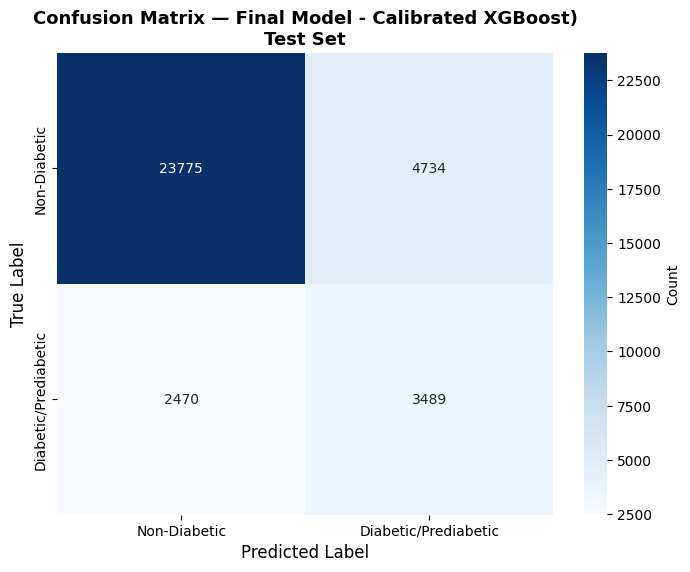


📝 CLASSIFICATION REPORT (TEST SET):
                      precision    recall  f1-score   support

        Non-Diabetic     0.9059    0.8339    0.8684     28509
Diabetic/Prediabetic     0.4243    0.5855    0.4920      5959

            accuracy                         0.7910     34468
           macro avg     0.6651    0.7097    0.6802     34468
        weighted avg     0.8226    0.7910    0.8034     34468


✅ Final model evaluation complete
✅ Test set size: 34,468 samples
✅ Model: Pipeline (Uncalibrated) with threshold=0.6400


In [75]:
# ==========================
# Final Model Evaluation on TEST Set
# ==========================

print("="*60)
print("FINAL MODEL EVALUATION — HELD-OUT TEST SET")
print("="*60)

# Unpack final model (using calibrated model from calibration cell)
model_pipeline, threshold = final_model

print(f"Using: {chosen_method}-calibrated XGBoost with threshold = {threshold:.3f}")
print("="*60)

# 1) Get predictions on TEST set
y_proba_test = model_pipeline.predict_proba(X_test_fe_A)[:, 1]
y_pred_test = (y_proba_test >= threshold).astype(int)

# 2) Compute comprehensive metrics
metrics_test = evaluate_binary_classifier(y_test, y_pred_test, model_pipeline.predict_proba(X_test_fe_A))

print("\n📊 TEST SET METRICS:")
print(f"   Brier Score: {metrics_test['brier_score']:.4f}")
print(f"   Log Loss: {metrics_test['log_loss']:.4f}")
print(f"   Accuracy: {metrics_test['accuracy']:.4f}")
print(f"   Balanced Accuracy: {metrics_test['balanced_accuracy']:.4f}")
print(f"   F1 (diabetic): {metrics_test['f1_class_1 (diabetic)']:.4f}")
print(f"   Sensitivity (recall): {metrics_test['recall_class_1 (sensitivity)']:.4f}")
print(f"   Specificity: {metrics_test['recall_class_0 (specificity)']:.4f}")
print(f"   PPV (precision): {metrics_test['precision_class_1 (PPV)']:.4f}")
print(f"   NPV: {metrics_test['precision_class_0 (NPV)']:.4f}")
print(f"   MCC: {metrics_test['mcc']:.4f}")
print(f"   ROC-AUC: {metrics_test['roc_auc']:.4f}")
print(f"   PR-AUC: {metrics_test['pr_auc']:.4f}")

# 3) Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\n📋 CONFUSION MATRIX (TEST SET):")
print(cm)

# Calculate per-class counts for annotation
tn, fp, fn, tp = cm.ravel()
print(f"\nBreakdown:")
print(f"  True Negatives (TN):  {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives (TP):  {tp:,}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Diabetic', 'Diabetic/Prediabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic/Prediabetic'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Confusion Matrix — Final Model - Calibrated XGBoost)\nTest Set', 
          fontweight='bold', fontsize=13)
savefig("confusion_matrix_test.png")
plt.show()

# 4) Classification Report
print("\n📝 CLASSIFICATION REPORT (TEST SET):")
print(classification_report(y_test, y_pred_test, 
                           target_names=['Non-Diabetic', 'Diabetic/Prediabetic'], 
                           digits=4))

# 5) Determine calibration method label for logging
cal_method_label = chosen_method.lower().replace(" (platt)", "").replace(" ", "_")

# 6) Log final test metrics to experiment tracker
log_experiment(
    exp_id=f"XGB__featA__classweight__optuna_{cal_method_label}_final",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning=f"optuna+{cal_method_label}+thresh",
    notes=f"FINAL TEST SET: {chosen_method}-calibrated XGBoost with threshold={threshold:.3f}",
    metrics=metrics_test,
    params={
        **study.best_params,
        "calibration": cal_method_label,
        "threshold": threshold,
        "cv_pr_auc": study.best_value
    }
)

print("\n✅ Final model evaluation complete")
print(f"✅ Test set size: {len(y_test):,} samples")
print(f"✅ Model: {type(model_pipeline).__name__} ({chosen_method}) with threshold={threshold:.4f}")

FINAL MODEL — UNCALIBRATED OPTUNA XGBOOST (BEST RECALL)
Optimal threshold (max MCC on eval): 0.640

📊 TEST SET METRICS (Uncalibrated):
   Brier Score:          0.1796
   Log Loss:             0.5248
   Accuracy:             0.7910
   Balanced Accuracy:    0.7097
   F1 (diabetic):        0.4920
   Sensitivity (recall): 0.5855
   Specificity:          0.8339
   PPV (precision):      0.4243
   NPV:                  0.9059
   MCC:                  0.3721
   ROC-AUC:              0.8124
   PR-AUC:               0.4762

📋 CONFUSION MATRIX (counts + row %):


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          23,775 (83.4%)        4,734 (16.6%)
Diabetic/Prediabetic   2,470 (41.4%)        3,489 (58.6%)


  TN: 23,775  |  FP: 4,734
  FN: 2,470  |  TP: 3,489
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_test_uncalibrated.png


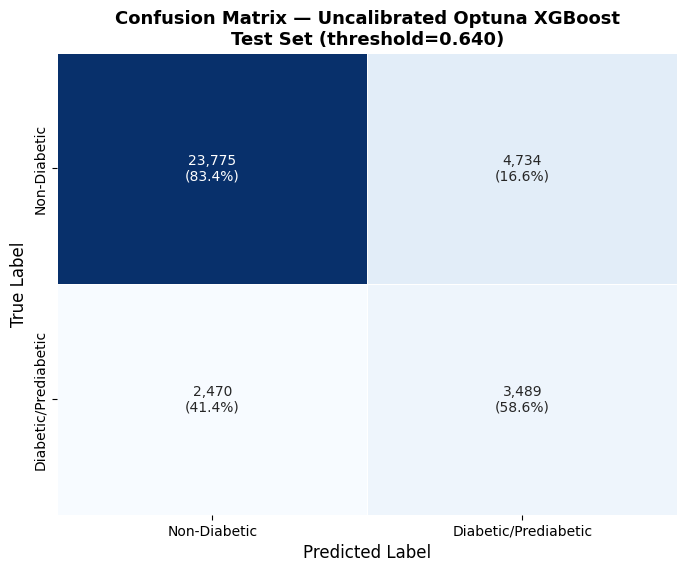


📝 CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

        Non-Diabetic     0.9059    0.8339    0.8684     28509
Diabetic/Prediabetic     0.4243    0.5855    0.4920      5959

            accuracy                         0.7910     34468
           macro avg     0.6651    0.7097    0.6802     34468
        weighted avg     0.8226    0.7910    0.8034     34468


✅ Uncalibrated model evaluation complete (threshold=0.640)


In [80]:
# ==========================
# Final Model Evaluation — UNCALIBRATED Optuna XGBoost (Best Recall)
# ==========================

print("="*60)
print("FINAL MODEL — UNCALIBRATED OPTUNA XGBOOST (BEST RECALL)")
print("="*60)

# Use the uncalibrated Optuna-tuned XGBoost pipeline
uncal_model = xgb_featA_optuna

# Re-tune threshold on uncalibrated probabilities (EVAL set)
y_proba_uncal_eval = uncal_model.predict_proba(X_eval_fe_A)[:, 1]

thresh_results_uncal = []
for t in np.arange(0.05, 0.96, 0.01):
    yp = (y_proba_uncal_eval >= t).astype(int)
    thresh_results_uncal.append({
        "threshold": t,
        "mcc": matthews_corrcoef(y_eval, yp)
    })
df_t_uncal = pd.DataFrame(thresh_results_uncal)
thresh_uncal = df_t_uncal.loc[df_t_uncal["mcc"].idxmax(), "threshold"]

print(f"Optimal threshold (max MCC on eval): {thresh_uncal:.3f}")

# ---------- TEST SET ----------
y_proba_test_uncal = uncal_model.predict_proba(X_test_fe_A)[:, 1]
y_pred_test_uncal = (y_proba_test_uncal >= thresh_uncal).astype(int)

metrics_uncal = evaluate_binary_classifier(
    y_test, y_pred_test_uncal, uncal_model.predict_proba(X_test_fe_A)
)

print("\n📊 TEST SET METRICS (Uncalibrated):")
print(f"   Brier Score:          {metrics_uncal['brier_score']:.4f}")
print(f"   Log Loss:             {metrics_uncal['log_loss']:.4f}")
print(f"   Accuracy:             {metrics_uncal['accuracy']:.4f}")
print(f"   Balanced Accuracy:    {metrics_uncal['balanced_accuracy']:.4f}")
print(f"   F1 (diabetic):        {metrics_uncal['f1_class_1 (diabetic)']:.4f}")
print(f"   Sensitivity (recall): {metrics_uncal['recall_class_1 (sensitivity)']:.4f}")
print(f"   Specificity:          {metrics_uncal['recall_class_0 (specificity)']:.4f}")
print(f"   PPV (precision):      {metrics_uncal['precision_class_1 (PPV)']:.4f}")
print(f"   NPV:                  {metrics_uncal['precision_class_0 (NPV)']:.4f}")
print(f"   MCC:                  {metrics_uncal['mcc']:.4f}")
print(f"   ROC-AUC:              {metrics_uncal['roc_auc']:.4f}")
print(f"   PR-AUC:               {metrics_uncal['pr_auc']:.4f}")

# Confusion matrix with counts + row %
cm_uncal = confusion_matrix(y_test, y_pred_test_uncal)
tn, fp, fn, tp = cm_uncal.ravel()

class_names = ["Non-Diabetic", "Diabetic/Prediabetic"]
cm_uncal_df = pd.DataFrame(cm_uncal, index=class_names, columns=class_names)
cm_uncal_pct = cm_uncal_df.div(cm_uncal_df.sum(axis=1), axis=0) * 100

cm_uncal_annot = cm_uncal_df.copy().astype(str)
for r in class_names:
    for c in class_names:
        cm_uncal_annot.loc[r, c] = f"{cm_uncal_df.loc[r, c]:,}\n({cm_uncal_pct.loc[r, c]:.1f}%)"

cm_uncal_table = cm_uncal_df.copy().astype(str)
for r in class_names:
    for c in class_names:
        cm_uncal_table.loc[r, c] = f"{cm_uncal_df.loc[r, c]:,} ({cm_uncal_pct.loc[r, c]:.1f}%)"

print("\n📋 CONFUSION MATRIX (counts + row %):")
display(cm_uncal_table)

print(f"\n  TN: {tn:,}  |  FP: {fp:,}")
print(f"  FN: {fn:,}  |  TP: {tp:,}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_uncal_df, annot=cm_uncal_annot, fmt='', cmap='Blues',
            cbar=False, linewidths=0.5, linecolor='white',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Confusion Matrix — Uncalibrated Optuna XGBoost\nTest Set (threshold={thresh_uncal:.3f})',
          fontweight='bold', fontsize=13)
savefig("confusion_matrix_test_uncalibrated.png")
plt.show()

print("\n📝 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_test_uncal,
                           target_names=class_names, digits=4))

log_experiment(
    exp_id="XGB__featA__classweight__optuna_uncalibrated_final",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning="optuna+uncalibrated+thresh",
    notes=f"FINAL TEST: Uncalibrated Optuna XGBoost, threshold={thresh_uncal:.3f}",
    metrics=metrics_uncal,
    params={**study.best_params, "calibration": "uncalibrated", "threshold": thresh_uncal}
)

print(f"\n✅ Uncalibrated model evaluation complete (threshold={thresh_uncal:.3f})")

FINAL MODEL — CALIBRATED OPTUNA XGBOOST

📋 Calibrated model comparison (EVAL set):


Method     Brier  Log Loss  Best MCC  Threshold    Recall
1         Isotonic  0.114696  0.363386  0.385807       0.27  0.611344
0  Sigmoid (Platt)  0.116237  0.372172  0.385451       0.23  0.588522


✅ Selected calibrated model: Isotonic
✅ Threshold (max MCC on eval): 0.270

📊 TEST SET METRICS (Isotonic Calibrated):
   Brier Score:          0.1148
   Log Loss:             0.3645
   Accuracy:             0.7895
   Balanced Accuracy:    0.7122
   F1 (diabetic):        0.4939
   Sensitivity (recall): 0.5941
   Specificity:          0.8304
   PPV (precision):      0.4227
   NPV:                  0.9073
   MCC:                  0.3743
   ROC-AUC:              0.8118
   PR-AUC:               0.4741

📋 CONFUSION MATRIX (counts + row %):


Non-Diabetic Diabetic/Prediabetic
Non-Diabetic          23,674 (83.0%)        4,835 (17.0%)
Diabetic/Prediabetic   2,419 (40.6%)        3,540 (59.4%)


  TN: 23,674  |  FP: 4,835
  FN: 2,419  |  TP: 3,540
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/confusion_matrix_test_isotonic_calibrated.png


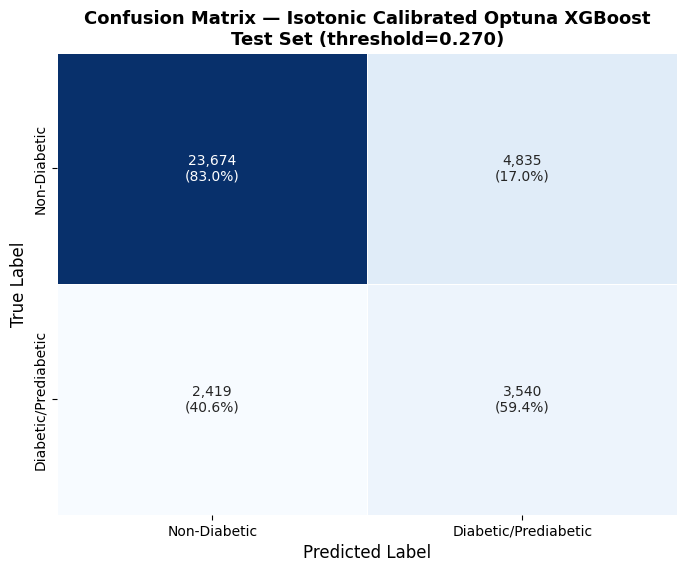


📝 CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

        Non-Diabetic     0.9073    0.8304    0.8671     28509
Diabetic/Prediabetic     0.4227    0.5941    0.4939      5959

            accuracy                         0.7895     34468
           macro avg     0.6650    0.7122    0.6805     34468
        weighted avg     0.8235    0.7895    0.8026     34468


🏆 FINAL MODEL: Isotonic Calibrated (better MCC on test)
✅ final_model set for downstream cells (SHAP, LIME, permutation importance)
✅ Model: CalibratedClassifierCV, threshold=0.2700


In [81]:
# ==========================
# Final Model Evaluation — CALIBRATED Optuna XGBoost
# Compares Sigmoid vs Isotonic, picks the one with better Brier Score
# ==========================

print("="*60)
print("FINAL MODEL — CALIBRATED OPTUNA XGBOOST")
print("="*60)

# --- Evaluate BOTH calibrated models on EVAL to pick the best ---
cal_candidates = {
    "Sigmoid (Platt)": cal_sigmoid,
    "Isotonic": cal_isotonic
}

cal_eval_results = []
for name, model in cal_candidates.items():
    p1 = model.predict_proba(X_eval_fe_A)[:, 1]
    brier = brier_score_loss(y_eval, p1)
    ll = log_loss(y_eval, model.predict_proba(X_eval_fe_A))
    
    # Find best threshold by MCC
    best_mcc, best_t = -1, 0.5
    for t in np.arange(0.05, 0.96, 0.01):
        m = matthews_corrcoef(y_eval, (p1 >= t).astype(int))
        if m > best_mcc:
            best_mcc, best_t = m, t
    
    recall_at_thresh = recall_score(y_eval, (p1 >= best_t).astype(int), pos_label=1)
    
    cal_eval_results.append({
        "Method": name, "Brier": brier, "Log Loss": ll,
        "Best MCC": best_mcc, "Threshold": best_t, "Recall": recall_at_thresh
    })

df_cal_eval = pd.DataFrame(cal_eval_results).sort_values("Brier", ascending=True)
print("\n📋 Calibrated model comparison (EVAL set):")
display(df_cal_eval)

# Pick the calibrated model with the lowest Brier score
best_cal_name = df_cal_eval.iloc[0]["Method"]
best_cal_thresh = df_cal_eval.iloc[0]["Threshold"]
best_cal_model = cal_candidates[best_cal_name]

print(f"\n✅ Selected calibrated model: {best_cal_name}")
print(f"✅ Threshold (max MCC on eval): {best_cal_thresh:.3f}")

# ---------- TEST SET ----------
y_proba_test_cal = best_cal_model.predict_proba(X_test_fe_A)[:, 1]
y_pred_test_cal = (y_proba_test_cal >= best_cal_thresh).astype(int)

metrics_cal = evaluate_binary_classifier(
    y_test, y_pred_test_cal, best_cal_model.predict_proba(X_test_fe_A)
)

print(f"\n📊 TEST SET METRICS ({best_cal_name} Calibrated):")
print(f"   Brier Score:          {metrics_cal['brier_score']:.4f}")
print(f"   Log Loss:             {metrics_cal['log_loss']:.4f}")
print(f"   Accuracy:             {metrics_cal['accuracy']:.4f}")
print(f"   Balanced Accuracy:    {metrics_cal['balanced_accuracy']:.4f}")
print(f"   F1 (diabetic):        {metrics_cal['f1_class_1 (diabetic)']:.4f}")
print(f"   Sensitivity (recall): {metrics_cal['recall_class_1 (sensitivity)']:.4f}")
print(f"   Specificity:          {metrics_cal['recall_class_0 (specificity)']:.4f}")
print(f"   PPV (precision):      {metrics_cal['precision_class_1 (PPV)']:.4f}")
print(f"   NPV:                  {metrics_cal['precision_class_0 (NPV)']:.4f}")
print(f"   MCC:                  {metrics_cal['mcc']:.4f}")
print(f"   ROC-AUC:              {metrics_cal['roc_auc']:.4f}")
print(f"   PR-AUC:               {metrics_cal['pr_auc']:.4f}")

# Confusion matrix with counts + row %
cm_cal = confusion_matrix(y_test, y_pred_test_cal)
tn, fp, fn, tp = cm_cal.ravel()

class_names = ["Non-Diabetic", "Diabetic/Prediabetic"]
cm_cal_df = pd.DataFrame(cm_cal, index=class_names, columns=class_names)
cm_cal_pct = cm_cal_df.div(cm_cal_df.sum(axis=1), axis=0) * 100

cm_cal_annot = cm_cal_df.copy().astype(str)
for r in class_names:
    for c in class_names:
        cm_cal_annot.loc[r, c] = f"{cm_cal_df.loc[r, c]:,}\n({cm_cal_pct.loc[r, c]:.1f}%)"

cm_cal_table = cm_cal_df.copy().astype(str)
for r in class_names:
    for c in class_names:
        cm_cal_table.loc[r, c] = f"{cm_cal_df.loc[r, c]:,} ({cm_cal_pct.loc[r, c]:.1f}%)"

print("\n📋 CONFUSION MATRIX (counts + row %):")
display(cm_cal_table)

print(f"\n  TN: {tn:,}  |  FP: {fp:,}")
print(f"  FN: {fn:,}  |  TP: {tp:,}")

cal_label_short = best_cal_name.split(" ")[0].lower()  # "sigmoid" or "isotonic"

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cal_df, annot=cm_cal_annot, fmt='', cmap='Blues',
            cbar=False, linewidths=0.5, linecolor='white',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Confusion Matrix — {best_cal_name} Calibrated Optuna XGBoost\nTest Set (threshold={best_cal_thresh:.3f})',
          fontweight='bold', fontsize=13)
savefig(f"confusion_matrix_test_{cal_label_short}_calibrated.png")
plt.show()

print("\n📝 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_test_cal,
                           target_names=class_names, digits=4))

log_experiment(
    exp_id=f"XGB__featA__classweight__optuna_{cal_label_short}_final",
    model_family="XGB",
    features="featA",
    sampling="classweight",
    tuning=f"optuna+{cal_label_short}+thresh",
    notes=f"FINAL TEST: {best_cal_name} calibrated Optuna XGBoost, threshold={best_cal_thresh:.3f}",
    metrics=metrics_cal,
    params={**study.best_params, "calibration": cal_label_short, "threshold": best_cal_thresh}
)

# --- Set final_model for downstream cells (SHAP, LIME, etc.) ---
# Pick whichever has better MCC on test
if metrics_cal['mcc'] >= metrics_uncal['mcc']:
    final_model = (best_cal_model, best_cal_thresh)
    chosen_method = best_cal_name
    print(f"\n🏆 FINAL MODEL: {best_cal_name} Calibrated (better MCC on test)")
else:
    final_model = (uncal_model, thresh_uncal)
    chosen_method = "Uncalibrated"
    print(f"\n🏆 FINAL MODEL: Uncalibrated (better MCC on test)")

print(f"✅ final_model set for downstream cells (SHAP, LIME, permutation importance)")
print(f"✅ Model: {type(final_model[0]).__name__}, threshold={final_model[1]:.4f}")

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/roc_pr_curves_test.png


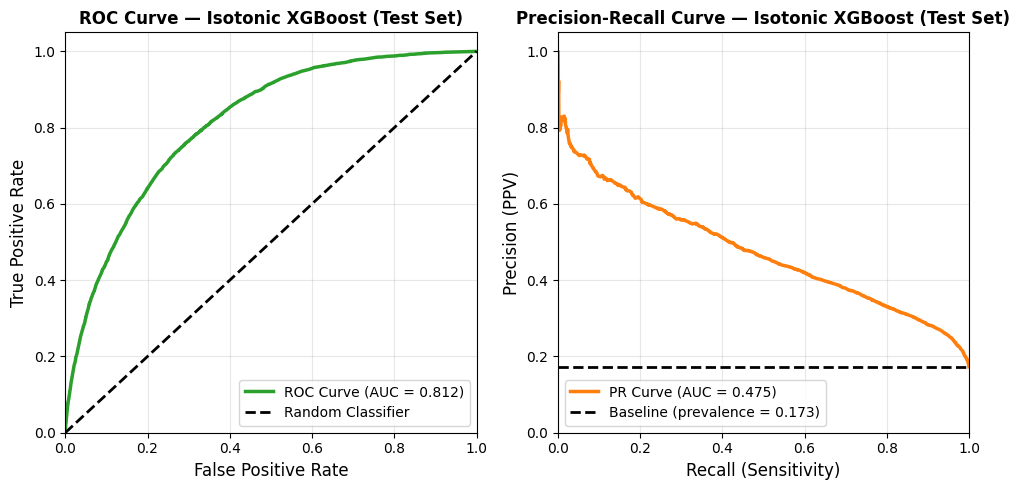

✅ Test set ROC-AUC: 0.8118
✅ Test set PR-AUC: 0.4749
✅ Model used: Isotonic (threshold=0.270)


In [82]:
# ==========================
# ROC and Precision-Recall Curves (TEST SET)
# ==========================

# Use the ACTUAL final model (consistent with SHAP/LIME/permutation importance)
model_pipeline_final, threshold_final = final_model
y_proba_test_final = model_pipeline_final.predict_proba(X_test_fe_A)[:, 1]

# 1) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test_final)
roc_auc_test = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='#2ca02c', lw=2.5, 
         label=f'ROC Curve (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve — {chosen_method} XGBoost (Test Set)', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 2) Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_test_final)
pr_auc_test = auc(recall_curve, precision_curve)

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='#ff7f0e', lw=2.5,
         label=f'PR Curve (AUC = {pr_auc_test:.3f})')
plt.axhline(y=y_test.mean(), color='k', linestyle='--', lw=2, 
            label=f'Baseline (prevalence = {y_test.mean():.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (PPV)', fontsize=12)
plt.title(f'Precision-Recall Curve — {chosen_method} XGBoost (Test Set)', fontweight='bold')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()
savefig("roc_pr_curves_test.png")
plt.show()

print(f"✅ Test set ROC-AUC: {roc_auc_test:.4f}")
print(f"✅ Test set PR-AUC: {pr_auc_test:.4f}")
print(f"✅ Model used: {chosen_method} (threshold={threshold_final:.3f})")

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/mcc_vs_threshold_final.png


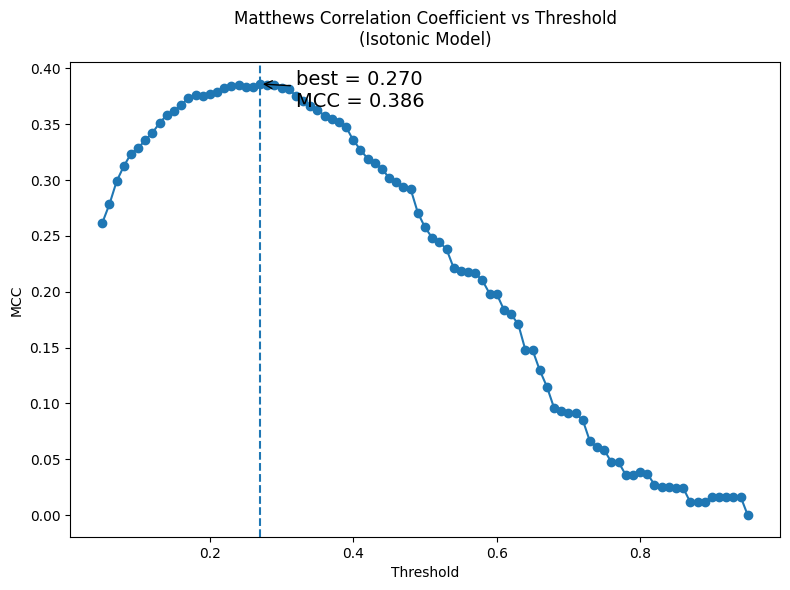

✅ MCC plot uses: Isotonic (threshold=0.270, MCC=0.386)


In [83]:
# MCC vs Threshold plot — using the ACTUAL final model
model_pipeline_final, threshold_final = final_model
y_proba_final_eval = model_pipeline_final.predict_proba(X_eval_fe_A)[:, 1]

# Recompute MCC sweep on eval set for the final model
threshold_results_final = []
for thresh in np.arange(0.05, 0.96, 0.01):
    y_pred_t = (y_proba_final_eval >= thresh).astype(int)
    mcc = matthews_corrcoef(y_eval, y_pred_t)
    threshold_results_final.append({"threshold": thresh, "mcc": mcc})

df_thresh_final = pd.DataFrame(threshold_results_final)
thresholds = df_thresh_final["threshold"].values
mcc_vals = df_thresh_final["mcc"].values

# Find MCC at the optimal threshold
mcc_best = df_thresh_final.loc[
    (df_thresh_final["threshold"] - threshold_final).abs().idxmin(), "mcc"
]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, mcc_vals, marker="o")
plt.axvline(threshold_final, linestyle="--")
plt.annotate(
    f"best = {threshold_final:.3f}\nMCC = {mcc_best:.3f}",
    xy=(threshold_final, mcc_best),
    xytext=(threshold_final + 0.05, mcc_best - 0.02),
    textcoords="data",
    size=14,
    arrowprops=dict(arrowstyle="->", color="black")
)

plt.xlabel("Threshold")
plt.ylabel("MCC")
plt.title(f"Matthews Correlation Coefficient vs Threshold\n({chosen_method} Model)", y=1.02)
plt.tight_layout()
savefig("mcc_vs_threshold_final.png")
plt.show()

print(f"✅ MCC plot uses: {chosen_method} (threshold={threshold_final:.3f}, MCC={mcc_best:.3f})")

**Explainability**

**Permutation Importance and XGB gain + comparison**

PERMUTATION FEATURE IMPORTANCE

⏳ Computing permutation importance (this may take a few minutes)...
✅ Permutation importance computed

TOP 15 FEATURES (Permutation Importance - MCC)
             feature  importance_mcc_mean  importance_mcc_std  importance_roc_mean  importance_roc_std  importance_f1_mean  importance_f1_std
                 BMI             0.094961            0.005893             0.041611            0.001182            0.103163           0.004813
             GenHlth             0.085268            0.005597             0.046212            0.001280            0.108570           0.004578
          Age_HighBP             0.047877            0.004521             0.012958            0.000651            0.080936           0.004082
            HighChol             0.035841            0.003550             0.008444            0.000602            0.053399           0.002969
     RiskFactorCount             0.035157            0.002920             0.005279            0.000413      

PERMUTATION FEATURE IMPORTANCE

⏳ Computing permutation importance (this may take a few minutes)...
✅ Permutation importance computed

TOP 15 FEATURES (Permutation Importance - MCC)
             feature  importance_mcc_mean  importance_mcc_std  importance_roc_mean  importance_roc_std  importance_f1_mean  importance_f1_std
                 BMI             0.094961            0.005893             0.041611            0.001182            0.103163           0.004813
             GenHlth             0.085268            0.005597             0.046212            0.001280            0.108570           0.004578
          Age_HighBP             0.047877            0.004521             0.012958            0.000651            0.080936           0.004082
            HighChol             0.035841            0.003550             0.008444            0.000602            0.053399           0.002969
     RiskFactorCount             0.035157            0.002920             0.005279            0.000413      

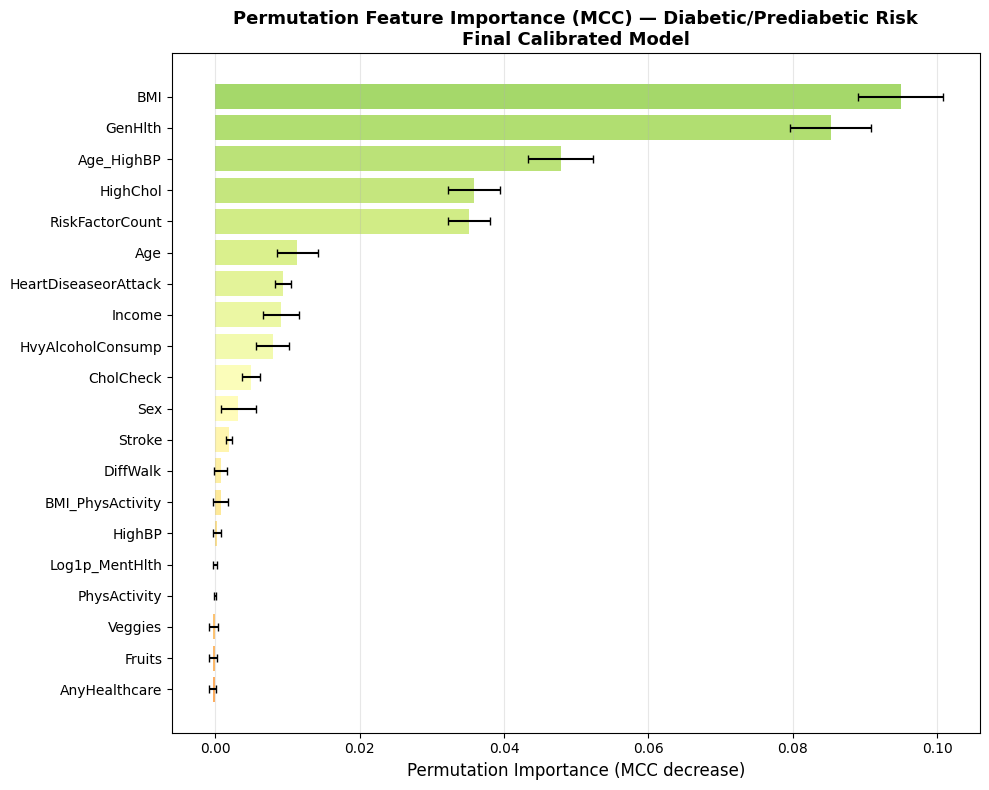

PERMUTATION FEATURE IMPORTANCE

⏳ Computing permutation importance (this may take a few minutes)...
✅ Permutation importance computed

TOP 15 FEATURES (Permutation Importance - MCC)
             feature  importance_mcc_mean  importance_mcc_std  importance_roc_mean  importance_roc_std  importance_f1_mean  importance_f1_std
                 BMI             0.094961            0.005893             0.041611            0.001182            0.103163           0.004813
             GenHlth             0.085268            0.005597             0.046212            0.001280            0.108570           0.004578
          Age_HighBP             0.047877            0.004521             0.012958            0.000651            0.080936           0.004082
            HighChol             0.035841            0.003550             0.008444            0.000602            0.053399           0.002969
     RiskFactorCount             0.035157            0.002920             0.005279            0.000413      

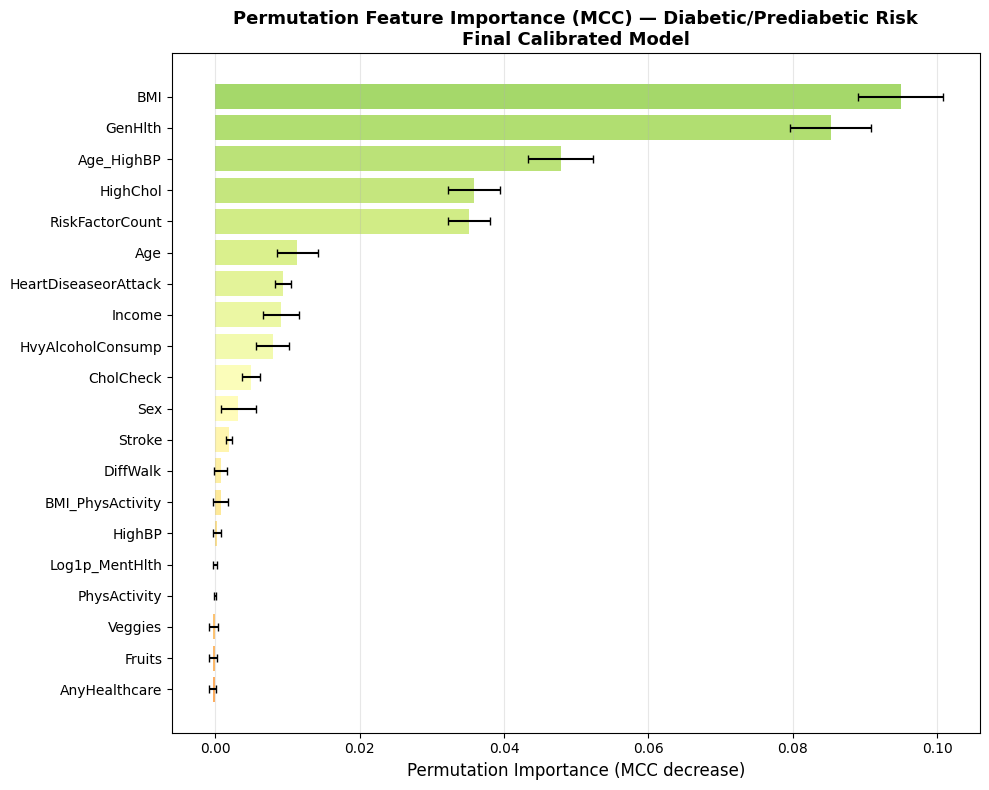

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/permutation_importance_comparison_binary.png


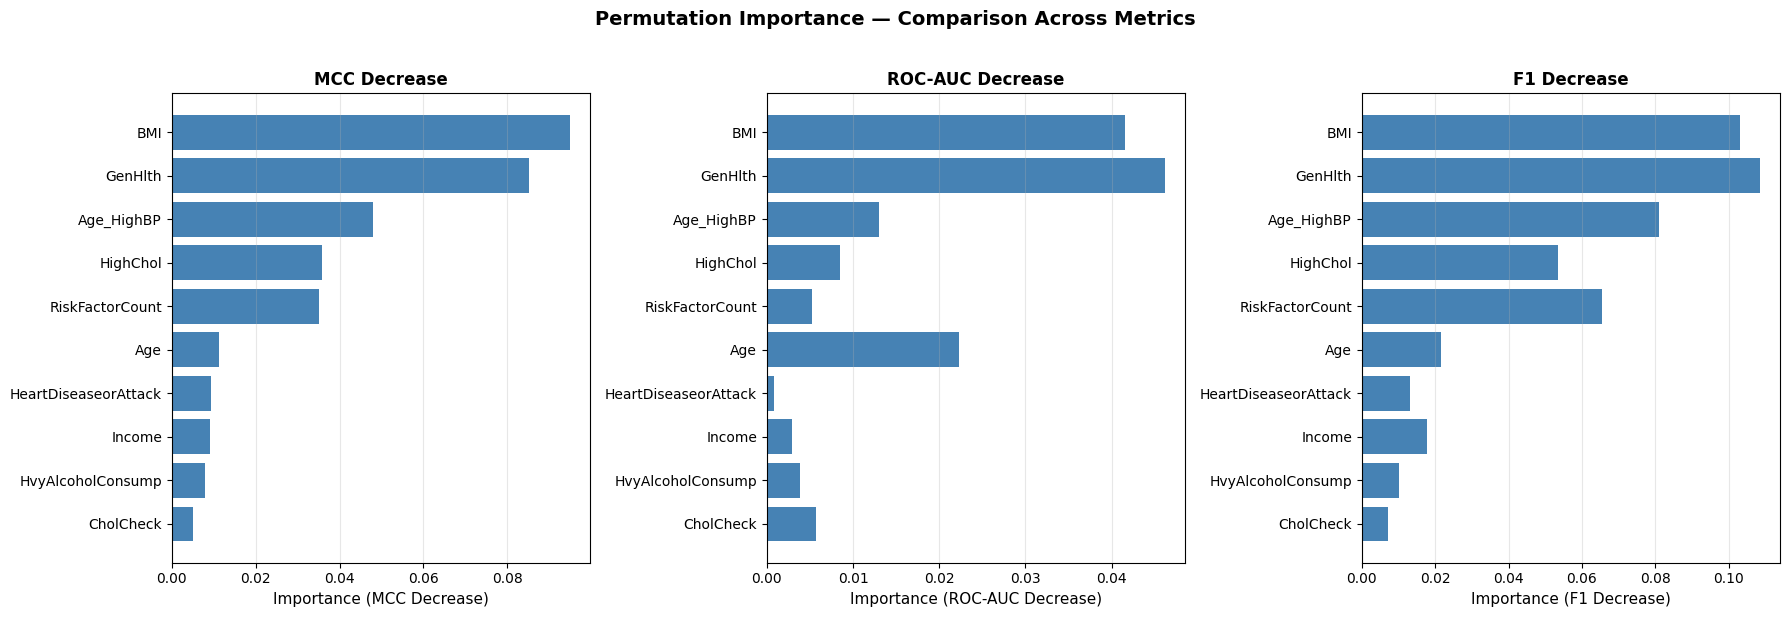


✅ Permutation importance analysis complete


In [64]:
# ==========================
# Permutation Feature Importance (BINARY)
# Goal:
#   - Compute permutation importance on EVAL set
#   - Use the FINAL CALIBRATED model
#   - Score using multiple metrics (MCC, F1, ROC-AUC)
#   - Create visualizations comparing to XGBoost built-in importance
# ==========================

from sklearn.inspection import permutation_importance

print("="*60)
print("PERMUTATION FEATURE IMPORTANCE")
print("="*60)

# 1) Use the FINAL calibrated model (isotonic-calibrated XGBoost)
model_pipeline, threshold = final_model

# 2) Compute permutation importance on EVAL set
# We'll use multiple scoring metrics to get a comprehensive view
print("\n⏳ Computing permutation importance (this may take a few minutes)...")

# MCC (Matthews Correlation Coefficient) - robust for imbalanced data
perm_importance_mcc = permutation_importance(
    model_pipeline, 
    X_eval_fe_A, 
    y_eval,
    scoring='matthews_corrcoef',
    n_repeats=30,  # Repeat shuffling 30 times for stability
    random_state=42,
    n_jobs=-1
)

# ROC-AUC (probability-based metric)
perm_importance_roc = permutation_importance(
    model_pipeline, 
    X_eval_fe_A, 
    y_eval,
    scoring='roc_auc',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# F1-score (diabetic class)
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label=1)

perm_importance_f1 = permutation_importance(
    model_pipeline, 
    X_eval_fe_A, 
    y_eval,
    scoring=f1_scorer,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

print("✅ Permutation importance computed")

# 3) Get feature names from the pipeline
# These are the ORIGINAL feature names (before preprocessing)
feature_names_orig = X_eval_fe_A.columns.tolist()

# 4) Create comprehensive results dataframe
perm_results = pd.DataFrame({
    'feature': feature_names_orig,
    'importance_mcc_mean': perm_importance_mcc.importances_mean,
    'importance_mcc_std': perm_importance_mcc.importances_std,
    'importance_roc_mean': perm_importance_roc.importances_mean,
    'importance_roc_std': perm_importance_roc.importances_std,
    'importance_f1_mean': perm_importance_f1.importances_mean,
    'importance_f1_std': perm_importance_f1.importances_std,
}).sort_values('importance_mcc_mean', ascending=False)

# 5) Display top features
print("\n" + "="*60)
print("TOP 15 FEATURES (Permutation Importance - MCC)")
print("="*60)
print(perm_results.head(15).to_string(index=False))

# 6) Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total features: {len(feature_names_orig)}")
print(f"Top feature (MCC): {perm_results.iloc[0]['feature']}")
print(f"Top importance (MCC): {perm_results.iloc[0]['importance_mcc_mean']:.4f} ± {perm_results.iloc[0]['importance_mcc_std']:.4f}")
print(f"Mean importance (MCC): {perm_results['importance_mcc_mean'].mean():.4f}")
print(f"Features with importance > 0.001: {(perm_results['importance_mcc_mean'] > 0.001).sum()}")

# 7) Check engineered features
engineered_feats = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]
top10_feats = set(perm_results.head(10)["feature"])
engineered_in_top10 = [f for f in engineered_feats if f in top10_feats]

print(f"\n✅ Engineered features in top 10: {len(engineered_in_top10)}")
if engineered_in_top10:
    print(f"   Features: {engineered_in_top10}")

# 8) Plot permutation importance (MCC)
plt.figure(figsize=(10, 8))
top_features = perm_results.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, 20))

plt.barh(
    range(len(top_features)),
    top_features['importance_mcc_mean'].values[::-1],
    xerr=top_features['importance_mcc_std'].values[::-1],
    color=colors[::-1],
    capsize=3
)
plt.yticks(range(len(top_features)), top_features['feature'].values[::-1])
plt.xlabel('Permutation Importance (MCC decrease)', fontsize=12)
plt.title('Permutation Feature Importance (MCC) — Diabetic/Prediabetic Risk\nFinal Calibrated Model', 
          fontweight='bold', fontsize=13)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
savefig("permutation_importance_mcc_binary.png")
plt.show()

# 9) Plot comparison across metrics (top 10 features)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
top10 = perm_results.head(10)

for ax, metric, title in zip(
    axes, 
    ['importance_mcc_mean', 'importance_roc_mean', 'importance_f1_mean'],
    ['MCC Decrease', 'ROC-AUC Decrease', 'F1 Decrease']
):
    ax.barh(range(10), top10[metric].values[::-1], color='steelblue')
    ax.set_yticks(range(10))
    ax.set_yticklabels(top10['feature'].values[::-1])
    ax.set_xlabel(f'Importance ({title})', fontsize=11)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Permutation Importance — Comparison Across Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
savefig("permutation_importance_comparison_binary.png")
plt.show()

print("\n✅ Permutation importance analysis complete")

XGBOOST BUILT-IN FEATURE IMPORTANCE

TOP 15 FEATURES (XGBoost Built-in Importance)
                  feature       gain  weight        cover
     num__RiskFactorCount 281.266693   592.0  5036.868164
          num__Age_HighBP 227.787491   784.0  4013.685059
              bin__HighBP 203.863129    89.0  2724.468262
             ord__GenHlth 177.699722  1108.0  6755.819824
            bin__HighChol  92.233299   355.0  7792.657715
                 num__BMI  60.328571  1973.0  4277.107910
                 ord__Age  59.877739  1281.0  4649.637207
           bin__CholCheck  47.535252   282.0 10545.684570
   bin__HvyAlcoholConsump  36.561905   343.0  6960.575684
              bin__Smoker  29.536648   294.0  5719.610352
            bin__DiffWalk  24.525045   162.0  2974.235596
                 bin__Sex  19.411255   553.0  3472.535889
              ord__Income  16.396978  1028.0  2835.251709
bin__HeartDiseaseorAttack  15.430717   259.0  2228.169922
    num__BMI_PhysActivity  12.383444   791.0  2

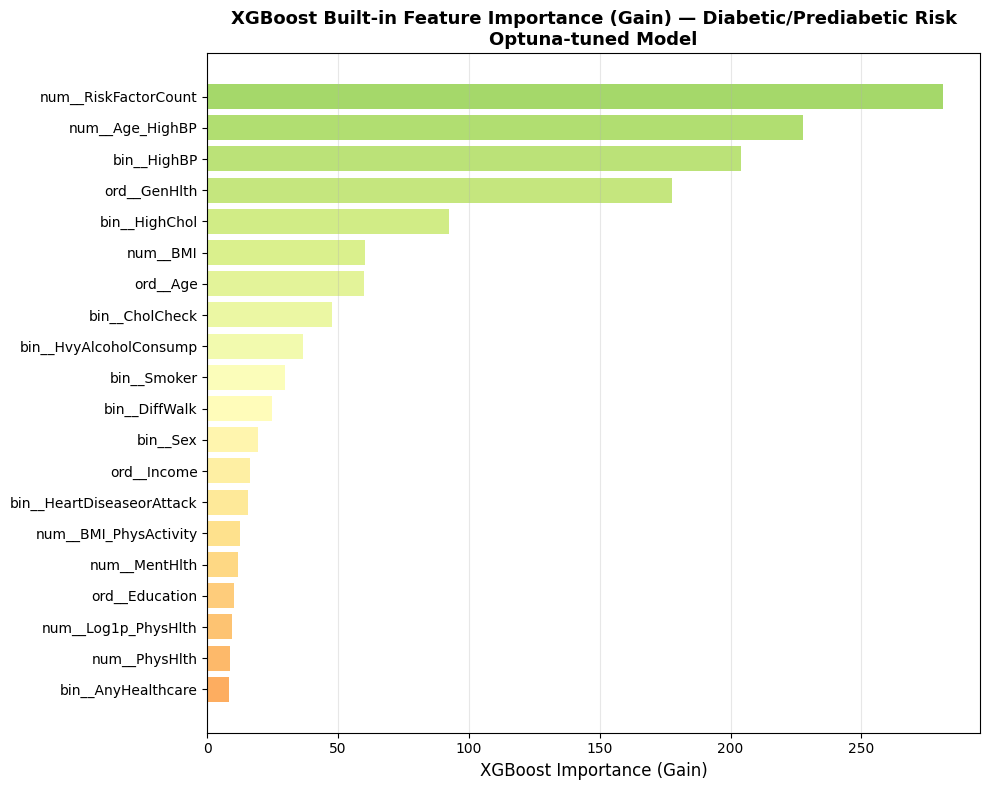

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/xgboost_importance_comparison_binary.png


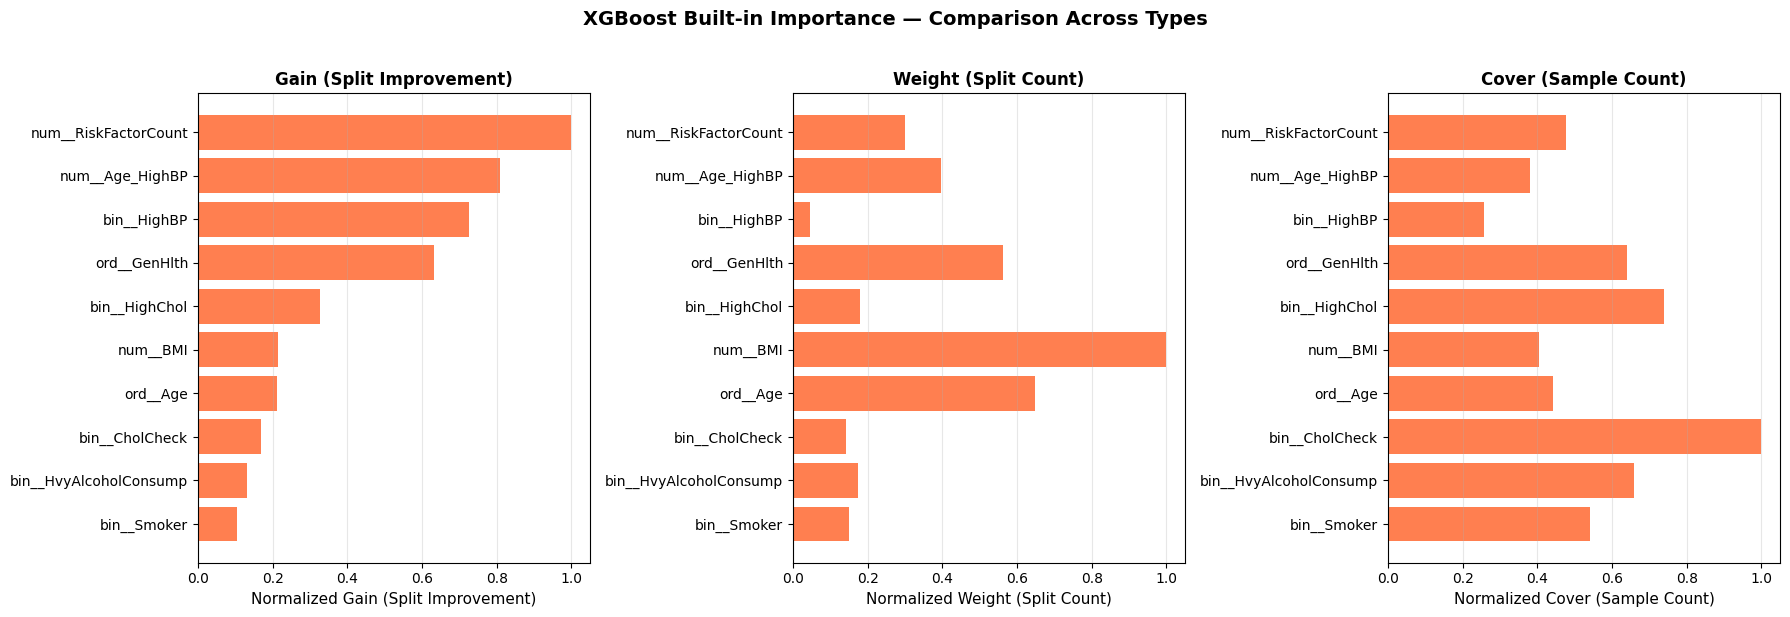


✅ XGBoost built-in importance analysis complete


In [ ]:
# ==========================
# XGBoost Built-in Feature Importance (BINARY)
# Goal:
#   - Extract gain, weight, and cover importance from the trained XGBoost model
#   - Compare with permutation importance
#   - Visualize top features across different importance types
# ==========================

print("="*60)
print("XGBOOST BUILT-IN FEATURE IMPORTANCE")
print("="*60)

# 1) Extract the trained XGBoost classifier from the pipeline
xgb_clf = xgb_featA_optuna.named_steps["clf"]

# 2) Get feature names (after preprocessing)
feature_names_transformed = preprocess_featA.get_feature_names_out()

# 3) Extract different importance types
# Gain: average gain (improvement in accuracy) brought by a feature to the splits
importance_gain = xgb_clf.get_booster().get_score(importance_type='gain')

# Weight: number of times a feature appears in a tree
importance_weight = xgb_clf.get_booster().get_score(importance_type='weight')

# Cover: average coverage (number of samples) affected by splits on the feature
importance_cover = xgb_clf.get_booster().get_score(importance_type='cover')

# 4) Convert to dataframes (XGBoost uses f0, f1, f2... internally)
def importance_to_df(importance_dict, feature_names, importance_name):
    """Convert XGBoost importance dict to dataframe with proper feature names."""
    # Create mapping from f0, f1, ... to actual feature names
    feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}
    
    # Convert to dataframe
    df = pd.DataFrame([
        {"feature": feature_map.get(k, k), importance_name: v}
        for k, v in importance_dict.items()
    ]).sort_values(importance_name, ascending=False).reset_index(drop=True)
    
    return df

df_gain = importance_to_df(importance_gain, feature_names_transformed, "gain")
df_weight = importance_to_df(importance_weight, feature_names_transformed, "weight")
df_cover = importance_to_df(importance_cover, feature_names_transformed, "cover")

# 5) Merge all importance types into one dataframe
xgb_importance = df_gain.merge(df_weight, on="feature", how="outer").merge(df_cover, on="feature", how="outer")
xgb_importance = xgb_importance.fillna(0).sort_values("gain", ascending=False)

# 6) Display top features
print("\n" + "="*60)
print("TOP 15 FEATURES (XGBoost Built-in Importance)")
print("="*60)
print(xgb_importance.head(15).to_string(index=False))

# 7) Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total features: {len(xgb_importance)}")
print(f"Top feature (gain): {xgb_importance.iloc[0]['feature']}")
print(f"Top gain: {xgb_importance.iloc[0]['gain']:.2f}")
print(f"Features used in trees: {(xgb_importance['weight'] > 0).sum()}")

# 8) Check engineered features
engineered_feats = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]
top10_xgb = set(xgb_importance.head(10)["feature"])
engineered_in_top10_xgb = [f for f in engineered_feats if any(f in feat for feat in top10_xgb)]

print(f"\n✅ Engineered features in top 10 (XGB gain): {len(engineered_in_top10_xgb)}")
if engineered_in_top10_xgb:
    print(f"   Features: {engineered_in_top10_xgb}")

# 9) Plot XGBoost importance (Gain)
plt.figure(figsize=(10, 8))
top_features_xgb = xgb_importance.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, 20))

plt.barh(
    range(len(top_features_xgb)),
    top_features_xgb['gain'].values[::-1],
    color=colors[::-1]
)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['feature'].values[::-1])
plt.xlabel('XGBoost Importance (Gain)', fontsize=12)
plt.title('XGBoost Built-in Feature Importance (Gain) — Diabetic/Prediabetic Risk\nOptuna-tuned Model', 
          fontweight='bold', fontsize=13)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
savefig("xgboost_importance_gain_binary.png")
plt.show()

# 10) Plot comparison across importance types (top 10 features by gain)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
top10_xgb = xgb_importance.head(10)

for ax, metric, title in zip(
    axes, 
    ['gain', 'weight', 'cover'],
    ['Gain (Split Improvement)', 'Weight (Split Count)', 'Cover (Sample Count)']
):
    # Normalize for better visualization
    values = top10_xgb[metric].values
    if values.max() > 0:
        values = values / values.max()  # Normalize to [0, 1]
    
    ax.barh(range(10), values[::-1], color='coral')
    ax.set_yticks(range(10))
    ax.set_yticklabels(top10_xgb['feature'].values[::-1])
    ax.set_xlabel(f'Normalized {title}', fontsize=11)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('XGBoost Built-in Importance — Comparison Across Types', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
savefig("xgboost_importance_comparison_binary.png")
plt.show()

print("\n✅ XGBoost built-in importance analysis complete")

FEATURE IMPORTANCE COMPARISON

📊 Correlation between permutation and XGBoost importance: -0.147

Top 10 by Permutation Importance:
                 feature  importance_mcc_mean  gain
3                    BMI             0.093598   0.0
9                GenHlth             0.081488   0.0
21       RiskFactorCount             0.043025   0.0
1             Age_HighBP             0.040426   0.0
12              HighChol             0.032290   0.0
0                    Age             0.010468   0.0
10  HeartDiseaseorAttack             0.008186   0.0
13     HvyAlcoholConsump             0.007364   0.0
14                Income             0.005693   0.0
22                   Sex             0.005248   0.0

Top 10 by XGBoost Gain:
                   feature        gain  importance_mcc_mean
47    num__RiskFactorCount  281.266693                  0.0
40         num__Age_HighBP  227.787491                  0.0
31             bin__HighBP  203.863129                  0.0
50            ord__GenHlth  177.

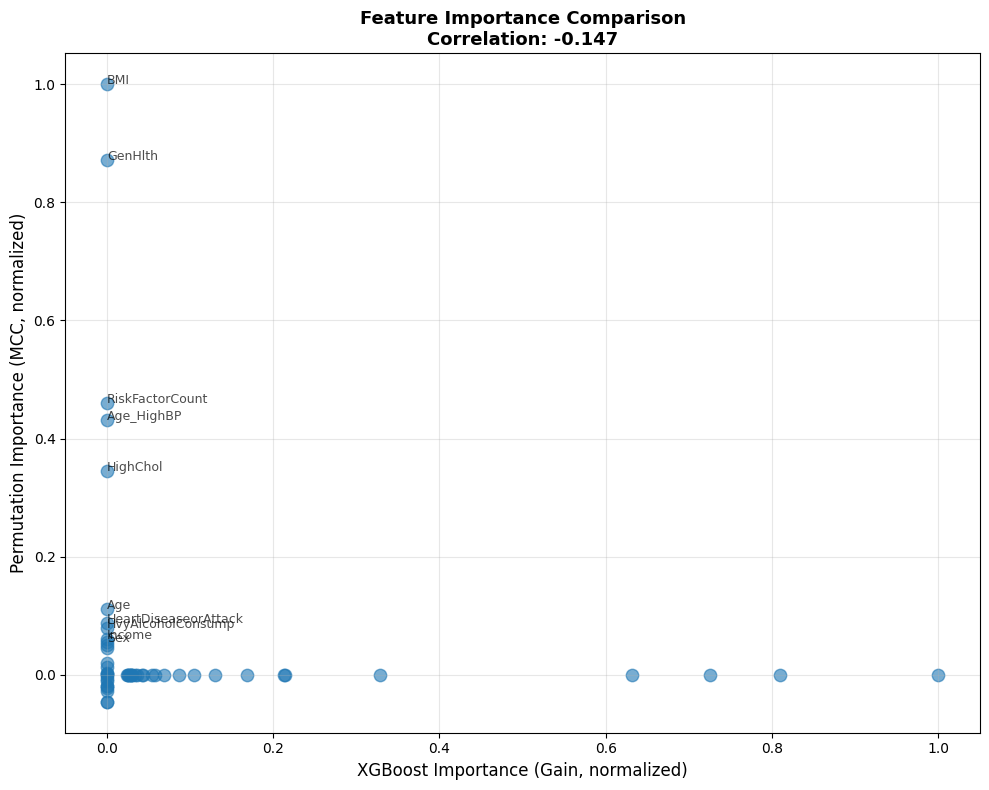


✅ Comparison complete


In [ ]:
# ==========================
# COMPARISON: Permutation vs XGBoost Importance
# ==========================

print("="*60)
print("FEATURE IMPORTANCE COMPARISON")
print("="*60)

# Merge permutation and XGBoost importance
comparison = perm_results[['feature', 'importance_mcc_mean']].merge(
    xgb_importance[['feature', 'gain']], 
    on='feature', 
    how='outer'
).fillna(0)

# Normalize for comparison
comparison['perm_norm'] = comparison['importance_mcc_mean'] / comparison['importance_mcc_mean'].max()
comparison['xgb_norm'] = comparison['gain'] / comparison['gain'].max()

# Correlation between methods
corr = comparison[['perm_norm', 'xgb_norm']].corr().iloc[0, 1]
print(f"\n📊 Correlation between permutation and XGBoost importance: {corr:.3f}")

# Top 10 comparison
print("\nTop 10 by Permutation Importance:")
print(comparison.sort_values('importance_mcc_mean', ascending=False).head(10)[['feature', 'importance_mcc_mean', 'gain']])

print("\nTop 10 by XGBoost Gain:")
print(comparison.sort_values('gain', ascending=False).head(10)[['feature', 'gain', 'importance_mcc_mean']])

# Scatter plot comparison
plt.figure(figsize=(10, 8))
plt.scatter(comparison['xgb_norm'], comparison['perm_norm'], alpha=0.6, s=80)

# Label top features
top_features_comp = comparison.nlargest(10, 'perm_norm')
for _, row in top_features_comp.iterrows():
    plt.annotate(row['feature'], (row['xgb_norm'], row['perm_norm']), 
                fontsize=9, alpha=0.7)

plt.xlabel('XGBoost Importance (Gain, normalized)', fontsize=12)
plt.ylabel('Permutation Importance (MCC, normalized)', fontsize=12)
plt.title(f'Feature Importance Comparison\nCorrelation: {corr:.3f}', 
         fontweight='bold', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
savefig("importance_comparison_scatter.png")
plt.show()

print("\n✅ Comparison complete")

**Global SHAP**

In [68]:
# ==========================
# SHAP — Cell 1 (Setup) — BINARY CLASSIFICATION
# Goal:
#   - Use your OPTUNA-TUNED XGB pipeline (xgb_featA_optuna)
#   - Build a SHAP TreeExplainer on the *trained XGB model*
#   - Prepare transformed background data + feature names
# ==========================

# ✅ Use the correct variable name from your notebook
assert "preprocess" in xgb_featA_optuna.named_steps, "xgb_featA_optuna must be a fitted Pipeline with a 'preprocess' step."
assert "clf" in xgb_featA_optuna.named_steps, "xgb_featA_optuna must be a fitted Pipeline with a 'clf' step."

# Extract preprocessor + fitted classifier
pre = xgb_featA_optuna.named_steps["preprocess"]
clf = xgb_featA_optuna.named_steps["clf"]

# Background sample (keep small-ish for speed)
# ✅ Use X_train_fe_A (Feature Set A with engineered features)
bg = X_train_fe_A.sample(2000, random_state=42)
X_bg = pre.transform(bg)

# Feature names after preprocessing (matches X_bg columns)
feature_names = pre.get_feature_names_out()

# Build explainer (TreeExplainer is the right choice for XGBoost tree models)
explainer = shap.TreeExplainer(
    clf,
    data=X_bg,
    feature_names=feature_names
)

print("✅ SHAP Cell 1 complete")
print("Background shape:", X_bg.shape)
print("Transformed feature count:", len(feature_names))
print(f"Model type: {type(clf).__name__}")
print(f"Objective: {clf.objective}")  # Should show 'binary:logistic'

✅ SHAP Cell 1 complete
Background shape: (2000, 26)
Transformed feature count: 26
Model type: XGBClassifier
Objective: binary:logistic


In [ ]:
# ==========================
# SHAP — Cell 2 (Compute SHAP on a sample of EVAL rows) — BINARY
# Goal:
#   - Sample 5000 rows from X_eval_fe_A (Feature Set A)
#   - Transform them with the SAME preprocessor
#   - Compute SHAP values
#   - Handle binary classification output (no class dimension OR 2D array)
#   - Create mapping from eval *position* -> shap row
# ==========================

# 1) Sample eval ROW POSITIONS (0..len(eval)-1), NOT global dataframe indices
rng = np.random.default_rng(42)
eval_pos = rng.choice(len(X_eval_fe_A), size=5000, replace=False)

# 2) Get raw rows from Feature Set A, then transform using preprocessor
X_eval_sample_raw = X_eval_fe_A.iloc[eval_pos]
X_shap = pre.transform(X_eval_sample_raw)  # numpy array (n_samples, n_features)

# 3) Compute SHAP values
shap_values = explainer.shap_values(X_shap)

# 4) Handle binary classification output
# For binary classification, XGBoost SHAP returns either:
#   - A single array (n_samples, n_features) for class 1 (diabetic)
#   - OR a list [class0_shap, class1_shap]
print(f"SHAP output type: {type(shap_values)}")

if isinstance(shap_values, list):
    # If list, extract class 1 (diabetic/prediabetic) explanations
    print(f"SHAP returned list with {len(shap_values)} classes")
    shap_values_class1 = shap_values[1]  # Class 1 = Diabetic/Prediabetic
else:
    # Single array: already class 1 explanations
    print("SHAP returned single array (class 1 explanations)")
    shap_values_class1 = shap_values

# 5) Verify shape
print(f"Final SHAP shape: {shap_values_class1.shape}")
assert shap_values_class1.shape == (len(eval_pos), len(feature_names)), \
    f"Expected ({len(eval_pos)}, {len(feature_names)}), got {shap_values_class1.shape}"

# 6) Create mapping: eval position -> row within shap array
pos_to_shap = {int(p): i for i, p in enumerate(eval_pos)}

print("\n✅ SHAP Cell 2 complete (BINARY)")
print(f"X_shap shape: {X_shap.shape}")
print(f"SHAP array shape: {shap_values_class1.shape}")
print(f"Example mapping: eval pos {int(eval_pos[0])} -> shap row {pos_to_shap[int(eval_pos[0])]}")
print(f"Feature count: {shap_values_class1.shape[1]}")

 99%|===================| 4966/5000 [00:52<00:00]        

SHAP output type: <class 'numpy.ndarray'>
SHAP returned single array (class 1 explanations)
Final SHAP shape: (5000, 26)

✅ SHAP Cell 2 complete (BINARY)
X_shap shape: (5000, 26)
SHAP array shape: (5000, 26)
Example mapping: eval pos 30743 -> shap row 0
Feature count: 26


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_global_importance_binary.png


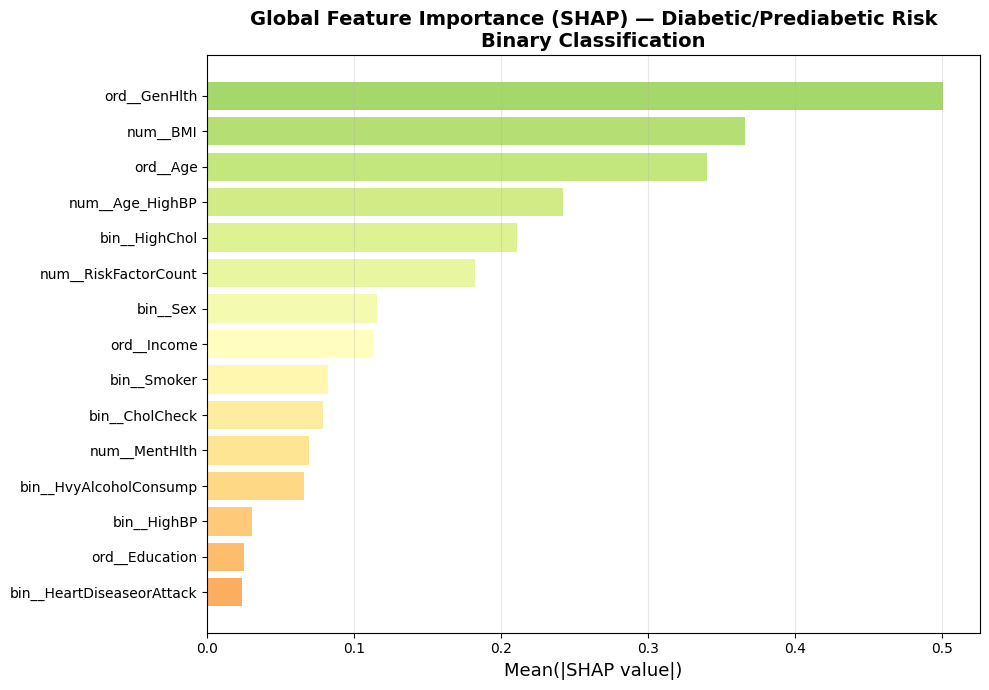

TOP 15 FEATURES DRIVING DIABETES RISK
                      feature  mean_abs_shap
0                ord__GenHlth       0.500819
1                    num__BMI       0.365838
2                    ord__Age       0.340135
3             num__Age_HighBP       0.241991
4               bin__HighChol       0.210775
5        num__RiskFactorCount       0.182296
6                    bin__Sex       0.115637
7                 ord__Income       0.112585
8                 bin__Smoker       0.082040
9              bin__CholCheck       0.078995
10              num__MentHlth       0.069344
11     bin__HvyAlcoholConsump       0.066108
12                bin__HighBP       0.030325
13             ord__Education       0.024734
14  bin__HeartDiseaseorAttack       0.023423

SUMMARY STATISTICS
Total features: 26
Top feature: ord__GenHlth
Top feature importance: 0.5008
Mean importance (all features): 0.0977
Std importance: 0.1300

✅ Engineered features in top 10: 2
   Features: ['RiskFactorCount', 'Age_HighBP']



In [ ]:
# ==========================
# SHAP — Cell 3 (Global Feature Importance) — BINARY
# Goal:
#   - Compute mean(|SHAP|) for the DIABETIC class (class 1)
#   - Create bar chart showing top features driving diabetes risk
#   - Generate summary table
# ==========================

# For binary classification, we only have class 1 (diabetic) SHAP values
# No class dimension — shap_values_class1 shape is (n_samples, n_features)

# 1) Compute mean absolute SHAP value per feature
mean_abs_shap = np.mean(np.abs(shap_values_class1), axis=0)

# 2) Create importance dataframe
imp_global = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

# 3) Plot top N features
topN = 15

plt.figure(figsize=(10, 7))
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, topN))
plt.barh(
    imp_global.loc[:topN-1, "feature"][::-1], 
    imp_global.loc[:topN-1, "mean_abs_shap"][::-1],
    color=colors[::-1]
)
plt.xlabel("Mean(|SHAP value|)", fontsize=13)
plt.title("Global Feature Importance (SHAP) — Diabetic/Prediabetic Risk\nBinary Classification", 
          fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
savefig("shap_global_importance_binary.png")
plt.show()

# 4) Display top 15 features
print("="*60)
print("TOP 15 FEATURES DRIVING DIABETES RISK")
print("="*60)
print(imp_global.head(15).to_string(index=True))

# 5) Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total features: {len(feature_names)}")
print(f"Top feature: {imp_global.iloc[0]['feature']}")
print(f"Top feature importance: {imp_global.iloc[0]['mean_abs_shap']:.4f}")
print(f"Mean importance (all features): {mean_abs_shap.mean():.4f}")
print(f"Std importance: {mean_abs_shap.std():.4f}")

# 6) Check if engineered features appear in top 10
engineered_feats = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]
top10_feats = set(imp_global.head(10)["feature"])
engineered_in_top10 = [f for f in engineered_feats if any(f in feat for feat in top10_feats)]

print(f"\n✅ Engineered features in top 10: {len(engineered_in_top10)}")
if engineered_in_top10:
    print(f"   Features: {engineered_in_top10}")

print("\n✅ SHAP Cell 3 complete (BINARY)")

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_summary_beeswarm_binary.png


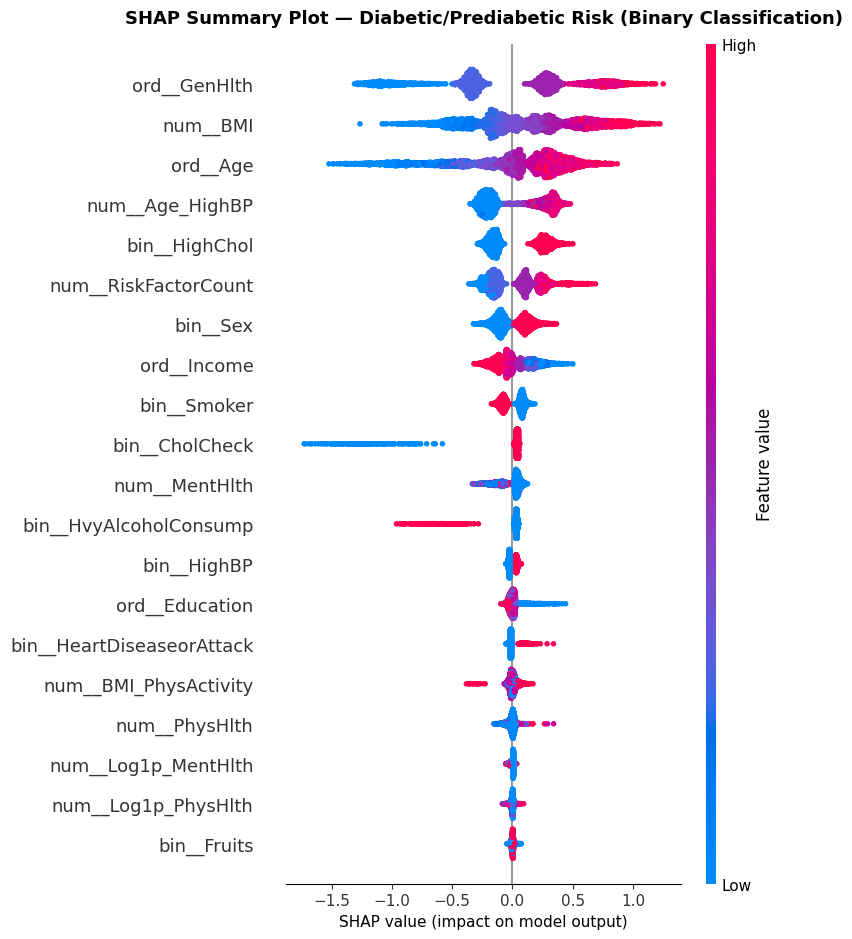

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_summary_bar_binary.png


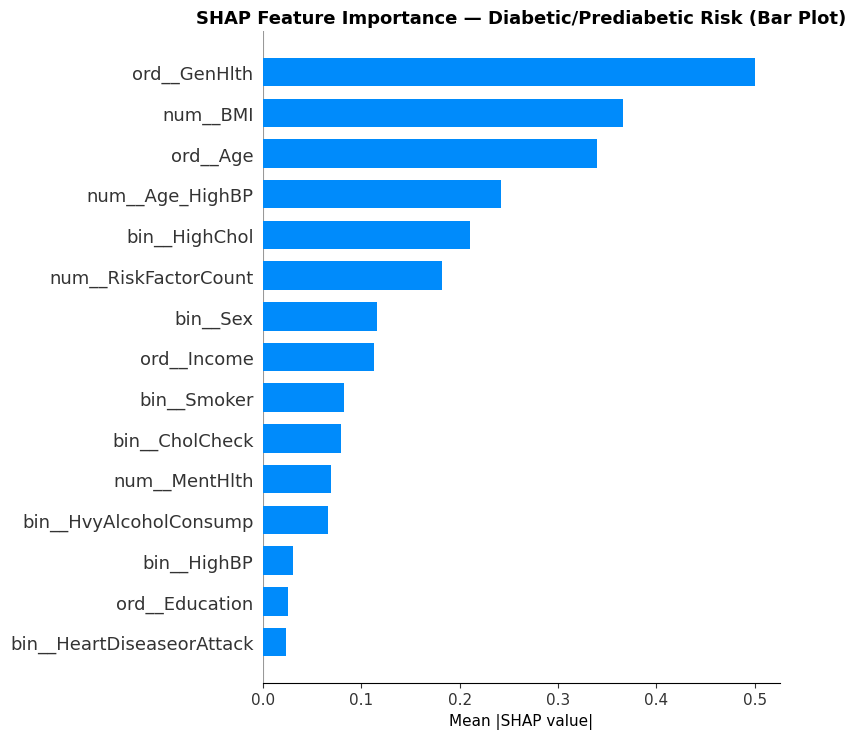


✅ SHAP Cell 4 complete (BINARY)
📊 Created 2 plots:
   1. Beeswarm plot (shows feature value distributions)
   2. Bar plot (cleaner for reports)


In [ ]:
# ==========================
# SHAP — Cell 4 (Beeswarm Summary Plot) — BINARY
# Goal:
#   - Create SHAP summary plot showing:
#     • Feature importance (vertical axis)
#     • Distribution of SHAP values (horizontal spread)
#     • Feature values (color: red=high, blue=low)
# ==========================

# Create SHAP Explanation object for summary plot
shap_explanation = shap.Explanation(
    values=shap_values_class1,
    base_values=np.full(len(shap_values_class1), explainer.expected_value),
    data=X_shap,
    feature_names=feature_names
)

# 1) Full summary plot (all features)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_explanation,
    max_display=20,  # Show top 20 features
    show=False
)
plt.title("SHAP Summary Plot — Diabetic/Prediabetic Risk (Binary Classification)", 
          fontweight='bold', fontsize=13, pad=15)
plt.xlabel("SHAP value (impact on model output)", fontsize=11)
plt.tight_layout()
savefig("shap_summary_beeswarm_binary.png")
plt.show()

# 2) Bar plot version (cleaner for reports)
plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_explanation,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("SHAP Feature Importance — Diabetic/Prediabetic Risk (Bar Plot)", 
          fontweight='bold', fontsize=13)
plt.xlabel("Mean |SHAP value|", fontsize=11)
plt.tight_layout()
savefig("shap_summary_bar_binary.png")
plt.show()

print("\n✅ SHAP Cell 4 complete (BINARY)")
print("📊 Created 2 plots:")
print("   1. Beeswarm plot (shows feature value distributions)")
print("   2. Bar plot (cleaner for reports)")

**Local SHAP**

LOCAL SHAP — 8 CASES (BINARY)
Rows available for local SHAP (in SHAP sample): 5000
Chosen eval positions: {'TP_high_conf': 9959, 'TP_borderline': 19884, 'FN_worst': 22900, 'FN_border': 4468, 'FP_high_conf': 23050, 'FP_border': 27599, 'TN_high_conf': 735, 'TN_border': 33630}
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_TP_high_conf.png


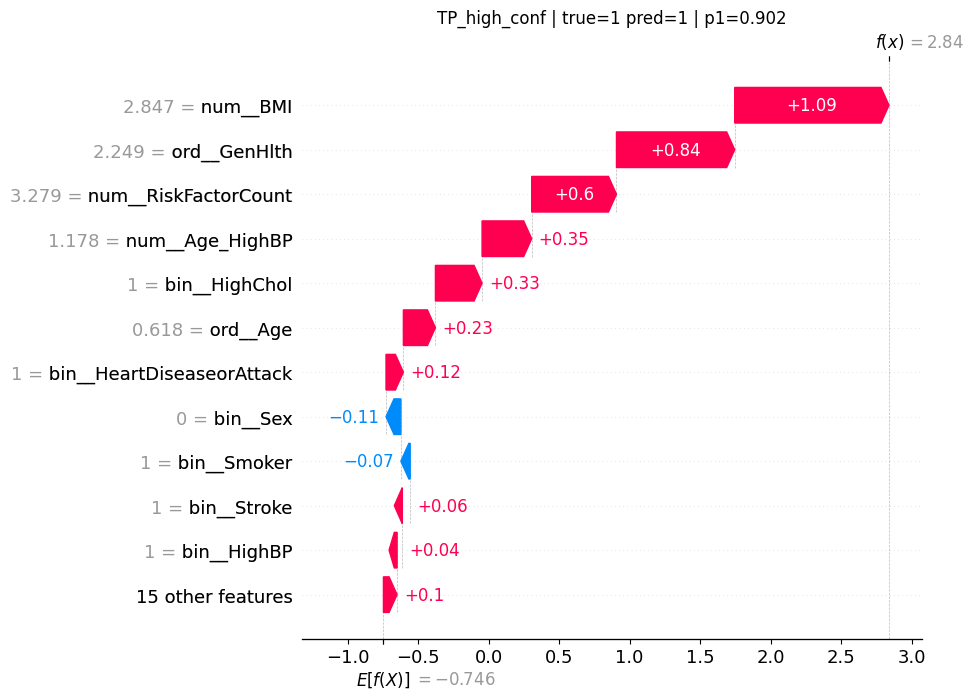

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_TP_borderline.png


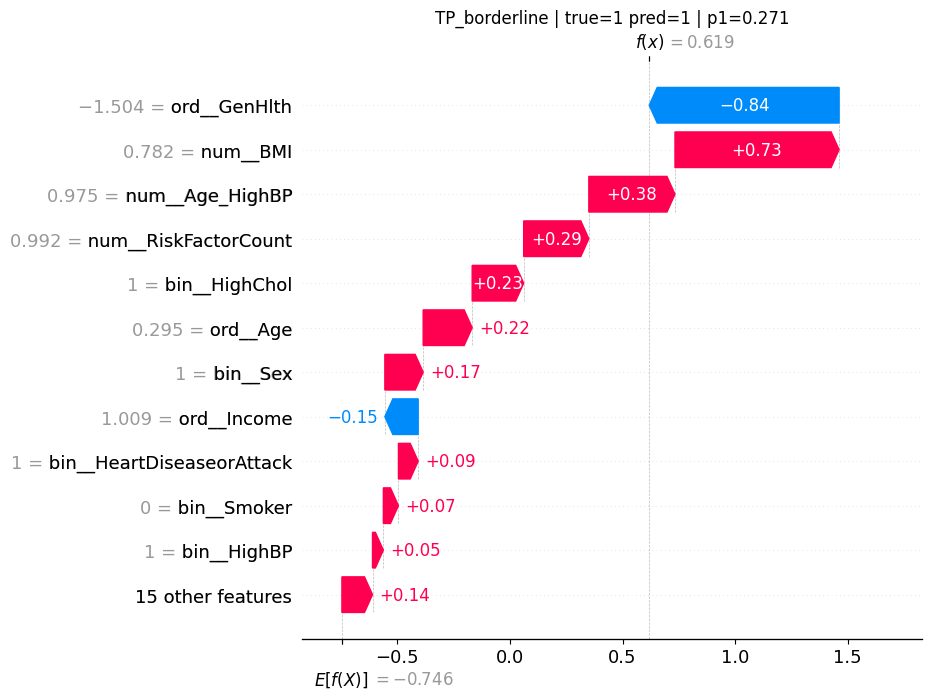

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_FN_worst.png


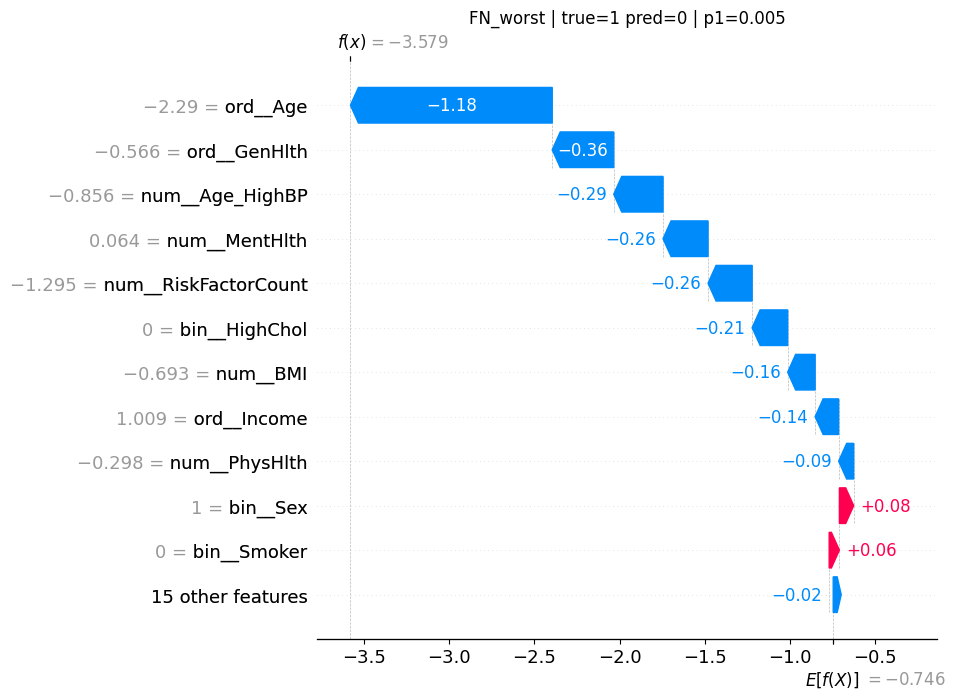

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_FN_border.png


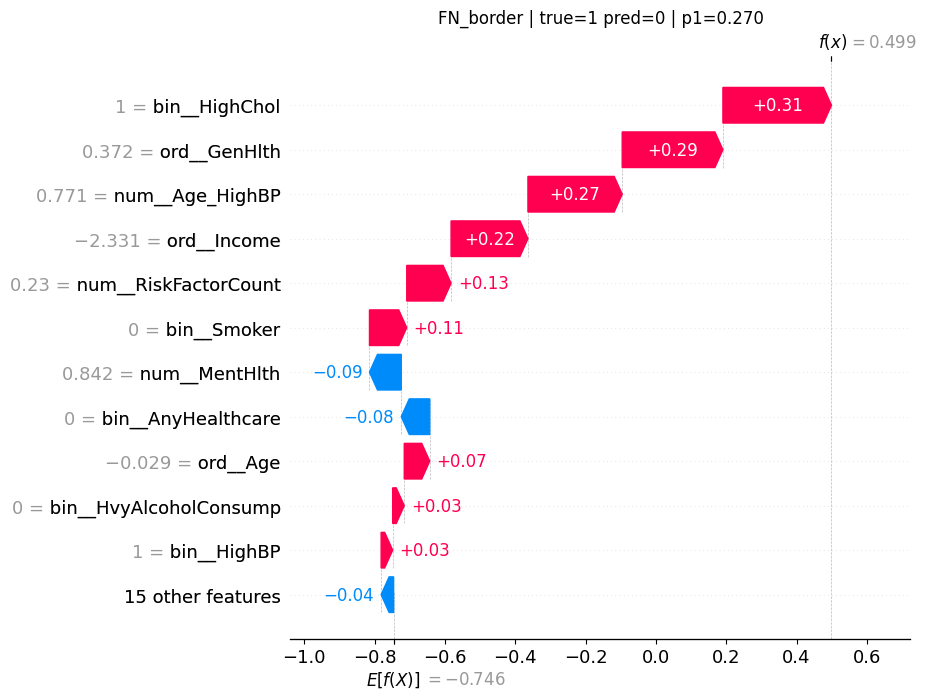

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_FP_high_conf.png


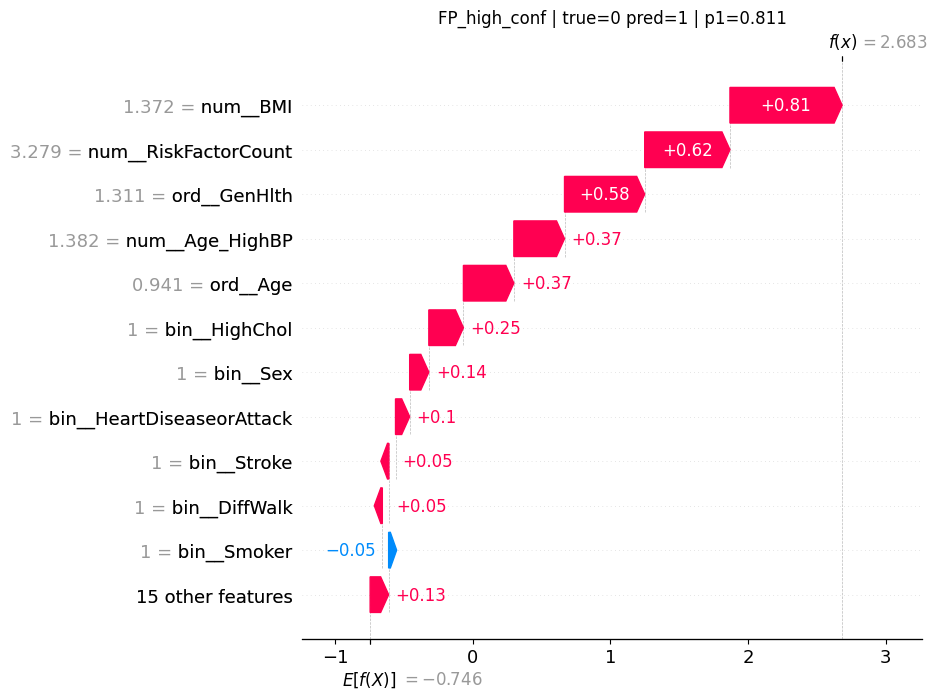

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_FP_border.png


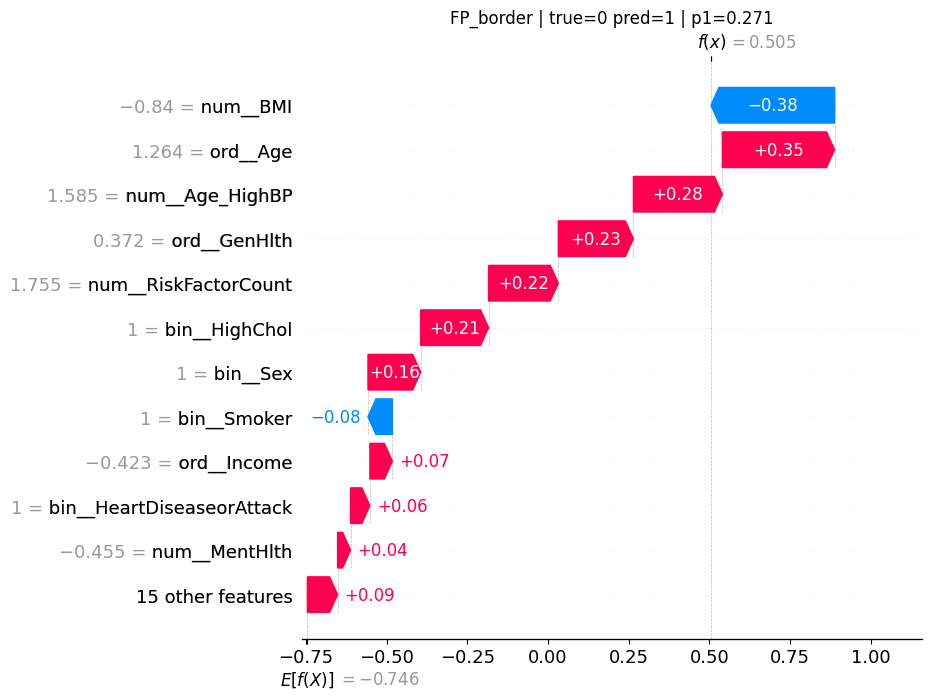

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_TN_high_conf.png


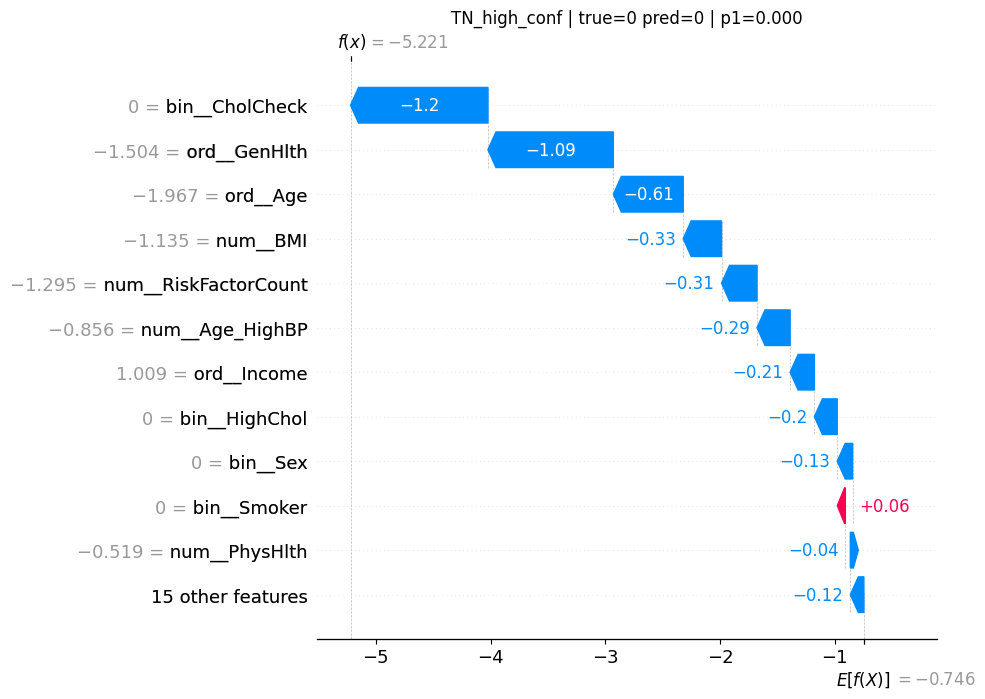

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_local_TN_border.png


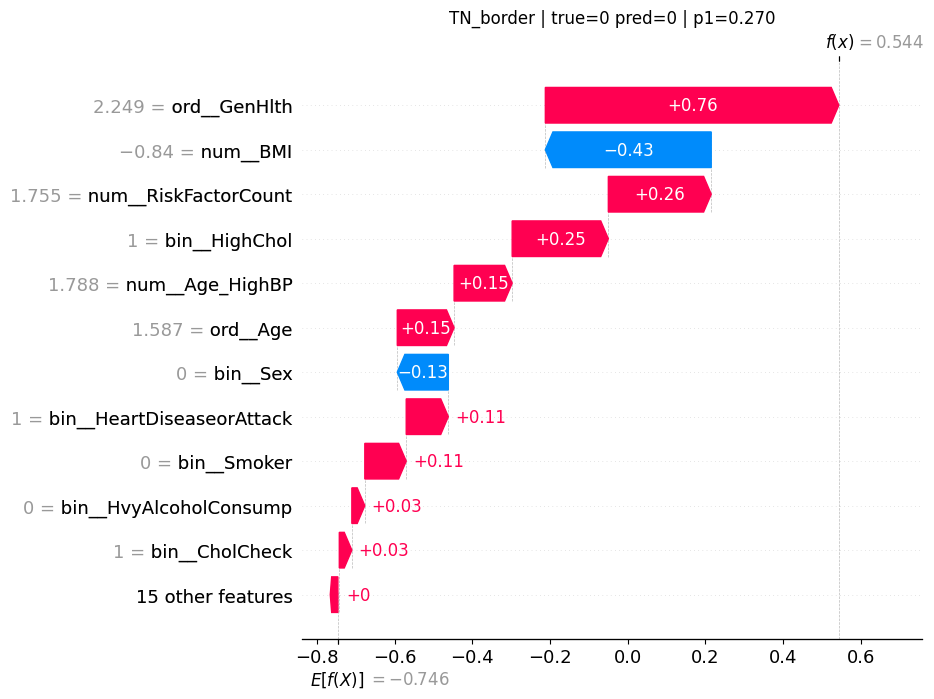

✅ Local SHAP (binary) complete


In [ ]:
# ==========================
# Local SHAP — 8 Case Types (Binary)
# Uses calibrated probs for selection, SHAP from TreeExplainer
# ==========================

print("="*60)
print("LOCAL SHAP — 8 CASES (BINARY)")
print("="*60)

# 1) Use calibrated model + threshold for predictions
model_pipeline, threshold = final_model
p1_eval = model_pipeline.predict_proba(X_eval_fe_A)[:, 1]
y_pred_eval = (p1_eval >= threshold).astype(int)

# 2) Build evaluation table (by eval POSITION)
df_eval = pd.DataFrame({
    "eval_pos": np.arange(len(y_eval)),
    "y_true": np.asarray(y_eval).astype(int),
    "y_pred": y_pred_eval,
    "p1": p1_eval
})

# 3) Keep only rows that exist in SHAP sample (from Cell 2)
df_eval = df_eval[df_eval["eval_pos"].isin(pos_to_shap.keys())].copy()
print("Rows available for local SHAP (in SHAP sample):", len(df_eval))

# 4) Helper to pick rows
def pick_row(df, desc, ascending):
    if df.empty:
        print(f"⚠️ No candidates for {desc}")
        return None
    return int(df.sort_values("p1", ascending=ascending)["eval_pos"].iloc[0])

# 5) Define 8 cases
cases = {
    "TP_high_conf":  pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==1)], "TP_high_conf", ascending=False),
    "TP_borderline":pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==1)], "TP_borderline", ascending=True),
    "FN_worst":     pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==0)], "FN_worst", ascending=True),
    "FN_border":    pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==0)], "FN_border", ascending=False),
    "FP_high_conf": pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==1)], "FP_high_conf", ascending=False),
    "FP_border":    pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==1)], "FP_border", ascending=True),
    "TN_high_conf": pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==0)], "TN_high_conf", ascending=True),
    "TN_border":    pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==0)], "TN_border", ascending=False),
}

print("Chosen eval positions:", cases)

# 6) Plot local SHAP (waterfall) for class 1
def plot_local_shap(eval_pos, tag, max_display=12):
    if eval_pos is None:
        return
    shap_row = pos_to_shap[eval_pos]
    sv = shap_values_class1[shap_row, :]
    x_row = X_shap[shap_row, :]
    r = df_eval[df_eval.eval_pos == eval_pos].iloc[0]

    base_val = explainer.expected_value
    exp = shap.Explanation(
        values=sv,
        base_values=base_val,
        data=x_row,
        feature_names=feature_names
    )

    title = f"{tag} | true={int(r.y_true)} pred={int(r.y_pred)} | p1={r.p1:.3f}"
    shap.plots.waterfall(exp, max_display=max_display, show=False)
    plt.title(title)
    savefig(f"shap_local_{tag}.png")
    plt.show()

for tag, pos in cases.items():
    plot_local_shap(pos, tag)

print("✅ Local SHAP (binary) complete")

**LIME**

LOCAL LIME — 8 CASES (BINARY)
Chosen eval positions: {'TP_high_conf': 9407, 'TP_borderline': 33808, 'FN_worst': 17121, 'FN_border': 21716, 'FP_high_conf': 16593, 'FP_border': 23596, 'TN_high_conf': 26745, 'TN_border': 209}


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_TP_high_conf.png


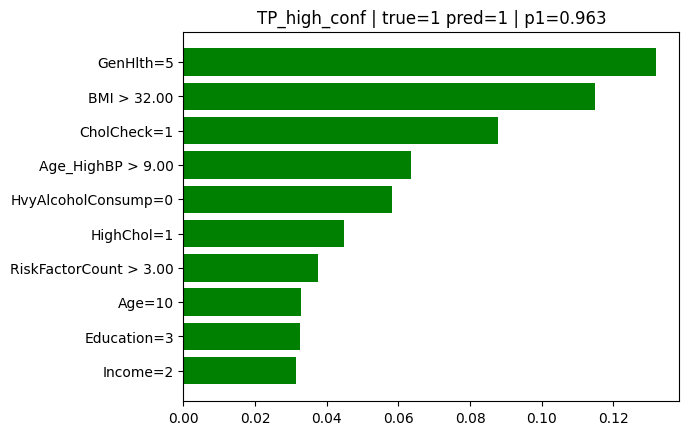

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_TP_borderline.png


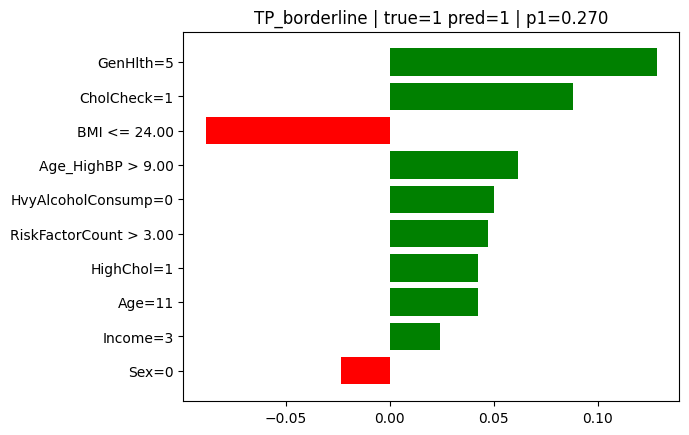

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_FN_worst.png


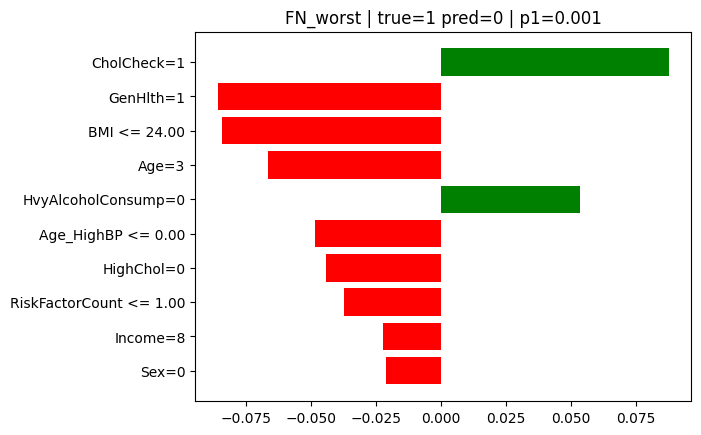

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_FN_border.png


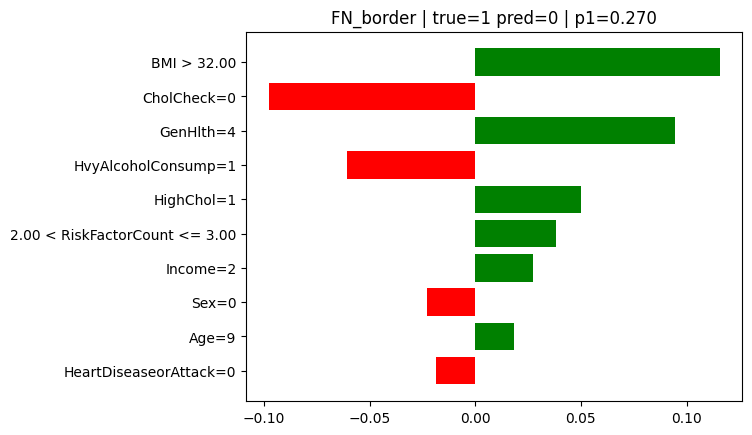

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_FP_high_conf.png


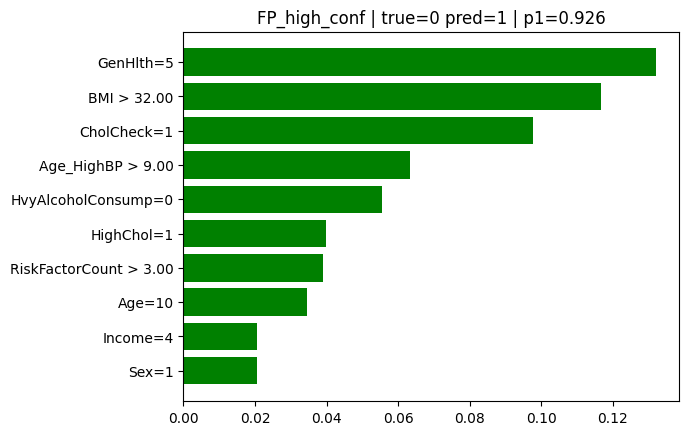

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_FP_border.png


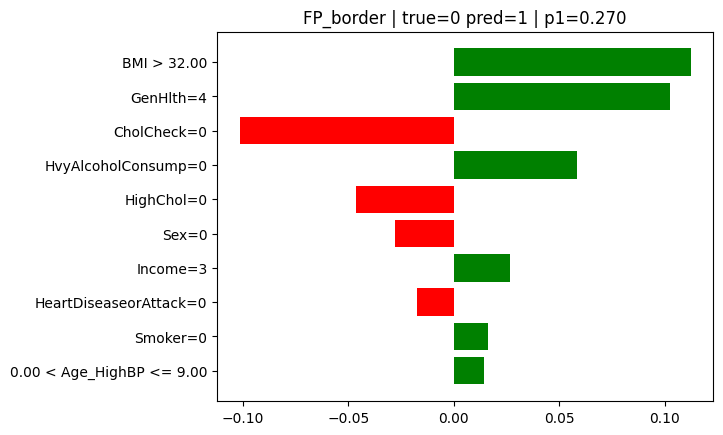

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_TN_high_conf.png


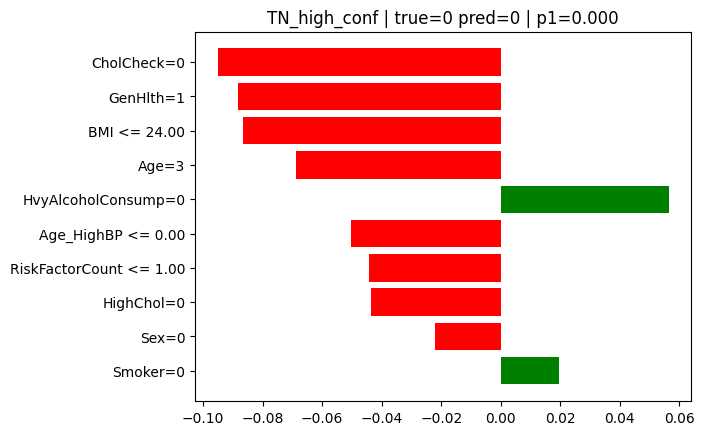

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/lime_local_TN_border.png


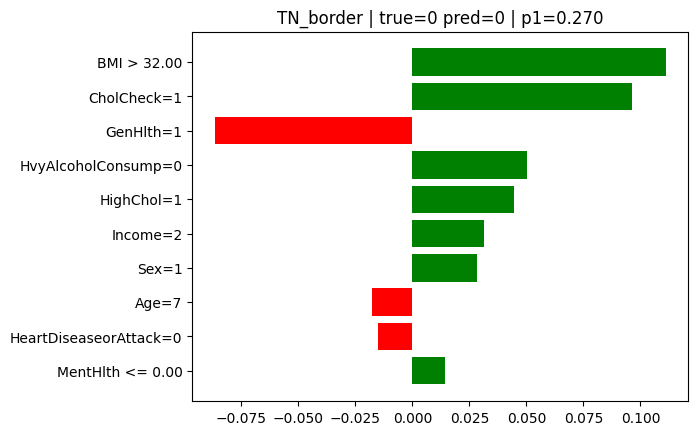

✅ Local LIME complete


In [ ]:
# ==========================
# Local LIME — 8 Case Types (Binary)
# ==========================
print("="*60)
print("LOCAL LIME — 8 CASES (BINARY)")
print("="*60)

# 1) Use calibrated model + threshold for predictions
model_pipeline, threshold = final_model
p1_eval = model_pipeline.predict_proba(X_eval_fe_A)[:, 1]
y_pred_eval = (p1_eval >= threshold).astype(int)

# 2) Build evaluation table (by eval POSITION)
df_eval = pd.DataFrame({
    "eval_pos": np.arange(len(y_eval)),
    "y_true": np.asarray(y_eval).astype(int),
    "y_pred": y_pred_eval,
    "p1": p1_eval
})

# 3) Helper to pick rows
def pick_row(df, desc, ascending):
    if df.empty:
        print(f"⚠️ No candidates for {desc}")
        return None
    return int(df.sort_values("p1", ascending=ascending)["eval_pos"].iloc[0])

# 4) Define 8 cases (same logic as SHAP)
cases = {
    "TP_high_conf":  pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==1)], "TP_high_conf", ascending=False),
    "TP_borderline":pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==1)], "TP_borderline", ascending=True),
    "FN_worst":     pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==0)], "FN_worst", ascending=True),
    "FN_border":    pick_row(df_eval[(df_eval.y_true==1) & (df_eval.y_pred==0)], "FN_border", ascending=False),
    "FP_high_conf": pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==1)], "FP_high_conf", ascending=False),
    "FP_border":    pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==1)], "FP_border", ascending=True),
    "TN_high_conf": pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==0)], "TN_high_conf", ascending=True),
    "TN_border":    pick_row(df_eval[(df_eval.y_true==0) & (df_eval.y_pred==0)], "TN_border", ascending=False),
}

print("Chosen eval positions:", cases)

# 5) LIME explainer setup
feature_names_lime = X_train_fe_A.columns.tolist()

categorical_cols = set(binary_features + ordinal_features)
categorical_indices = [i for i, c in enumerate(feature_names_lime) if c in categorical_cols]

lime_explainer = LimeTabularExplainer(
    training_data=X_train_fe_A.values,
    feature_names=feature_names_lime,
    class_names=["Non-Diabetic", "Diabetic/Prediabetic"],
    categorical_features=categorical_indices,
    discretize_continuous=True,
    mode="classification",
    random_state=42
)

# 6) Wrapper so LIME passes a DataFrame (ColumnTransformer needs column names)
def lime_predict_proba(X_np):
    X_df = pd.DataFrame(X_np, columns=feature_names_lime)
    return model_pipeline.predict_proba(X_df)

# 7) Plot local LIME explanations
def plot_local_lime(eval_pos, tag, num_features=10):
    if eval_pos is None:
        return
    x_row = X_eval_fe_A.iloc[eval_pos].values
    r = df_eval[df_eval.eval_pos == eval_pos].iloc[0]

    exp = lime_explainer.explain_instance(
        x_row,
        lime_predict_proba,
        num_features=num_features
    )

    fig = exp.as_pyplot_figure()
    title = f"{tag} | true={int(r.y_true)} pred={int(r.y_pred)} | p1={r.p1:.3f}"
    plt.title(title)
    savefig(f"lime_local_{tag}.png")
    plt.show()


for tag, pos in cases.items():
    plot_local_lime(pos, tag)

print("✅ Local LIME complete")

SIDE-BY-SIDE LOCAL SHAP vs LIME
Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_TP_high_conf.png


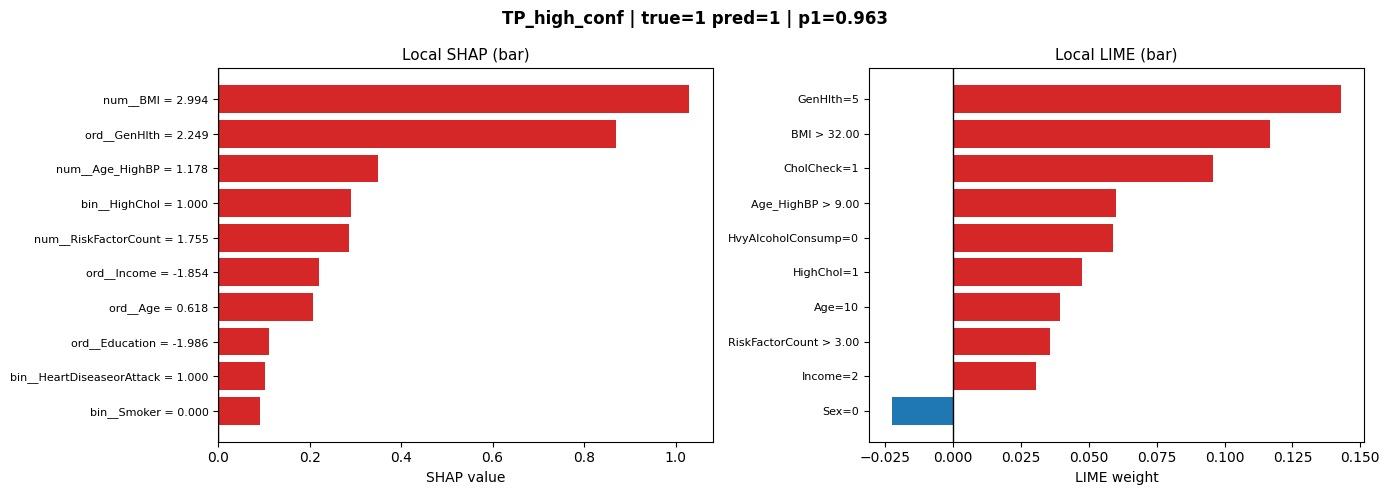

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_TP_borderline.png


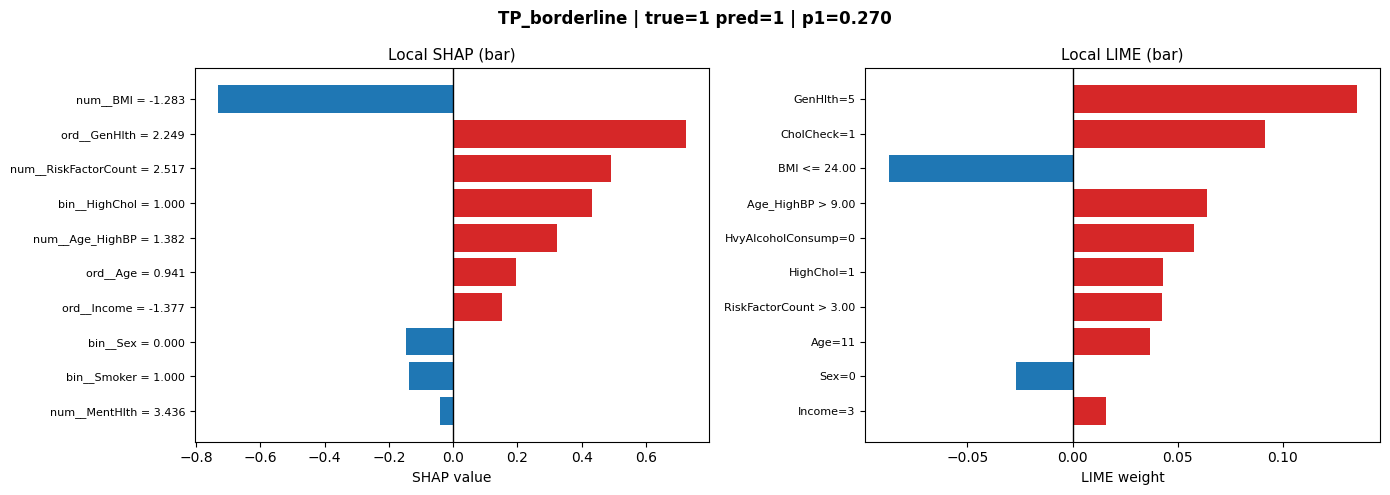

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_FN_worst.png


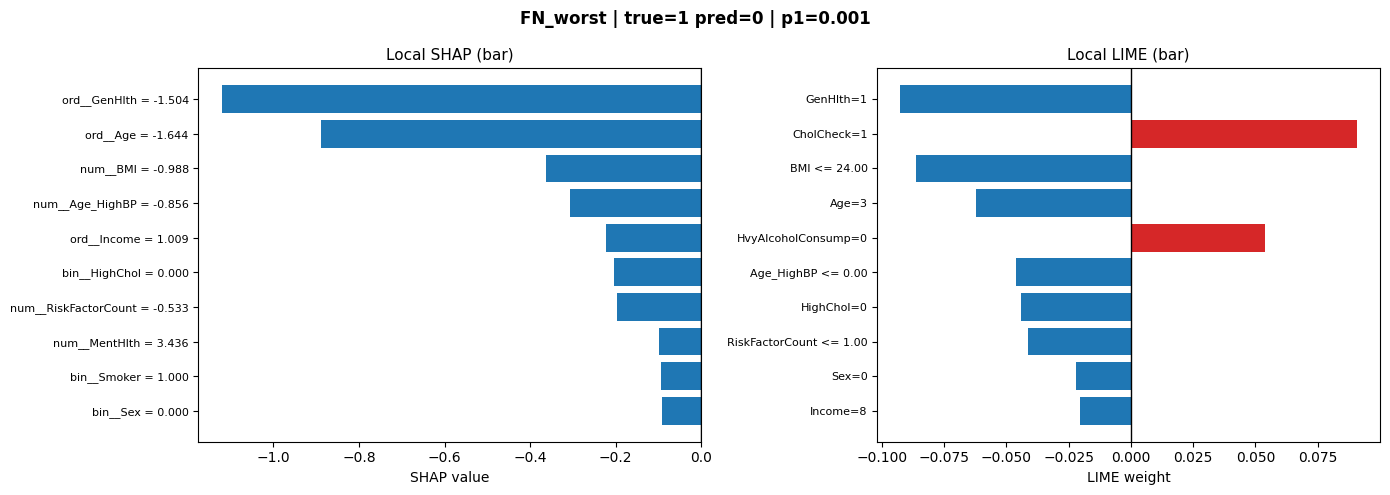

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_FN_border.png


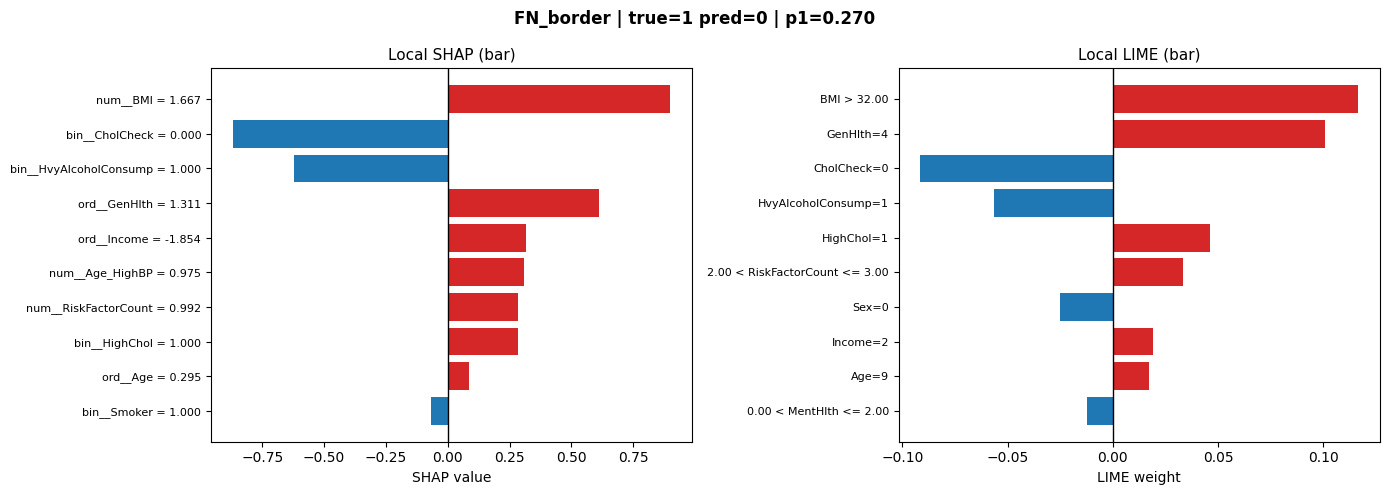

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_FP_high_conf.png


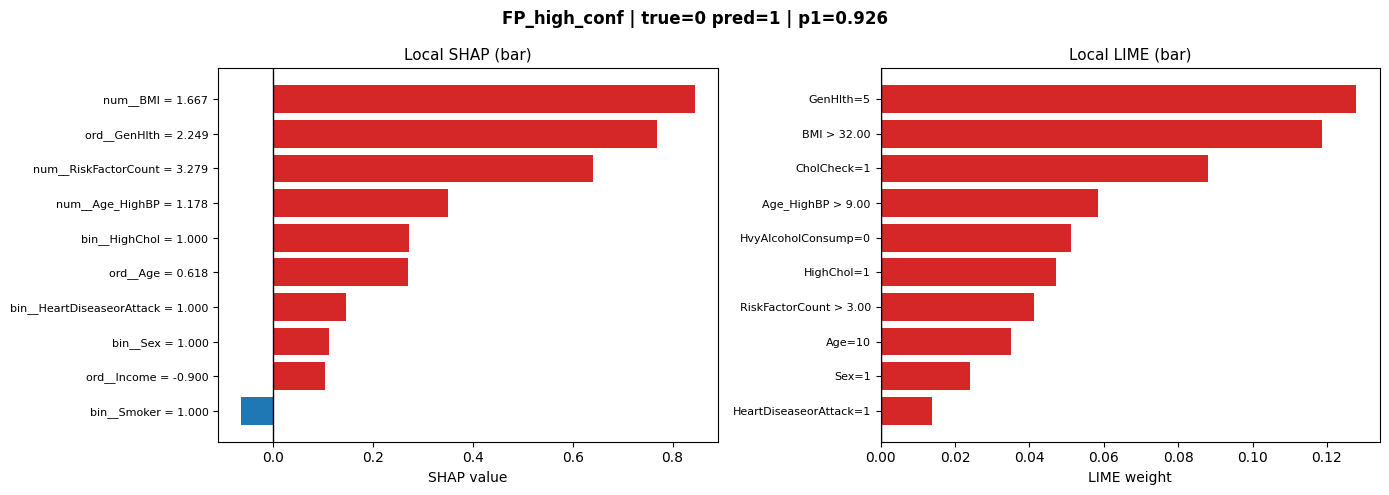

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_FP_border.png


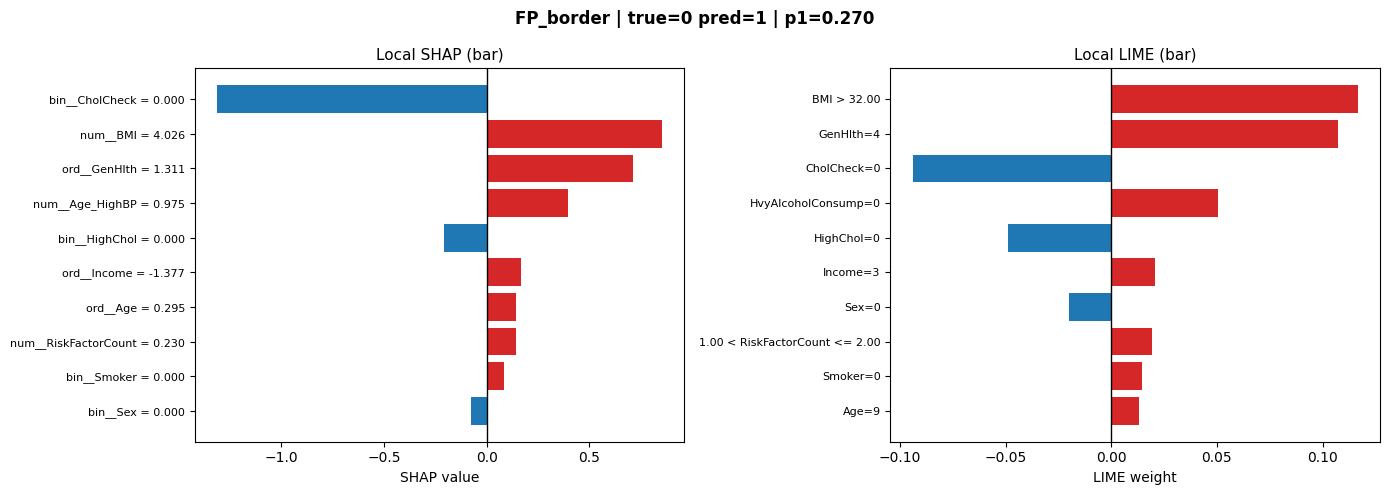

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_TN_high_conf.png


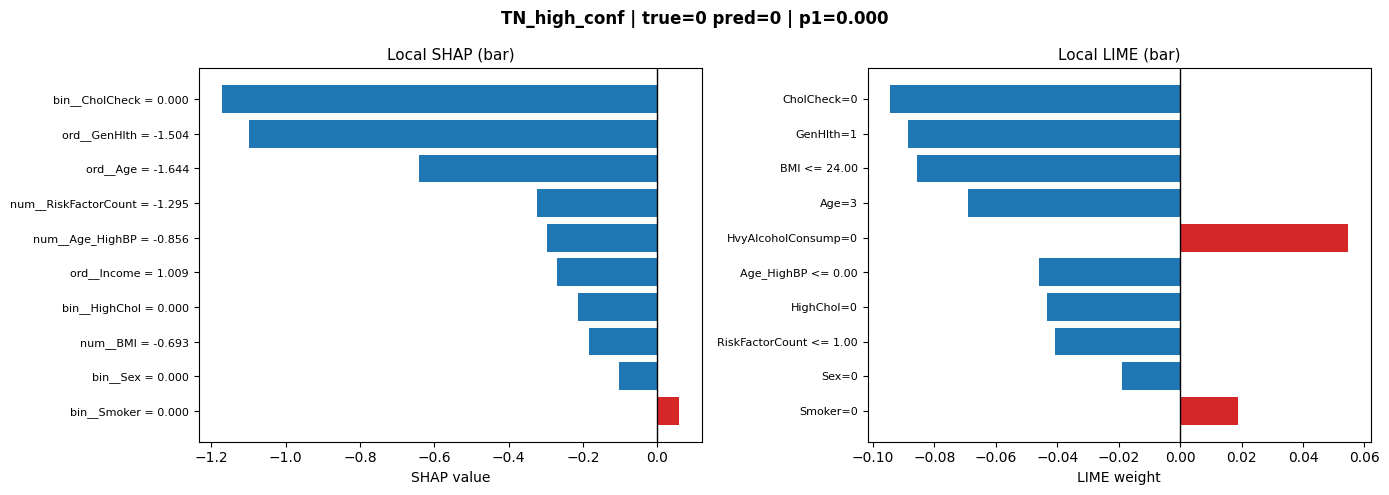

Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_binary/shap_lime_side_by_side_TN_border.png


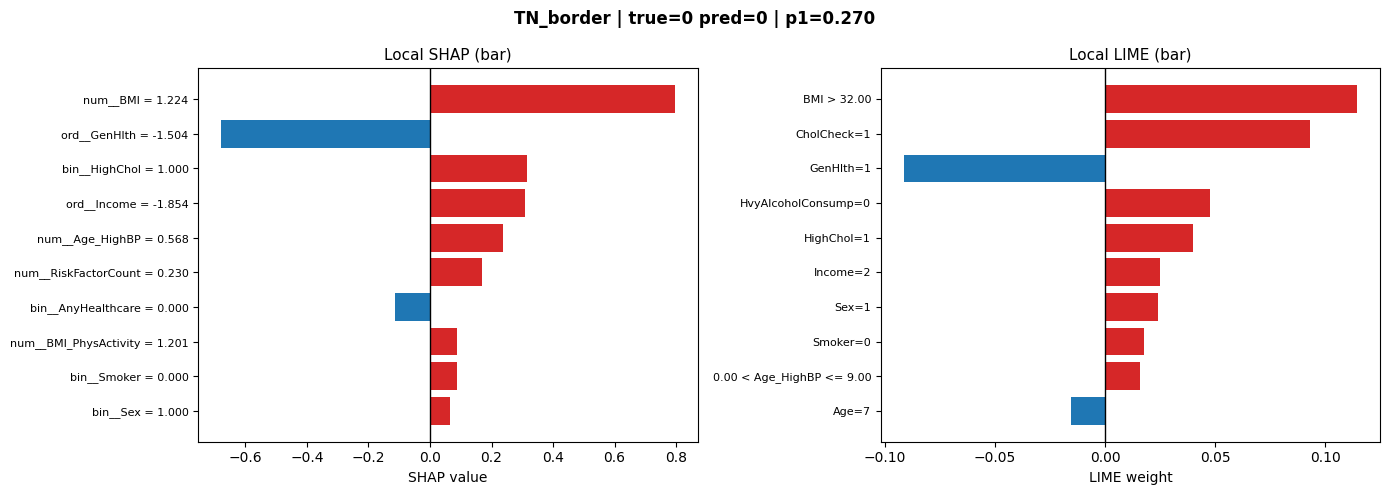

✅ Side-by-side plots saved


In [ ]:
# ==========================
# Side-by-side Local SHAP vs Local LIME (per case)
# ==========================
print("="*60)
print("SIDE-BY-SIDE LOCAL SHAP vs LIME")
print("="*60)

# Use the SAME cases chosen in the previous Local SHAP/LIME cells
case_positions = [p for p in cases.values() if p is not None]
if len(case_positions) == 0:
    raise ValueError("No valid case positions found in `cases`.")

# Compute SHAP ONLY for those case rows (so it matches previous plots)
X_eval_case_raw = X_eval_fe_A.iloc[case_positions]
X_shap = pre.transform(X_eval_case_raw)
shap_values_case = explainer.shap_values(X_shap)

if isinstance(shap_values_case, list):
    shap_values_class1 = shap_values_case[1]
else:
    shap_values_class1 = shap_values_case

# Map eval_pos -> row in this small SHAP batch
pos_to_shap = {int(p): i for i, p in enumerate(case_positions)}

def _plot_local_shap_bar(ax, eval_pos, max_display=10):
    shap_row = pos_to_shap[eval_pos]
    sv = shap_values_class1[shap_row, :]
    x_row = X_shap[shap_row, :]
    feat_vals = dict(zip(feature_names, x_row))

    idx = np.argsort(np.abs(sv))[-max_display:]
    feats = [feature_names[i] for i in idx]
    vals = sv[idx]

    labels = [f"{f} = {feat_vals[f]:.3f}" for f in feats]

    ax.barh(range(len(feats)), vals, color=["#d62728" if v > 0 else "#1f77b4" for v in vals])
    ax.set_yticks(range(len(feats)))
    ax.set_yticklabels(labels, fontsize=8)
    ax.axvline(0, color="k", lw=1)
    ax.set_title("Local SHAP (bar)", fontsize=11)
    ax.set_xlabel("SHAP value")

def _plot_local_lime_bar(ax, exp, max_display=10):
    items = exp.as_list()[:max_display]
    feats = [f for f, _ in items][::-1]
    vals = [v for _, v in items][::-1]

    ax.barh(range(len(feats)), vals, color=["#d62728" if v > 0 else "#1f77b4" for v in vals])
    ax.set_yticks(range(len(feats)))
    ax.set_yticklabels(feats, fontsize=8)
    ax.axvline(0, color="k", lw=1)
    ax.set_title("Local LIME (bar)", fontsize=11)
    ax.set_xlabel("LIME weight")

def plot_local_pair(eval_pos, tag, num_features=10):
    if eval_pos is None:
        return
    if eval_pos not in pos_to_shap:
        print(f"⚠️ Skipping {tag}: eval_pos {eval_pos} not in SHAP batch")
        return

    r = df_eval[df_eval.eval_pos == eval_pos].iloc[0]
    x_row = X_eval_fe_A.iloc[eval_pos].values

    exp_lime = lime_explainer.explain_instance(
        x_row,
        lime_predict_proba,
        num_features=num_features
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    _plot_local_shap_bar(axes[0], eval_pos, max_display=num_features)
    _plot_local_lime_bar(axes[1], exp_lime, max_display=num_features)

    title = f"{tag} | true={int(r.y_true)} pred={int(r.y_pred)} | p1={r.p1:.3f}"
    fig.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    savefig(f"shap_lime_side_by_side_{tag}.png")
    plt.show()

for tag, pos in cases.items():
    plot_local_pair(pos, tag, num_features=10)

print("✅ Side-by-side plots saved")